In [3]:
import numpy as np
from numpy import eye, dot
import math
import matplotlib.pyplot as plt
import os
import sys
from filterpy.kalman import ExtendedKalmanFilter as EKF
from filterpy.stats import logpdf
from filterpy.common import pretty_str, reshape_z
import os, sys
from filterpy.kalman import UnscentedKalmanFilter

import seaborn as sns
import math
sns.set(style = 'white', font_scale = 1.5)
import pickle

In [4]:
#sys.path.append(r'C:\\Users\\Zhaobin\\Desktop\\Columbia\\ARZ')
from arz_model import QHU_3Para, QHU_Green_Shield, LF
class QHU_3Para_augDerivative(QHU_3Para):
    def dQ(self,rho):
        rho_max = self.para['rho_jam']
        alpha = self.para['alpha']

        a = (self.g(1) - self.g(0)) / rho_max
        b = self.dg(rho / rho_max) / rho_max

        return alpha * (a - b)
    def dg(self,rho):
        lamda = self.para['lambda']
        p = self.para['p']
        numer = lamda ** 2 * (rho - p)
        denum = self.g(rho)
        return numer / denum
    def dU(self,rho):
        return (self.dQ(rho)*rho - self.Q(rho)) / rho**2
    def dh(self,rho):
        para = self.para
        if para["is_h_original_with_beta"] == 1:
            beta = para["beta"]; gamma = para["gamma"]; rho_jam = para["rho_jam"]
            x = rho / rho_jam
            t_1 = 1/2/np.sqrt(x/(1-x)); t_2=1/(1-x)**2; t_3 = 1/rho_jam
            return beta*t_1*t_2*t_3
        else:
            # by default use the simplest h function
            return  -1 * self.dU(rho)
        
class QHU_Green_Shield_augDerivative(QHU_Green_Shield):
    def dU(self, rho):
        para = self.para
        u_free = para["u_free"]; rho_jam = para["rho_jam"]
        return -1* u_free/rho_jam
    def dQ(self, rho):
        return 1*self.U(rho) + rho*self.dU(rho)

    def dh(self,rho):
        para = self.para
        if para["is_h_original_with_beta"] == 1:
            beta = para["beta"]; gamma = para["gamma"]; rho_jam = para["rho_jam"]
            x = rho / rho_jam
            t_1 = 1/2/np.sqrt(x/(1-x)); t_2=1/(1-x)**2; t_3 = 1/rho_jam
            return beta*t_1*t_2*t_3
        else:
            # by default use the simplest h function
            return  -1 * self.dU(rho)

In [5]:
class Partial_ARZ():
    def __init__(self,  QHU, PARA):
        '''
        for the df_rho, because it is widely used and structurally simple, we save it as a value
        for others, like the du, we write the function to obtain it
        among these 'others', if it is intermeidate value, like dy_temp, we write a function and then save it as a value
        
        'df_rho_drho_L' the first rho means the rho in the next state, to seperate with the drho, which mean current state
        '''
        
        self.PARA = PARA
        self.QHU = QHU
        self.C = PARA['dt']/PARA['dx']
        self.Lambda = PARA['dt']/PARA['tau']
        #self.rho_L = rho_L; self.rho_R = rho_R
        #self.u_L = u_L; self.u_R = u_R
    def calculate_partial(self,rho_L, rho_R, y_L, y_R):
        # f_rho
        C = self.C
        Lambda = self.Lambda
        self.rho = self.get_f_rho(rho_L, rho_R, y_L, y_R)
        self.y = self.get_f_y(rho_L, rho_R, y_L, y_R)
        
        # df_rho
        self.df_rho_drho_L = 1/2 + C/2 * ( self.QHU.U(rho_L) + rho_L*self.QHU.dU(rho_L) )
        self.df_rho_drho_R = 1/2 - C/2 * ( self.QHU.U(rho_R) + rho_R*self.QHU.dU(rho_R) )
        self.df_rho_dy_L =  1 * C/2 * np.ones(y_L.shape)
        self.df_rho_dy_R = -1 * C/2 * np.ones(y_R.shape)
        
        # y
        self.df_y_drho_L =  1 * C/2 * (-1*y_L**2/rho_L**2 + y_L*self.QHU.dU(rho_L))
        self.df_y_drho_R = -1 * C/2 * (-1*y_R**2/rho_R**2 + y_R*self.QHU.dU(rho_R))
        self.df_y_dy_L = (1/2 - Lambda/2)*y_L + C/2 * ( 2*y_L/rho_L + self.QHU.U(rho_L) )
        self.df_y_dy_R = (1/2 - Lambda/2)*y_R - C/2 * ( 2*y_R/rho_R + self.QHU.U(rho_R) )
        
    def get_f_rho(self, rho_L, rho_R, y_L, y_R):
        C = self.C
        term_1 = (rho_L + rho_R)/2
        term_2 = C/2 * ( 
            (y_R + rho_R*self.QHU.U(rho_R)) -
            (y_L + rho_L*self.QHU.U(rho_L))
        )
        return term_1 - term_2
    
    def get_f_y(self, rho_L, rho_R, y_L, y_R):
        C = self.C
        Lambda = self.Lambda
        term_1 = (y_L + y_R)/2
        term_2 = C/2* (
            (y_R**2/rho_R + y_R*self.QHU.U(rho_R)) - 
            (y_L**2/rho_L + y_L*self.QHU.U(rho_L))
        )
        term_3 = Lambda/2*(y_L+y_R)
        return term_1 - term_2 - term_3
    

In [6]:
# the matrix and its auxiliary


# ##################
# f_at isthe p_arz.calculate_partial().rho
def f_at(x, **kwargs):
    p_arz = kwargs['p_arz']
    N = int(round(len(x)/2))
    
    #rho_current = x[:N].reshape(-1,1)
    #u_current = x[N:].reshape(-1,1)
    
    #rho_L = np.vstack([rho_current[-1], rho_current[:-1]])
    #rho_R = np.vstack([rho_current[1:], rho_current[0]])
    #u_L = np.vstack([u_current[-1], u_current[:-1]])
    #u_R = np.vstack([u_current[1:], u_current[0]])
    
    rho_L = np.hstack([x[0], x[:N-1]])
    rho_R = np.hstack([x[1:N], x[N-1]])
    y_L = np.hstack([x[N], x[N:2*N-1]])
    y_R = np.hstack([x[N+1:], x[-1]])
    p_arz.calculate_partial(rho_L, rho_R, y_L, y_R)
    
    rho = p_arz.rho.flatten()
    y = p_arz.y.flatten()
    return np.hstack([rho,y])
    
    
# #################

# h_at
def h_at(x, loops):
    N = int(round(len(x)/2))
    result_rho = [x[i] for i in loops]
    result_y = [x[N+i] for i in loops]
    return np.array(result_rho + result_y)

def Hjacobian(x, N, loops):
    # N is actually the length of x
    H_jacobian = np.zeros( (2*len(loops),N) )
    for i in range(len(loops)):
        H_jacobian[i, loops[i]] = 1
        H_jacobian[i+len(loops), loops[i]+int(round(N/2))] = 1
    return H_jacobian


def Fjacobian(x, **f_kwargs):
    # rho: 0, 1, 2,..., N-1
    # u  : N, N+1, ..., 2N-1
    p_arz = f_kwargs['p_arz']
    F = np.zeros((len(x), len(x)))
    N = int(round(len(x)/2))
    rho_L = np.hstack([x[0], x[:N-1]])
    rho_R = np.hstack([x[1:N], x[N-1]])
    y_L = np.hstack([x[N], x[N:2*N-1]])
    y_R = np.hstack([x[N+1:], x[-1]])
    p_arz.calculate_partial(rho_L, rho_R, y_L, y_R)
    
    F[0, 0] = p_arz.df_rho_drho_L[0]# rho[0] partial rho L, 0 itself
    F[0, 1] = p_arz.df_rho_drho_R[0]# rho[0] partial rho R
    F[0, 0+N] = p_arz.df_rho_dy_L[0]# rho[0] partial u L
    F[0, 1+N] = p_arz.df_rho_dy_R[0]# rho[0] partial u  
    
    F[N-1, -1+N] = p_arz.df_rho_drho_R[-1]# rho[-1] partial rho R, -1 itself
    F[N-1, -2+N] = p_arz.df_rho_drho_L[-1]# rho[-1] partial rho L
    F[N-1, -1+N+N] = p_arz.df_rho_dy_R[-1]# rho[-1] partial u R, -1 itself
    F[N-1, -2+N+N] = p_arz.df_rho_dy_L[-1]# rho[-1] partial u L
    
    F[N, 0] = p_arz.df_y_drho_L[0]# u[0] partial rho L, 
    F[N, 1] = p_arz.df_y_drho_R[0]# u[0] partial rho R
    F[N, 0+N] = p_arz.df_y_dy_L[0]# u[0] partial u L, 
    F[N, 1+N] = p_arz.df_y_dy_R[0]# u[0] partial u R, 
    
    F[-1+N+N, -1+N] = p_arz.df_y_drho_R[-1]# u[-1] partial rho R 
    F[-1+N+N, -2+N] = p_arz.df_y_drho_L[-1]# u[-1] partial rho L
    F[-1+N+N, -1+N+N] = p_arz.df_y_dy_R[-1]# u[-1] partial u R
    F[-1+N+N, -2+N+N] = p_arz.df_y_dy_L[-1]# u[-1] partial u L

    for i in range(1, int(round(len(x)/2)) - 1):
        F[i, i-1] = p_arz.df_rho_drho_L[i]#rho partial rho L
        F[i, i+1] = p_arz.df_rho_drho_R[i]#rho partial rho R
        F[i, i-1+N] = p_arz.df_rho_dy_L[i]#rho partial u L
        F[i, i+1+N] = p_arz.df_rho_dy_R[i]#rho partial u R
        
        F[i+N, i-1] = p_arz.df_y_drho_L[i]#u partial rho L
        F[i+N, i+1] = p_arz.df_y_drho_R[i]#u partial rho R
        F[i+N, i-1+N] = p_arz.df_y_dy_L[i]#u partial u L
        F[i+N, i+1+N] = p_arz.df_y_dy_R[i]#u partial u R
        
        #F[i, i - 1] = partial_l(x[i - 1], **f_kwargs)
        #F[i, i + 1] = partial_r(x[i + 1], **f_kwargs)
    # arbitrary limit
    #for i in range(F.shape[0]):
    #    for j in range(F.shape[1]):
    #        F[i,j] = max(-10, F[i,j])
    #        F[i,j] = min(10, F[i,j])
    
    return F

In [7]:
class ARZEKF(EKF):
    def __init__(self, dim_x, dim_z_1, dim_z_2, std_pred, std_update):
        self.std_pred = std_pred
        self.std_update = std_update
        EKF.__init__(self, dim_x, dim_z_1+dim_z_2)
        
        # Q matrix
        half_N = int(round(dim_x/2))
        A = np.eye(half_N) * std_pred[0]
        B = np.eye(half_N) * std_pred[1]
        self.Q =  np.block([
                                [A,               np.zeros((half_N, half_N))],
                                [np.zeros((half_N, half_N)), B               ]
                            ])
        
     
        
        # R matrix
        A = np.eye(dim_z_1) * std_update[0]
        B = np.eye(dim_z_2) * std_update[1]
        self.R =  np.block([
                                [A,               np.zeros((dim_z_1, dim_z_2))],
                                [np.zeros((dim_z_2, dim_z_1)), B               ]
                            ])
        

    def predict_x(self, f_at, **f_kwargs):
        self.x = f_at(self.x, **f_kwargs)
        
        # min is 0.01x 
        #self.x = [max(0.01, self.x[i]) for i in range(len(self.x))]
        Rho = self.x[:21]
        Y = self.x[21:]
        
        # set the bounds on the variable
        Rho = [max(0.01, i) for i in Rho]
        Rho = [min(0.6, i) for i in Rho]
        Y = [max(-2, i) for i in Y]
        Y = [min(2, i) for i in Y]
        self.x = np.array(np.hstack([Rho,Y]))

    def predict(self, FJacobian, f_at, **f_kwargs):
        self.F = FJacobian(self.x, **f_kwargs)
        self.predict_x(f_at, **f_kwargs)

        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

def implement_kf(loops, dim_z_1, dim_z_2, rho, u,  config, **f_kwargs):
    std_Q = config['std_Q']
    std_R = config['std_R']
    init_rho = config['init_rho']
    init_u = config['init_u']
    init_P = config['init_P']
    
    para = f_kwargs['para']
    qhu_grn_sld = QHU_Green_Shield_augDerivative(para)
    p_arz = Partial_ARZ( qhu_grn_sld, para)

    lwrefk = ARZEKF(2*len(rho[:,0]),dim_z_1, dim_z_2,std_Q, std_R)
    lwrefk.x = np.hstack([init_rho, init_u])
    N = len(lwrefk.x)
    lwrefk.P = init_P
    X_pri = [lwrefk.x]
    X_pos = [lwrefk.x]
    Obs = []
    K = []
    P = []
    for i in range(1, rho.shape[1]):
        lwrefk.predict(Fjacobian, f_at, p_arz = p_arz)
        X_pri.append(lwrefk.x_prior)

        if i % 1 == 0:
            observe = [rho[k, i ] for k in loops] + [u[k, i ] for k in loops]
            Obs.append(observe)
            lwrefk.update(observe, Hjacobian, h_at, args=(N, loops),hx_args=(loops))
            #lwrefk.x = neibour_avg(lwrefk.x)
            lwrefk.x_post = lwrefk.x.copy()

        else:
            # X_pos.append(lwrefk.x_prior)
            pass
        K.append(lwrefk.K)
        P.append(lwrefk.P)
        X_pos.append(lwrefk.x_post)
    X_pos = np.vstack(X_pos).T
    X_pri = np.vstack(X_pri).T

    return X_pri, X_pos, K, P

In [8]:
path = "C:\\Users\\Zhaobin\\Desktop\\Columbia\\NGSIM\\Git\\NGSIM"
with open(os.path.join(path, "US101_Lane1to5_t1.5s30.pickle"), "rb") as f:
    data = pickle.load(f)
    
#with open( "US101_Lane1to5_t1.5s30.pickle", "rb") as f:
#    data = pickle.load(f)
    
# The real data provide the boundary and initial condition
u = data['vMat']
rho = data['rhoMat']
q = data['qMat']

# normalize the data
rhoM = rho.max()
uM = u.max()
#rho = rho / rhoM
#u = u /uM
#q = rho*u


t = data['t']
s = data['s']
dt = data['t'][1] - data['t'][0]
dx = data['s'][1] - data['s'][0]

In [9]:
# LF solver

PARA = {
    # general & green-shield flux
    "rho_jam": 1.13, # whatever, just a default value
    "u_free": 1.02,
    "tau":5,
    
    # three_para flux NOT USED in THE AZR EKF
    #"alpha": 0.1, # c in set_lwr_relation
    #"lambda":0.1, # stick to seibold's defition, not Kuang (1/lambda)
    #"p": 0.1, # b
    
    # h 
    #"beta": 0.1,
    #"gamma": 0.5,
    "is_h_original_with_beta": 0,
    "is_h_only_with_Ueq": 1,
    
    # grid
    'dt':dt,
    'dx':dx,
}

sum_h_swithces = PARA["is_h_original_with_beta"] + \
                    PARA["is_h_only_with_Ueq"]

# if sum_h_switthes == 0, by default use the h_only_with_Ueq
assert sum_h_swithces <= 1

In [20]:
# print the env variable
N = rho.shape[0]
T = rho.shape[1]
print('dt=', dt)
print('dx=', dx)
print('N=', N)
print('T=', T)
print('dx/dt', dx/dt)

dt= 1.5002705627705666
dx= 29.62194824347826
N= 21
T= 1770
dx/dt 19.74440409520205


In [10]:
LOOPS = {
2: [0, 239]
3: [0, 120, 239],
4: [0, 5, 11, 20],
#5: [0, 4, 8, 13, 20],
6: [0, 3, 7, 11, 14, 20],
#7: [0, 3, 6, 9, 12, 15, 20],
8: [0, 2, 5, 8, 11, 13, 16, 20],
#9: [0, 2, 4, 7, 9, 12, 14, 17, 20],
10: [0, 2, 4, 6, 8, 11, 13, 15, 17, 20],
#11: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
12: [0, 1, 3, 5, 7, 9, 11, 12, 14, 16, 18, 20],
#13: [0, 1, 3, 5, 6, 8, 10, 11, 13, 15, 16, 18, 20],
14: [0, 1, 3, 4, 6, 7, 9, 11, 12, 14, 15, 17, 18, 20],
#15: [0, 1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20],
16: [0, 1, 2, 4, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 19, 20],
18: [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20],
}

#loops = LOOPS[3]
#para = para_dict[len(loops)]
#PARA['rho_jam'] = para['rho_max']
#PARA['u_free'] = para['u_max']
#PARA['tau'] = para['tau']

In [11]:
import pickle
path = "C:\\Users\\Zhaobin\\Desktop\\Columbia\\ARZ\\fit_tau"

with open(os.path.join(path, 'loop_para_predefined_rhoM_1debug.pickle'), 'rb') as f:
    dict_predefined = pickle.load(f)
    
with open(os.path.join(path, 'loop_para_fitted_rhoM.pickle'), 'rb') as f:
    dict_fitted = pickle.load(f)

In [12]:
para_dict = dict_predefined

In [13]:
PARA

{'rho_jam': 1.13,
 'u_free': 1.02,
 'tau': 5,
 'is_h_original_with_beta': 0,
 'is_h_only_with_Ueq': 1,
 'dt': 1.5002705627705666,
 'dx': 29.62194824347826}

In [14]:
para_dict

{3: {'loops': [0, 7, 20],
  'rho_max': 0.6666666666666666,
  'u_max': 13.147082100429484,
  'tau': 27.60000000000001,
  'error': 0.2973132526425598},
 4: {'loops': [0, 5, 11, 20],
  'rho_max': 0.6666666666666666,
  'u_max': 13.206168383685421,
  'tau': 32.90000000000001,
  'error': 0.30017894759703384},
 5: {'loops': [0, 4, 8, 13, 20],
  'rho_max': 0.6666666666666666,
  'u_max': 13.252220385401904,
  'tau': 29.70000000000001,
  'error': 0.3043739519234081},
 6: {'loops': [0, 3, 7, 11, 14, 20],
  'rho_max': 0.6666666666666666,
  'u_max': 13.387813335849861,
  'tau': 28.80000000000001,
  'error': 0.30096953414153416},
 7: {'loops': [0, 3, 6, 9, 12, 15, 20],
  'rho_max': 0.6666666666666666,
  'u_max': 13.397392700555086,
  'tau': 29.40000000000002,
  'error': 0.3076923457164024},
 8: {'loops': [0, 2, 5, 8, 11, 13, 16, 20],
  'rho_max': 0.6666666666666666,
  'u_max': 13.389679275220544,
  'tau': 30.50000000000002,
  'error': 0.2988763440548009},
 9: {'loops': [0, 2, 4, 7, 9, 12, 14, 17, 20

In [15]:
np.random.seed(43)

ReadRealPara = False
Errors_Rho = []
Errors_U = []
#para

for key in LOOPS.keys():
    loops = LOOPS[key]
    print(loops)
    # para
    if ReadRealPara:
        #para = para_t30_s30
        pass
    else:
        
        PARA['rho_jam'] = para_dict[key]['rho_max']
        PARA['u_free'] = para_dict[key]['u_max']
        PARA['tau'] = para_dict[key]['tau']
    #loop
    
    qhu_grn_sld = QHU_Green_Shield_augDerivative(PARA)
    y = rho*(u - qhu_grn_sld.U(rho))
    config = {'std_Q':[.02,.02],
                  'std_R':[.3,.3],
                  'init_rho': np.ones(rho.shape[0])*0.1,
                  'init_u': np.ones(rho.shape[0])*0.5,
                  'init_P': np.eye(rho.shape[0]+u.shape[0])*0.02}

    X_pri, X_pos, K, P = implement_kf(loops, len(loops), len(loops), rho, y,  config, 
                                dx=dx,
                                dt=dt,
                                para=PARA)
    Rho = X_pos[:21,:]
    Y = X_pos[21:,:]
    qhu_grn_sld = QHU_Green_Shield_augDerivative(PARA)
    U = Y/Rho +qhu_grn_sld.U(Rho)
    error_rho = np.linalg.norm(rho[:, :]-Rho ,2)/np.linalg.norm(rho[:, :],2)
    errors_u = np.linalg.norm(u[:, :]-U,2)/np.linalg.norm(u[:, :],2)
    Errors_Rho.append(error_rho)
    Errors_U.append(errors_u)
    

[0, 7, 20]
[0, 5, 11, 20]
[0, 3, 7, 11, 14, 20]
[0, 2, 5, 8, 11, 13, 16, 20]
[0, 2, 4, 6, 8, 11, 13, 15, 17, 20]
[0, 1, 3, 5, 7, 9, 11, 12, 14, 16, 18, 20]
[0, 1, 3, 4, 6, 7, 9, 11, 12, 14, 15, 17, 18, 20]
[0, 1, 2, 4, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20]


In [17]:
keys = list(LOOPS.keys())
print('# loops    rho_error    u_error')
for i in range(len(Errors_Rho)):
    print('%d          %.3f           %.3f'%(keys[i], Errors_Rho[i], Errors_U[i]))

# loops    rho_error    u_error
3          0.168           0.275
4          0.128           0.254
6          0.098           0.229
8          0.083           0.212
10          0.071           0.196
12          0.062           0.181
14          0.068           0.177
16          0.065           0.170
18          0.062           0.159


# Add the trajectory

In [18]:
def add_t_idx(x, t):
    idx = np.where(x > np.array(t))[0]
    if len(idx) == 0:
        return -1
    else:
        return idx[-1]
def add_s_idx(x, s):
    idx = np.where(x > np.array(s))[0]
    if len(idx) == 0:
        return -1
    else:
        return idx[-1]

In [19]:
# read the trajectory
import pandas as pd
df = pd.read_csv('5_lane_traj_addIdx_t1.5s30.csv')
df = df[['new_id','t_diff','local_y','v_vel','lane_id','v_class', 'dx_idx', 'dt_idx']]

In [20]:
cd_1 = (df['dx_idx'] >= 0) & (df['dx_idx'] <= 20)
cd_2 = (df['dt_idx'] >= 0) & (df['dt_idx'] <= 1769)

df = df.loc[cd_1&cd_2, :]
df.head()

,new_id,t_diff,local_y,v_vel,lane_id,v_class,dx_idx,dt_idx
9,6,886.0,29.990491,10.847724,4,2,0,562
10,6,886.1,30.486401,11.297724,4,2,0,562
11,6,886.2,31.006390,11.665906,4,2,0,562
12,6,886.3,31.537046,11.931815,4,2,0,562
13,6,886.4,32.073190,12.197724,4,2,0,562


In [21]:
penetration = 0.08

# hypy-para
np.random.seed(1)
id_list = list(set(df['new_id'].tolist()))

av_num = np.floor(len(id_list)*penetration)

# vehicle_id for the av
selected_id_list = np.random.choice(id_list, int(av_num), replace = False)

# select av traj
df_selected = df.loc[df.new_id.isin(selected_id_list),:]
df_selected = df_selected.rename(columns = {'new_id':'vehicle_id', 't_diff':'t', 'local_y':'x'})

In [22]:
df_selected = df_selected.drop_duplicates(['t', 'dt_idx', 'dx_idx'])
df_selected = df_selected[['t', 'dt_idx', 'dx_idx']]
df_selected = df_selected.sort_values(['t','dx_idx'])
df_selected.head()

,t,dt_idx,dx_idx
128412,42.1,0,7
102292,42.1,0,9
67761,42.1,0,12
8897,42.1,0,19
128413,42.2,0,7


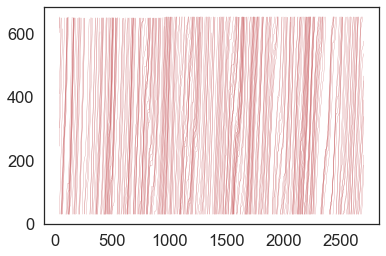

In [23]:
dfplot = df
for i in selected_id_list:
    toplot = dfplot[dfplot['new_id'] == i]
    plt.plot( toplot['t_diff'], toplot['local_y'], linewidth = 0.2, color = 'r' )

In [24]:
t_data = np.arange(min(df['t_diff']), max(df['t_diff']), 0.1)
t_data

array([  42.1,   42.2,   42.3, ..., 2697.1, 2697.2, 2697.3])

In [25]:
# h_at
def h_at_traj(x, rho_idx, u_idx):
    N = int(round(len(x)/2))
    result_rho = [x[i] for i in rho_idx]
    result_u = [x[N+i] for i in u_idx]
    return np.array(result_rho + result_u)

def Hjacobian_traj(x, N, rho_idx, u_idx):
    # N is actually the length of x
    H_jacobian = np.zeros( (len(rho_idx)+len(u_idx),N) )
    for i in range(len(rho_idx)):
        H_jacobian[i, rho_idx[i]] = 1
        
    for i in range(len(u_idx)):
        H_jacobian[i+len(rho_idx), u_idx[i]+int(round(N/2))] = 1
    return H_jacobian

In [26]:
def implement_kf_traj(loops, dim_z_1, dim_z_2, rho, u,  config, **f_kwargs):
    std_Q = config['std_Q']
    std_R = config['std_R']
    init_rho = config['init_rho']
    init_u = config['init_u']
    init_P = config['init_P']

    para = f_kwargs['para']
    qhu_grn_sld = QHU_Green_Shield_augDerivative(para)
    p_arz = Partial_ARZ( qhu_grn_sld, para)

    lwrefk = ARZEKF(2*len(rho[:,0]),dim_z_1, dim_z_2,std_Q, std_R)
    lwrefk.x = np.hstack([init_rho, init_u])
    N = len(lwrefk.x)
    lwrefk.P = init_P
    X_pri = [lwrefk.x]
    X_pos = [lwrefk.x]
    Obs = []
    K = []
    P = []
    previous_dt_idx = 1 # start with 1
    count = 0
    u_obs_idx  = set([])
    for i in t_data[1:]:
        i = round(i, 1)
        #print('i=%s'%i)

        current_dt_idx = df.loc[df['t_diff'] == i, 'dt_idx'].tolist()[0]

        if current_dt_idx == 0: # initial is given
            continue

        u_obs_idx = u_obs_idx | set(df_selected.loc[df_selected['t'] == i, 'dx_idx'].tolist()) 



        # for example, when the dt_idx = 1 is traversed and about to move to the dt_idx = 2,
        #  we then update the dt_idx = 1
        if (current_dt_idx != previous_dt_idx) | (i == round(t_data[-1],1)):
            u_obs_idx = list(sorted(u_obs_idx))
            rho_obs_idx = loops
            dim_z_1 = len(rho_obs_idx)
            dim_z_2 = len(u_obs_idx) 
            #print('dim_z_1 = %s, dim_z_2 = %s'%(dim_z_1, dim_z_2))
            #print('std_R[0]: %s, std_R[1]: %s'%(std_R[0],std_R[1]))
            A = np.eye(dim_z_1) * std_R[0]
            B = np.eye(dim_z_2) * std_R[1]
            lwrefk.R =  np.block([
                                    [A,               np.zeros((dim_z_1, dim_z_2))],
                                    [np.zeros((dim_z_2, dim_z_1)), B               ]
                                ])

            print('update, current idx: %s'%(current_dt_idx))
            print('update, to be observe: %s'%(len(X_pos)))
            lwrefk.predict(Fjacobian, f_at, p_arz = p_arz)
            X_pri.append(lwrefk.x_prior)


            previous_dt_idx = current_dt_idx
            observe = [rho[k, len(X_pos)] for k in rho_obs_idx] + [u[k, len(X_pos)] for k in u_obs_idx]
            Obs.append(len(u_obs_idx))
            print(u_obs_idx)
            lwrefk.update(observe, Hjacobian_traj, h_at_traj, args=(N, rho_obs_idx, u_obs_idx),hx_args=(rho_obs_idx, u_obs_idx))
            #lwrefk.x = neibour_avg(lwrefk.x)
            Rho = lwrefk.x[:21]
            Y = lwrefk.x[21:]
            Rho = [max(0.01, i) for i in Rho]
            Rho = [min(0.6, i) for i in Rho]
            Y = [max(-2, i) for i in Y]
            Y = [min(2, i) for i in Y]
            lwrefk.x = np.array(np.hstack([Rho,Y]))
            lwrefk.x_post = lwrefk.x

            K.append(lwrefk.K)
            P.append(lwrefk.P)
            X_pos.append(lwrefk.x_post)
            u_obs_idx = set([])

    X_pos = np.vstack(X_pos).T
    X_pri = np.vstack(X_pri).T

    return X_pri, X_pos, K, P, Obs

In [802]:
np.random.seed(43)


ReadRealPara = False
Errors_Rho = []
Errors_U = []
#para

OBS = []
for key in LOOPS.keys():
    loops = LOOPS[key]
    # para
    if ReadRealPara:
        #para = para_t30_s30
        pass
    else:
        
        PARA['rho_jam'] = para_dict[key]['rho_max']
        PARA['u_free'] = para_dict[key]['u_max']
        PARA['tau'] = para_dict[key]['tau']
    #loop
    print('====================================================')
    print(loops)
    qhu_grn_sld = QHU_Green_Shield_augDerivative(PARA)
    y = rho*(u - qhu_grn_sld.U(rho))
    config = {'std_Q':[.02,.02],
                  'std_R':[.3,.3],
                  'init_rho': np.ones(rho.shape[0])*0.1,
                  'init_u': np.ones(rho.shape[0])*0.5,
                  'init_P': np.eye(rho.shape[0]+u.shape[0])*0.02}
    X_pri, X_pos, K, P, Obs = implement_kf_traj(loops, len(loops), len(loops), rho, y,  config, 
                                dx=dx,
                                dt=dt,
                                para=PARA)
    Rho = X_pos[:21,:]
    Y = X_pos[21:,:]
    qhu_grn_sld = QHU_Green_Shield_augDerivative(PARA)
    U = Y/Rho +qhu_grn_sld.U(Rho)
    error_rho = np.linalg.norm(rho[:, :]-Rho ,2)/np.linalg.norm(rho[:, :],2)
    errors_u = np.linalg.norm(u[:, :]-U,2)/np.linalg.norm(u[:, :],2)
    Errors_Rho.append(error_rho)
    Errors_U.append(errors_u)
    OBS.append(Obs) # #(loops_keys) * #(dt_idx) * #(u_obs_idx)

[0, 7, 20]
update, current idx: 2
update, to be observe: 1
[0, 8, 10, 13, 14, 20]
update, current idx: 3
update, to be observe: 2
[0, 1, 8, 9, 11, 14]
update, current idx: 4
update, to be observe: 3
[1, 2, 9, 10, 11, 12, 14, 15]
update, current idx: 5
update, to be observe: 4
[2, 10, 12, 13, 15, 16]
update, current idx: 6
update, to be observe: 5
[2, 3, 10, 11, 13, 14, 16]
update, current idx: 7
update, to be observe: 6
[3, 4, 11, 14, 15, 17]
update, current idx: 8
update, to be observe: 7
[4, 11, 12, 15, 16, 17, 18]
update, current idx: 9
update, to be observe: 8
[4, 5, 12, 16, 17, 18, 19]
update, current idx: 10
update, to be observe: 9
[0, 5, 6, 12, 17, 18, 19, 20]
update, current idx: 11
update, to be observe: 10
[0, 6, 12, 13, 18, 19, 20]
update, current idx: 12
update, to be observe: 11
[1, 6, 7, 13, 14, 19, 20]
update, current idx: 13
update, to be observe: 12
[0, 1, 2, 7, 8, 14, 20]
update, current idx: 14
update, to be observe: 13
[0, 2, 8, 9, 14, 15]
update, current idx: 15
u

update, current idx: 108
update, to be observe: 107
[5, 6, 7, 8, 11, 12, 13, 15, 16]
update, current idx: 109
update, to be observe: 108
[6, 8, 9, 12, 13, 14, 16, 17]
update, current idx: 110
update, to be observe: 109
[6, 7, 9, 13, 14, 15, 17, 18]
update, current idx: 111
update, to be observe: 110
[7, 8, 9, 10, 13, 14, 15, 18, 19]
update, current idx: 112
update, to be observe: 111
[8, 9, 10, 11, 14, 15, 16, 19, 20]
update, current idx: 113
update, to be observe: 112
[0, 9, 11, 15, 16, 17, 20]
update, current idx: 114
update, to be observe: 113
[0, 9, 10, 11, 12, 16, 17, 18]
update, current idx: 115
update, to be observe: 114
[0, 1, 10, 12, 13, 17, 18, 19]
update, current idx: 116
update, to be observe: 115
[1, 10, 11, 13, 18, 19, 20]
update, current idx: 117
update, to be observe: 116
[1, 2, 11, 13, 14, 19, 20]
update, current idx: 118
update, to be observe: 117
[0, 2, 11, 12, 14, 15, 20]
update, current idx: 119
update, to be observe: 118
[0, 1, 2, 3, 12, 13, 15, 16]
update, curren

update, current idx: 220
update, to be observe: 219
[0, 1, 2, 3, 4, 7, 10, 18, 19, 20]
update, current idx: 221
update, to be observe: 220
[1, 2, 4, 7, 8, 10, 11, 19, 20]
update, current idx: 222
update, to be observe: 221
[0, 1, 2, 3, 4, 5, 8, 11, 20]
update, current idx: 223
update, to be observe: 222
[0, 2, 3, 5, 8, 9, 11, 12]
update, current idx: 224
update, to be observe: 223
[0, 1, 2, 3, 4, 5, 6, 9, 12, 13]
update, current idx: 225
update, to be observe: 224
[0, 1, 3, 4, 5, 6, 9, 10, 13]
update, current idx: 226
update, to be observe: 225
[0, 1, 2, 3, 4, 5, 6, 10, 11, 13, 14]
update, current idx: 227
update, to be observe: 226
[1, 2, 3, 4, 5, 6, 7, 11, 14, 15]
update, current idx: 228
update, to be observe: 227
[1, 2, 3, 4, 5, 6, 7, 11, 12, 15, 16]
update, current idx: 229
update, to be observe: 228
[2, 4, 5, 7, 12, 13, 16, 17]
update, current idx: 230
update, to be observe: 229
[2, 3, 4, 5, 6, 7, 8, 13, 17, 18]
update, current idx: 231
update, to be observe: 230
[3, 4, 5, 6, 8, 

update, current idx: 313
update, to be observe: 312
[0, 2, 3, 4, 5, 6, 7, 8, 9, 16, 17, 18, 19, 20]
update, current idx: 314
update, to be observe: 313
[0, 3, 5, 6, 7, 8, 9, 17, 18, 19, 20]
update, current idx: 315
update, to be observe: 314
[0, 3, 4, 5, 6, 7, 8, 9, 10, 18, 19, 20]
update, current idx: 316
update, to be observe: 315
[0, 4, 5, 6, 7, 9, 10, 19, 20]
update, current idx: 317
update, to be observe: 316
[0, 1, 5, 6, 7, 8, 10, 11, 20]
update, current idx: 318
update, to be observe: 317
[1, 6, 7, 8, 9, 10, 11, 12]
update, current idx: 319
update, to be observe: 318
[1, 6, 7, 8, 9, 11, 12]
update, current idx: 320
update, to be observe: 319
[1, 7, 8, 9, 10, 12, 13]
update, current idx: 321
update, to be observe: 320
[1, 2, 8, 9, 10, 11, 12, 13, 14]
update, current idx: 322
update, to be observe: 321
[2, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 323
update, to be observe: 322
[2, 3, 9, 10, 12, 13, 14, 15, 16]
update, current idx: 324
update, to be observe: 323
[3, 10, 11, 

update, current idx: 413
update, to be observe: 412
[0, 2, 4, 6, 7, 8, 9, 10, 14, 15, 16]
update, current idx: 414
update, to be observe: 413
[0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 15, 16, 17]
update, current idx: 415
update, to be observe: 414
[0, 1, 3, 5, 8, 9, 10, 11, 12, 15, 16, 17]
update, current idx: 416
update, to be observe: 415
[1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 417
update, to be observe: 416
[1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 418
update, to be observe: 417
[2, 4, 7, 10, 11, 12, 13, 14, 18, 19]
update, current idx: 419
update, to be observe: 418
[2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 18, 19, 20]
update, current idx: 420
update, to be observe: 419
[3, 5, 8, 9, 11, 12, 13, 14, 15, 16, 19, 20]
update, current idx: 421
update, to be observe: 420
[3, 4, 5, 6, 9, 12, 13, 14, 15, 16, 19, 20]
update, current idx: 422
update, to be observe: 421
[4, 5, 6, 7, 10, 13, 14, 15, 16, 17, 20]
update, current idx: 423
update, to be obs

update, current idx: 506
update, to be observe: 505
[4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 18]
update, current idx: 507
update, to be observe: 506
[0, 4, 5, 6, 7, 8, 10, 13, 14, 15, 18]
update, current idx: 508
update, to be observe: 507
[0, 5, 6, 7, 8, 9, 10, 11, 13, 15, 18, 19]
update, current idx: 509
update, to be observe: 508
[0, 1, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 19]
update, current idx: 510
update, to be observe: 509
[0, 1, 6, 7, 8, 9, 11, 13, 14, 15, 16, 19]
update, current idx: 511
update, to be observe: 510
[0, 1, 2, 6, 7, 9, 10, 11, 12, 13, 14, 16, 20]
update, current idx: 512
update, to be observe: 511
[0, 1, 2, 7, 8, 9, 10, 12, 13, 14, 16, 17, 20]
update, current idx: 513
update, to be observe: 512
[0, 1, 2, 7, 8, 10, 12, 13, 14, 16, 17, 20]
update, current idx: 514
update, to be observe: 513
[0, 1, 2, 3, 8, 10, 11, 12, 14, 17]
update, current idx: 515
update, to be observe: 514
[0, 1, 2, 3, 8, 9, 10, 11, 12, 14, 17, 18]
update, current idx: 516
update, to be observe: 5

update, current idx: 594
update, to be observe: 593
[0, 1, 2, 4, 5, 6, 7, 9, 12]
update, current idx: 595
update, to be observe: 594
[1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13]
update, current idx: 596
update, to be observe: 595
[1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14]
update, current idx: 597
update, to be observe: 596
[0, 2, 3, 5, 6, 7, 8, 10, 11, 14, 15]
update, current idx: 598
update, to be observe: 597
[0, 2, 3, 4, 5, 6, 8, 11, 15, 16]
update, current idx: 599
update, to be observe: 598
[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 16, 17]
update, current idx: 600
update, to be observe: 599
[0, 1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 17, 18]
update, current idx: 601
update, to be observe: 600
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 18, 19]
update, current idx: 602
update, to be observe: 601
[0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 19, 20]
update, current idx: 603
update, to be observe: 602
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 15, 20]
update, current idx: 604
update, to be observe: 603
[0, 1, 2, 3, 5, 6, 7, 8,

update, current idx: 681
update, to be observe: 680
[1, 5, 11, 12, 14, 15, 19, 20]
update, current idx: 682
update, to be observe: 681
[1, 2, 5, 6, 12, 15, 19, 20]
update, current idx: 683
update, to be observe: 682
[2, 6, 7, 12, 13, 16, 20]
update, current idx: 684
update, to be observe: 683
[2, 3, 6, 7, 13, 14, 16, 17, 20]
update, current idx: 685
update, to be observe: 684
[0, 3, 6, 7, 8, 14, 17, 20]
update, current idx: 686
update, to be observe: 685
[0, 3, 4, 7, 8, 14, 15, 17, 18]
update, current idx: 687
update, to be observe: 686
[0, 1, 4, 7, 8, 9, 15, 18]
update, current idx: 688
update, to be observe: 687
[1, 2, 4, 5, 7, 9, 10, 15, 18]
update, current idx: 689
update, to be observe: 688
[2, 5, 7, 8, 10, 16, 18, 19]
update, current idx: 690
update, to be observe: 689
[0, 2, 3, 5, 6, 8, 11, 16, 19]
update, current idx: 691
update, to be observe: 690
[0, 1, 3, 6, 8, 11, 12, 16, 17, 19]
update, current idx: 692
update, to be observe: 691
[1, 3, 4, 6, 7, 8, 9, 12, 17, 19]
update, c

update, current idx: 771
update, to be observe: 770
[0, 1, 2, 3, 4, 5, 6, 9, 11, 13, 15, 16, 17, 18, 19]
update, current idx: 772
update, to be observe: 771
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 15, 17, 18, 19, 20]
update, current idx: 773
update, to be observe: 772
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15, 17, 18, 19, 20]
update, current idx: 774
update, to be observe: 773
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 775
update, to be observe: 774
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16, 18, 19, 20]
update, current idx: 776
update, to be observe: 775
[0, 1, 3, 4, 5, 6, 7, 8, 11, 15, 16, 17, 18, 19, 20]
update, current idx: 777
update, to be observe: 776
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16, 17, 18, 19, 20]
update, current idx: 778
update, to be observe: 777
[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 16, 17, 19, 20]
update, current idx: 779
update, to be observe: 778
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 16, 17, 18, 19, 20]
update, current id

update, current idx: 858
update, to be observe: 857
[2, 5, 11, 12, 13, 16, 17, 19, 20]
update, current idx: 859
update, to be observe: 858
[2, 3, 5, 6, 11, 12, 13, 17, 18, 20]
update, current idx: 860
update, to be observe: 859
[0, 3, 6, 12, 13, 14, 18, 19]
update, current idx: 861
update, to be observe: 860
[0, 3, 4, 6, 7, 13, 14, 15, 19]
update, current idx: 862
update, to be observe: 861
[0, 1, 4, 7, 14, 15, 16, 19, 20]
update, current idx: 863
update, to be observe: 862
[1, 4, 5, 8, 14, 15, 16, 20]
update, current idx: 864
update, to be observe: 863
[0, 1, 5, 8, 9, 15, 16, 17]
update, current idx: 865
update, to be observe: 864
[0, 1, 2, 5, 6, 9, 15, 16, 17, 18]
update, current idx: 866
update, to be observe: 865
[0, 1, 2, 6, 7, 9, 10, 16, 17, 18]
update, current idx: 867
update, to be observe: 866
[1, 2, 3, 7, 10, 11, 16, 17, 18, 19]
update, current idx: 868
update, to be observe: 867
[1, 2, 3, 7, 8, 11, 17, 18, 19, 20]
update, current idx: 869
update, to be observe: 868
[2, 3, 4,

update, current idx: 955
update, to be observe: 954
[0, 1, 2, 3, 7, 8, 9, 10, 14, 15, 18, 19, 20]
update, current idx: 956
update, to be observe: 955
[0, 1, 2, 3, 4, 8, 9, 10, 15, 16, 19, 20]
update, current idx: 957
update, to be observe: 956
[1, 2, 3, 4, 9, 10, 16, 19, 20]
update, current idx: 958
update, to be observe: 957
[1, 2, 3, 5, 9, 10, 16, 17, 20]
update, current idx: 959
update, to be observe: 958
[2, 3, 4, 5, 6, 9, 10, 11, 17]
update, current idx: 960
update, to be observe: 959
[2, 3, 4, 6, 7, 9, 11, 18]
update, current idx: 961
update, to be observe: 960
[3, 4, 5, 7, 9, 11, 12, 18]
update, current idx: 962
update, to be observe: 961
[0, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 18, 19]
update, current idx: 963
update, to be observe: 962
[0, 4, 5, 8, 9, 10, 12, 13, 19]
update, current idx: 964
update, to be observe: 963
[0, 1, 4, 5, 6, 9, 10, 13, 14, 19]
update, current idx: 965
update, to be observe: 964
[1, 4, 5, 6, 9, 10, 11, 13, 14, 15, 19]
update, current idx: 966
update, to b

update, current idx: 1040
update, to be observe: 1039
[1, 3, 6, 7, 8, 9, 11, 12, 17, 18, 19]
update, current idx: 1041
update, to be observe: 1040
[1, 3, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19]
update, current idx: 1042
update, to be observe: 1041
[1, 2, 3, 6, 7, 8, 9, 10, 12, 13, 18, 19, 20]
update, current idx: 1043
update, to be observe: 1042
[1, 2, 3, 6, 7, 8, 9, 10, 12, 13, 18, 19, 20]
update, current idx: 1044
update, to be observe: 1043
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 19, 20]
update, current idx: 1045
update, to be observe: 1044
[1, 2, 4, 6, 7, 8, 10, 11, 13, 14, 19, 20]
update, current idx: 1046
update, to be observe: 1045
[2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 20]
update, current idx: 1047
update, to be observe: 1046
[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20]
update, current idx: 1048
update, to be observe: 1047
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 1049
update, to be observe: 1048
[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
update, current

update, current idx: 1124
update, to be observe: 1123
[1, 3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1125
update, to be observe: 1124
[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1126
update, to be observe: 1125
[2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1127
update, to be observe: 1126
[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1128
update, to be observe: 1127
[3, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1129
update, to be observe: 1128
[4, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20]
update, current idx: 1130
update, to be observe: 1129
[4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1131
update, to be observe: 1130
[0, 5, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20]
update, current idx: 1132
update, to be observe: 1131
[0, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]
upd

update, current idx: 1209
update, to be observe: 1208
[1, 4, 5, 7, 11, 13, 14, 16, 18, 20]
update, current idx: 1210
update, to be observe: 1209
[0, 1, 4, 5, 6, 7, 8, 11, 12, 13, 14, 16, 18, 19, 20]
update, current idx: 1211
update, to be observe: 1210
[0, 1, 2, 5, 6, 8, 12, 13, 14, 15, 16, 17, 19, 20]
update, current idx: 1212
update, to be observe: 1211
[0, 1, 2, 5, 6, 7, 8, 9, 13, 14, 15, 17, 19, 20]
update, current idx: 1213
update, to be observe: 1212
[0, 1, 2, 3, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 20]
update, current idx: 1214
update, to be observe: 1213
[0, 1, 2, 3, 6, 7, 8, 10, 14, 15, 16, 18]
update, current idx: 1215
update, to be observe: 1214
[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18]
update, current idx: 1216
update, to be observe: 1215
[0, 1, 2, 3, 4, 7, 8, 9, 11, 15, 16, 17, 19]
update, current idx: 1217
update, to be observe: 1216
[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 17, 19]
update, current idx: 1218
update, to be observe: 1217
[1, 2, 3, 4, 5, 8, 9, 10,

update, current idx: 1303
update, to be observe: 1302
[0, 1, 2, 3, 7, 8, 11, 12, 16, 17]
update, current idx: 1304
update, to be observe: 1303
[0, 1, 2, 3, 4, 7, 8, 9, 12, 17, 18]
update, current idx: 1305
update, to be observe: 1304
[0, 1, 2, 3, 4, 8, 9, 12, 13, 17, 18, 19]
update, current idx: 1306
update, to be observe: 1305
[0, 1, 2, 3, 4, 8, 9, 10, 13, 18, 19, 20]
update, current idx: 1307
update, to be observe: 1306
[1, 2, 3, 4, 8, 9, 10, 13, 14, 19, 20]
update, current idx: 1308
update, to be observe: 1307
[0, 1, 2, 3, 4, 9, 10, 11, 14, 19, 20]
update, current idx: 1309
update, to be observe: 1308
[0, 1, 2, 3, 4, 9, 10, 11, 12, 14, 15, 20]
update, current idx: 1310
update, to be observe: 1309
[0, 1, 2, 3, 4, 10, 12, 15, 16]
update, current idx: 1311
update, to be observe: 1310
[0, 1, 2, 3, 4, 10, 11, 12, 13, 16]
update, current idx: 1312
update, to be observe: 1311
[0, 2, 3, 4, 11, 13, 16, 17]
update, current idx: 1313
update, to be observe: 1312
[0, 2, 3, 4, 11, 12, 13, 14, 17,

update, current idx: 1395
update, to be observe: 1394
[0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 14, 15, 16, 18, 19]
update, current idx: 1396
update, to be observe: 1395
[0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 15, 16, 17, 18, 19]
update, current idx: 1397
update, to be observe: 1396
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 15, 17, 19, 20]
update, current idx: 1398
update, to be observe: 1397
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 1399
update, to be observe: 1398
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 16, 18, 19, 20]
update, current idx: 1400
update, to be observe: 1399
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20]
update, current idx: 1401
update, to be observe: 1400
[1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 17, 19, 20]
update, current idx: 1402
update, to be observe: 1401
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 15, 17, 18, 19]
update, current idx: 1403
update, to be observe: 1402
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 15, 16, 18, 19, 20]
updat

update, current idx: 1474
update, to be observe: 1473
[0, 3, 4, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20]
update, current idx: 1475
update, to be observe: 1474
[0, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20]
update, current idx: 1476
update, to be observe: 1475
[0, 1, 4, 5, 7, 8, 9, 10, 16, 17, 18, 19, 20]
update, current idx: 1477
update, to be observe: 1476
[0, 1, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20]
update, current idx: 1478
update, to be observe: 1477
[0, 1, 2, 5, 6, 8, 9, 10, 11, 17, 18, 19, 20]
update, current idx: 1479
update, to be observe: 1478
[1, 2, 6, 7, 8, 9, 10, 11, 17, 18, 20]
update, current idx: 1480
update, to be observe: 1479
[1, 2, 3, 6, 7, 9, 10, 11, 12, 18, 19, 20]
update, current idx: 1481
update, to be observe: 1480
[2, 3, 7, 8, 9, 10, 12, 13, 18, 19, 20]
update, current idx: 1482
update, to be observe: 1481
[2, 3, 4, 7, 8, 10, 11, 12, 13, 19]
update, current idx: 1483
update, to be observe: 1482
[0, 3, 4, 5, 8, 9, 10, 11, 13, 19, 20]
update, current idx: 1484
update,

update, current idx: 1570
update, to be observe: 1569
[6, 8, 10, 11, 12, 13]
update, current idx: 1571
update, to be observe: 1570
[0, 6, 8, 9, 10, 11, 12, 13, 14]
update, current idx: 1572
update, to be observe: 1571
[0, 6, 7, 9, 11, 12, 14]
update, current idx: 1573
update, to be observe: 1572
[0, 7, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 1574
update, to be observe: 1573
[0, 7, 8, 10, 12, 13, 14, 15]
update, current idx: 1575
update, to be observe: 1574
[0, 8, 10, 11, 12, 13, 14, 15, 16]
update, current idx: 1576
update, to be observe: 1575
[0, 8, 11, 13, 14, 15, 16, 17]
update, current idx: 1577
update, to be observe: 1576
[0, 1, 8, 9, 11, 12, 14, 15, 17]
update, current idx: 1578
update, to be observe: 1577
[0, 1, 9, 12, 14, 15, 16, 17, 18]
update, current idx: 1579
update, to be observe: 1578
[0, 1, 9, 12, 13, 15, 16, 18]
update, current idx: 1580
update, to be observe: 1579
[0, 1, 9, 10, 13, 16, 17, 18]
update, current idx: 1581
update, to be observe: 1580
[0, 1, 10, 13,

update, current idx: 1667
update, to be observe: 1666
[1, 5, 7, 8, 10, 11, 15, 19, 20]
update, current idx: 1668
update, to be observe: 1667
[1, 2, 5, 7, 8, 9, 11, 15, 16, 20]
update, current idx: 1669
update, to be observe: 1668
[0, 1, 2, 5, 6, 7, 8, 9, 11, 12, 16]
update, current idx: 1670
update, to be observe: 1669
[0, 2, 6, 8, 9, 10, 12, 13, 16, 17]
update, current idx: 1671
update, to be observe: 1670
[0, 2, 3, 6, 7, 8, 10, 13, 17, 18]
update, current idx: 1672
update, to be observe: 1671
[0, 2, 3, 7, 8, 9, 10, 11, 13, 14, 18]
update, current idx: 1673
update, to be observe: 1672
[0, 3, 7, 8, 9, 10, 11, 14, 18, 19]
update, current idx: 1674
update, to be observe: 1673
[0, 3, 4, 8, 10, 11, 12, 14, 15, 19]
update, current idx: 1675
update, to be observe: 1674
[0, 3, 4, 8, 9, 10, 11, 12, 13, 15, 16, 19, 20]
update, current idx: 1676
update, to be observe: 1675
[1, 4, 5, 9, 11, 13, 16, 20]
update, current idx: 1677
update, to be observe: 1676
[0, 1, 4, 5, 9, 10, 11, 12, 13, 14, 16, 1

update, current idx: 1756
update, to be observe: 1755
[1, 4, 5, 7, 8, 12, 13, 16, 19, 20]
update, current idx: 1757
update, to be observe: 1756
[1, 4, 5, 7, 8, 9, 13, 14, 16, 17, 20]
update, current idx: 1758
update, to be observe: 1757
[1, 2, 5, 8, 9, 14, 17, 20]
update, current idx: 1759
update, to be observe: 1758
[0, 2, 5, 6, 8, 9, 10, 14, 17, 20]
update, current idx: 1760
update, to be observe: 1759
[0, 2, 3, 5, 6, 8, 9, 10, 14, 15, 17, 20]
update, current idx: 1761
update, to be observe: 1760
[0, 1, 3, 6, 9, 10, 11, 15, 17, 20]
update, current idx: 1762
update, to be observe: 1761
[1, 3, 6, 7, 9, 10, 11, 15, 17, 20]
update, current idx: 1763
update, to be observe: 1762
[1, 3, 4, 6, 7, 10, 11, 12, 15, 16, 17, 20]
update, current idx: 1764
update, to be observe: 1763
[1, 2, 4, 7, 8, 10, 11, 12, 16, 17, 20]
update, current idx: 1765
update, to be observe: 1764
[2, 4, 7, 8, 9, 11, 12, 16, 17, 20]
update, current idx: 1766
update, to be observe: 1765
[2, 4, 7, 8, 9, 11, 12, 13, 16, 17

update, current idx: 90
update, to be observe: 89
[0, 2, 3, 8, 14, 15]
update, current idx: 91
update, to be observe: 90
[0, 1, 3, 8, 9, 15, 16]
update, current idx: 92
update, to be observe: 91
[0, 1, 3, 4, 9, 10, 16, 17]
update, current idx: 93
update, to be observe: 92
[1, 2, 4, 10, 17, 18]
update, current idx: 94
update, to be observe: 93
[1, 2, 3, 4, 5, 10, 11, 18, 19]
update, current idx: 95
update, to be observe: 94
[2, 3, 5, 6, 11, 12, 19, 20]
update, current idx: 96
update, to be observe: 95
[0, 3, 4, 6, 12, 13, 20]
update, current idx: 97
update, to be observe: 96
[0, 3, 4, 6, 7, 13]
update, current idx: 98
update, to be observe: 97
[0, 1, 4, 5, 7, 13, 14]
update, current idx: 99
update, to be observe: 98
[1, 2, 4, 5, 6, 7, 8, 14, 15]
update, current idx: 100
update, to be observe: 99
[0, 2, 5, 6, 7, 8, 9, 15, 16]
update, current idx: 101
update, to be observe: 100
[0, 1, 2, 3, 6, 7, 9, 10, 16, 17]
update, current idx: 102
update, to be observe: 101
[1, 3, 4, 6, 7, 8, 10, 17]

update, current idx: 203
update, to be observe: 202
[1, 2, 6, 7, 8, 13, 14, 15]
update, current idx: 204
update, to be observe: 203
[2, 7, 8, 14, 15, 16]
update, current idx: 205
update, to be observe: 204
[3, 7, 8, 9, 15, 16]
update, current idx: 206
update, to be observe: 205
[3, 8, 9, 10, 15, 16, 17]
update, current idx: 207
update, to be observe: 206
[3, 4, 9, 10, 16, 17, 18]
update, current idx: 208
update, to be observe: 207
[0, 4, 9, 10, 11, 17, 18, 19]
update, current idx: 209
update, to be observe: 208
[0, 5, 10, 11, 18, 19, 20]
update, current idx: 210
update, to be observe: 209
[0, 1, 5, 6, 11, 12, 18, 19, 20]
update, current idx: 211
update, to be observe: 210
[1, 6, 11, 12, 13, 19, 20]
update, current idx: 212
update, to be observe: 211
[1, 2, 6, 7, 12, 13, 20]
update, current idx: 213
update, to be observe: 212
[0, 2, 3, 7, 12, 13, 14]
update, current idx: 214
update, to be observe: 213
[0, 3, 7, 8, 13, 14, 15]
update, current idx: 215
update, to be observe: 214
[0, 1, 3,

update, current idx: 298
update, to be observe: 297
[2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16]
update, current idx: 299
update, to be observe: 298
[2, 3, 5, 6, 8, 9, 10, 11, 12, 16, 17]
update, current idx: 300
update, to be observe: 299
[0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 301
update, to be observe: 300
[0, 3, 5, 7, 9, 10, 11, 12, 13, 18, 19]
update, current idx: 302
update, to be observe: 301
[0, 1, 3, 5, 7, 8, 10, 11, 12, 13, 14, 19, 20]
update, current idx: 303
update, to be observe: 302
[1, 3, 5, 8, 9, 10, 11, 12, 13, 14, 15, 20]
update, current idx: 304
update, to be observe: 303
[0, 1, 2, 3, 5, 9, 11, 12, 13, 14, 15, 16]
update, current idx: 305
update, to be observe: 304
[0, 2, 3, 5, 9, 10, 12, 13, 14, 15, 16, 17]
update, current idx: 306
update, to be observe: 305
[0, 1, 2, 3, 5, 6, 10, 11, 12, 13, 14, 16, 17, 18]
update, current idx: 307
update, to be observe: 306
[0, 1, 2, 3, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 308
upda

update, current idx: 396
update, to be observe: 395
[0, 1, 2, 4, 5, 10, 11, 13, 14, 17, 18, 20]
update, current idx: 397
update, to be observe: 396
[0, 1, 2, 4, 5, 11, 14, 15, 18, 19, 20]
update, current idx: 398
update, to be observe: 397
[0, 1, 2, 5, 6, 12, 15, 16, 19]
update, current idx: 399
update, to be observe: 398
[0, 1, 2, 5, 6, 12, 13, 16, 19, 20]
update, current idx: 400
update, to be observe: 399
[0, 1, 2, 3, 6, 7, 13, 14, 16, 17, 20]
update, current idx: 401
update, to be observe: 400
[0, 1, 2, 3, 6, 7, 8, 14, 15, 17, 18, 20]
update, current idx: 402
update, to be observe: 401
[0, 1, 2, 3, 4, 7, 8, 15, 18, 19]
update, current idx: 403
update, to be observe: 402
[0, 1, 2, 3, 4, 8, 9, 15, 16, 19]
update, current idx: 404
update, to be observe: 403
[0, 1, 2, 3, 4, 5, 8, 9, 10, 16, 17, 19, 20]
update, current idx: 405
update, to be observe: 404
[1, 2, 3, 4, 5, 9, 10, 11, 17, 20]
update, current idx: 406
update, to be observe: 405
[1, 3, 4, 5, 6, 10, 11, 17, 18]
update, current

update, current idx: 490
update, to be observe: 489
[0, 1, 2, 3, 4, 7, 8, 13, 16, 17, 18]
update, current idx: 491
update, to be observe: 490
[0, 2, 4, 5, 7, 8, 9, 13, 14, 16, 18]
update, current idx: 492
update, to be observe: 491
[0, 2, 3, 5, 8, 9, 14, 16, 18]
update, current idx: 493
update, to be observe: 492
[0, 1, 3, 5, 6, 8, 9, 10, 14, 15, 16, 18, 19]
update, current idx: 494
update, to be observe: 493
[0, 1, 3, 4, 6, 8, 9, 10, 15, 16, 19]
update, current idx: 495
update, to be observe: 494
[0, 1, 2, 4, 6, 7, 9, 10, 11, 15, 16, 19]
update, current idx: 496
update, to be observe: 495
[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, 19]
update, current idx: 497
update, to be observe: 496
[0, 1, 2, 3, 5, 6, 8, 10, 11, 12, 15, 17, 19]
update, current idx: 498
update, to be observe: 497
[0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 17, 19, 20]
update, current idx: 499
update, to be observe: 498
[1, 2, 3, 4, 6, 7, 9, 11, 12, 13, 15, 17, 20]
update, current idx: 500
update, to be observ

update, current idx: 578
update, to be observe: 577
[0, 2, 5, 6, 11, 12, 14, 15, 17, 18, 19, 20]
update, current idx: 579
update, to be observe: 578
[0, 2, 3, 6, 11, 12, 15, 16, 18, 19, 20]
update, current idx: 580
update, to be observe: 579
[0, 1, 3, 6, 7, 12, 13, 16, 18, 19, 20]
update, current idx: 581
update, to be observe: 580
[0, 1, 3, 4, 7, 12, 13, 14, 17, 19, 20]
update, current idx: 582
update, to be observe: 581
[0, 1, 4, 7, 13, 14, 17, 18, 20]
update, current idx: 583
update, to be observe: 582
[0, 1, 2, 4, 5, 7, 8, 13, 14, 15, 18, 19]
update, current idx: 584
update, to be observe: 583
[0, 1, 2, 5, 8, 14, 15, 16, 19, 20]
update, current idx: 585
update, to be observe: 584
[0, 1, 2, 3, 6, 8, 15, 16, 17, 20]
update, current idx: 586
update, to be observe: 585
[0, 1, 2, 3, 4, 6, 8, 16, 17]
update, current idx: 587
update, to be observe: 586
[0, 1, 2, 3, 4, 6, 7, 8, 9, 16, 17, 18]
update, current idx: 588
update, to be observe: 587
[1, 2, 3, 4, 5, 7, 9, 17, 18, 19]
update, curr

update, current idx: 665
update, to be observe: 664
[1, 2, 7, 8, 11, 12, 13, 14, 18, 19]
update, current idx: 666
update, to be observe: 665
[2, 8, 9, 12, 13, 14, 15, 19]
update, current idx: 667
update, to be observe: 666
[3, 9, 10, 12, 13, 14, 15, 16, 19, 20]
update, current idx: 668
update, to be observe: 667
[3, 4, 9, 10, 11, 13, 15, 16, 20]
update, current idx: 669
update, to be observe: 668
[4, 10, 11, 13, 14, 15, 16, 17]
update, current idx: 670
update, to be observe: 669
[4, 5, 11, 12, 14, 15, 16, 17, 18]
update, current idx: 671
update, to be observe: 670
[5, 6, 11, 12, 13, 15, 16, 17, 18]
update, current idx: 672
update, to be observe: 671
[0, 6, 11, 13, 15, 16, 17, 18, 19]
update, current idx: 673
update, to be observe: 672
[0, 6, 7, 11, 13, 14, 16, 17, 18, 19]
update, current idx: 674
update, to be observe: 673
[0, 1, 7, 8, 11, 12, 14, 15, 17, 18, 19, 20]
update, current idx: 675
update, to be observe: 674
[1, 2, 8, 12, 15, 17, 18, 19, 20]
update, current idx: 676
update, t

update, current idx: 758
update, to be observe: 757
[1, 4, 5, 7, 8, 13, 14, 15, 16, 18, 19, 20]
update, current idx: 759
update, to be observe: 758
[1, 2, 4, 5, 8, 13, 14, 15, 16, 18, 20]
update, current idx: 760
update, to be observe: 759
[1, 2, 5, 6, 8, 14, 15, 16, 18, 20]
update, current idx: 761
update, to be observe: 760
[1, 2, 5, 6, 8, 9, 14, 15, 16, 17, 18, 20]
update, current idx: 762
update, to be observe: 761
[0, 1, 2, 3, 5, 6, 7, 9, 14, 15, 16, 17, 18, 20]
update, current idx: 763
update, to be observe: 762
[0, 1, 2, 3, 5, 6, 7, 9, 10, 14, 15, 16, 17, 18]
update, current idx: 764
update, to be observe: 763
[0, 1, 2, 3, 6, 7, 8, 10, 14, 15, 16, 17, 18, 19]
update, current idx: 765
update, to be observe: 764
[0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 15, 16, 17, 19]
update, current idx: 766
update, to be observe: 765
[0, 1, 2, 3, 4, 7, 8, 9, 11, 14, 15, 16, 17, 19]
update, current idx: 767
update, to be observe: 766
[0, 1, 2, 3, 4, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
update, 

update, current idx: 843
update, to be observe: 842
[1, 2, 3, 4, 7, 8, 9, 10, 12, 16, 17]
update, current idx: 844
update, to be observe: 843
[2, 3, 4, 5, 8, 10, 12, 13, 17, 18]
update, current idx: 845
update, to be observe: 844
[2, 3, 4, 5, 8, 9, 11, 13, 14, 18, 19]
update, current idx: 846
update, to be observe: 845
[0, 3, 4, 5, 9, 11, 12, 14, 15, 19]
update, current idx: 847
update, to be observe: 846
[0, 3, 4, 5, 6, 9, 10, 12, 15, 19, 20]
update, current idx: 848
update, to be observe: 847
[0, 4, 5, 6, 10, 11, 12, 13, 15, 16, 20]
update, current idx: 849
update, to be observe: 848
[0, 1, 4, 5, 6, 7, 11, 13, 14, 16, 17]
update, current idx: 850
update, to be observe: 849
[1, 5, 6, 7, 8, 11, 12, 14, 17]
update, current idx: 851
update, to be observe: 850
[1, 2, 6, 7, 8, 12, 14, 15, 17, 18]
update, current idx: 852
update, to be observe: 851
[0, 2, 6, 7, 8, 12, 13, 15, 16, 18, 19]
update, current idx: 853
update, to be observe: 852
[0, 2, 3, 7, 8, 9, 13, 14, 16, 19, 20]
update, curre

update, current idx: 941
update, to be observe: 940
[0, 1, 3, 4, 6, 7, 8, 10, 11, 14, 15, 18, 19, 20]
update, current idx: 942
update, to be observe: 941
[0, 1, 2, 4, 7, 8, 11, 12, 15, 19]
update, current idx: 943
update, to be observe: 942
[0, 2, 4, 5, 7, 8, 9, 12, 15, 16, 19, 20]
update, current idx: 944
update, to be observe: 943
[0, 1, 2, 3, 5, 8, 9, 10, 12, 13, 16, 20]
update, current idx: 945
update, to be observe: 944
[1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 20]
update, current idx: 946
update, to be observe: 945
[1, 2, 4, 6, 9, 11, 14, 15, 17, 18]
update, current idx: 947
update, to be observe: 946
[2, 4, 5, 6, 7, 9, 10, 12, 15, 18, 19]
update, current idx: 948
update, to be observe: 947
[2, 3, 5, 7, 10, 12, 13, 15, 16, 18, 19]
update, current idx: 949
update, to be observe: 948
[0, 3, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20]
update, current idx: 950
update, to be observe: 949
[0, 1, 3, 4, 6, 8, 11, 14, 15, 17, 19, 20]
update, current idx: 951
update, to be observe: 950
[1

update, current idx: 1026
update, to be observe: 1025
[2, 4, 5, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19, 20]
update, current idx: 1027
update, to be observe: 1026
[2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 18, 19]
update, current idx: 1028
update, to be observe: 1027
[3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1029
update, to be observe: 1028
[0, 3, 4, 5, 6, 8, 9, 10, 14, 15, 17, 18, 20]
update, current idx: 1030
update, to be observe: 1029
[0, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 17, 18, 19, 20]
update, current idx: 1031
update, to be observe: 1030
[0, 4, 5, 6, 7, 8, 9, 10, 14, 15, 18, 19]
update, current idx: 1032
update, to be observe: 1031
[0, 1, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 18, 19, 20]
update, current idx: 1033
update, to be observe: 1032
[0, 1, 4, 5, 6, 7, 8, 9, 10, 15, 16, 18, 19, 20]
update, current idx: 1034
update, to be observe: 1033
[0, 1, 4, 5, 6, 7, 8, 9, 10, 15, 16, 19, 20]
update, current idx: 1035
update, to be observe: 1034
[0, 1, 5, 6, 7

update, current idx: 1112
update, to be observe: 1111
[0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 20]
update, current idx: 1113
update, to be observe: 1112
[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18]
update, current idx: 1114
update, to be observe: 1113
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19]
update, current idx: 1115
update, to be observe: 1114
[0, 1, 2, 3, 5, 8, 9, 10, 11, 12, 13, 14, 15, 19]
update, current idx: 1116
update, to be observe: 1115
[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20]
update, current idx: 1117
update, to be observe: 1116
[0, 1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]
update, current idx: 1118
update, to be observe: 1117
[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 1119
update, to be observe: 1118
[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
update, current idx: 1120
update, to be observe: 1119
[1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, c

update, current idx: 1195
update, to be observe: 1194
[0, 3, 4, 5, 6, 8, 9, 10, 13, 14, 15, 16]
update, current idx: 1196
update, to be observe: 1195
[0, 1, 4, 6, 7, 9, 10, 11, 14, 15, 16, 17]
update, current idx: 1197
update, to be observe: 1196
[0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17]
update, current idx: 1198
update, to be observe: 1197
[0, 1, 5, 7, 8, 10, 12, 15, 16, 17, 18]
update, current idx: 1199
update, to be observe: 1198
[0, 1, 2, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18]
update, current idx: 1200
update, to be observe: 1199
[0, 1, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
update, current idx: 1201
update, to be observe: 1200
[0, 1, 2, 3, 7, 9, 10, 12, 14, 16, 17, 18, 19]
update, current idx: 1202
update, to be observe: 1201
[0, 1, 2, 3, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20]
update, current idx: 1203
update, to be observe: 1202
[1, 2, 3, 4, 8, 10, 11, 13, 15, 17, 18, 19, 20]
update, current idx: 1204
update, to be observe: 1203
[1, 2, 3, 4, 8, 9, 10, 11, 

update, current idx: 1286
update, to be observe: 1285
[3, 4, 5, 6, 8, 10, 14, 15, 16]
update, current idx: 1287
update, to be observe: 1286
[0, 3, 4, 5, 6, 8, 10, 15, 16]
update, current idx: 1288
update, to be observe: 1287
[0, 4, 5, 6, 8, 10, 11, 15, 16, 17]
update, current idx: 1289
update, to be observe: 1288
[0, 4, 5, 6, 8, 10, 11, 16, 17]
update, current idx: 1290
update, to be observe: 1289
[0, 4, 5, 6, 8, 10, 11, 16, 17, 18]
update, current idx: 1291
update, to be observe: 1290
[0, 5, 6, 8, 10, 11, 12, 17, 18, 19]
update, current idx: 1292
update, to be observe: 1291
[0, 1, 5, 6, 8, 10, 12, 18, 19]
update, current idx: 1293
update, to be observe: 1292
[0, 1, 6, 8, 9, 10, 11, 12, 18, 19, 20]
update, current idx: 1294
update, to be observe: 1293
[0, 1, 6, 7, 9, 11, 12, 19, 20]
update, current idx: 1295
update, to be observe: 1294
[0, 1, 6, 7, 9, 12, 13, 20]
update, current idx: 1296
update, to be observe: 1295
[0, 1, 6, 7, 9, 12, 13, 20]
update, current idx: 1297
update, to be ob

update, current idx: 1379
update, to be observe: 1378
[0, 1, 2, 6, 7, 9, 10, 11, 12, 16, 17, 18]
update, current idx: 1380
update, to be observe: 1379
[1, 2, 3, 6, 7, 8, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 1381
update, to be observe: 1380
[1, 2, 3, 7, 8, 11, 12, 13, 17, 18]
update, current idx: 1382
update, to be observe: 1381
[2, 3, 4, 8, 9, 11, 12, 13, 17, 18]
update, current idx: 1383
update, to be observe: 1382
[2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 18]
update, current idx: 1384
update, to be observe: 1383
[0, 3, 5, 9, 10, 12, 13, 14, 18, 19]
update, current idx: 1385
update, to be observe: 1384
[0, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 19]
update, current idx: 1386
update, to be observe: 1385
[1, 4, 6, 10, 11, 13, 14, 15, 19, 20]
update, current idx: 1387
update, to be observe: 1386
[0, 1, 2, 4, 5, 6, 7, 11, 12, 13, 14, 15, 19, 20]
update, current idx: 1388
update, to be observe: 1387
[0, 2, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 20]
update, current idx: 1389
update, to be ob

update, current idx: 1459
update, to be observe: 1458
[0, 1, 2, 6, 7, 8, 9, 10, 11, 19, 20]
update, current idx: 1460
update, to be observe: 1459
[0, 1, 2, 7, 8, 9, 10, 11, 12, 19, 20]
update, current idx: 1461
update, to be observe: 1460
[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 19, 20]
update, current idx: 1462
update, to be observe: 1461
[0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 20]
update, current idx: 1463
update, to be observe: 1462
[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 20]
update, current idx: 1464
update, to be observe: 1463
[0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 20]
update, current idx: 1465
update, to be observe: 1464
[0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]
update, current idx: 1466
update, to be observe: 1465
[0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15]
update, current idx: 1467
update, to be observe: 1466
[0, 1, 2, 4, 5, 11, 12, 13, 14, 15, 16]
update, current idx: 1468
update, to be observe: 1467
[0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 1469
update, to be 

update, current idx: 1550
update, to be observe: 1549
[2, 3, 4, 5, 6, 20]
update, current idx: 1551
update, to be observe: 1550
[3, 4, 5, 6]
update, current idx: 1552
update, to be observe: 1551
[3, 5, 6, 7]
update, current idx: 1553
update, to be observe: 1552
[3, 5, 6, 7]
update, current idx: 1554
update, to be observe: 1553
[3, 5, 6, 7]
update, current idx: 1555
update, to be observe: 1554
[3, 4, 5, 6, 7]
update, current idx: 1556
update, to be observe: 1555
[4, 5, 6, 7]
update, current idx: 1557
update, to be observe: 1556
[4, 6, 7, 8]
update, current idx: 1558
update, to be observe: 1557
[4, 6, 7, 8]
update, current idx: 1559
update, to be observe: 1558
[4, 6, 7, 8]
update, current idx: 1560
update, to be observe: 1559
[4, 6, 7, 8]
update, current idx: 1561
update, to be observe: 1560
[4, 5, 6, 7, 8]
update, current idx: 1562
update, to be observe: 1561
[5, 6, 7, 8, 9]
update, current idx: 1563
update, to be observe: 1562
[5, 6, 8, 9]
update, current idx: 1564
update, to be observ

update, current idx: 1651
update, to be observe: 1650
[0, 2, 3, 4, 6, 7, 10, 13]
update, current idx: 1652
update, to be observe: 1651
[0, 2, 3, 4, 7, 10, 11, 13, 14]
update, current idx: 1653
update, to be observe: 1652
[0, 2, 3, 4, 7, 11, 14, 15]
update, current idx: 1654
update, to be observe: 1653
[0, 2, 3, 4, 5, 7, 8, 11, 12, 15]
update, current idx: 1655
update, to be observe: 1654
[0, 2, 3, 4, 5, 8, 12, 13, 15, 16]
update, current idx: 1656
update, to be observe: 1655
[0, 2, 3, 4, 5, 8, 9, 13, 16]
update, current idx: 1657
update, to be observe: 1656
[0, 3, 4, 5, 6, 9, 13, 14, 16, 17]
update, current idx: 1658
update, to be observe: 1657
[0, 3, 4, 5, 6, 9, 10, 14, 17]
update, current idx: 1659
update, to be observe: 1658
[0, 3, 4, 5, 6, 7, 10, 11, 14, 15, 17, 18]
update, current idx: 1660
update, to be observe: 1659
[0, 1, 3, 4, 5, 7, 11, 15, 16, 18, 19]
update, current idx: 1661
update, to be observe: 1660
[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 16, 19, 20]
update, current idx: 1662
u

update, current idx: 1739
update, to be observe: 1738
[1, 2, 4, 8, 9, 10, 12, 13, 14, 20]
update, current idx: 1740
update, to be observe: 1739
[1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14]
update, current idx: 1741
update, to be observe: 1740
[2, 5, 9, 11, 13, 14, 15]
update, current idx: 1742
update, to be observe: 1741
[0, 2, 3, 5, 6, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 1743
update, to be observe: 1742
[0, 3, 6, 10, 12, 14, 15, 16]
update, current idx: 1744
update, to be observe: 1743
[0, 3, 4, 6, 10, 11, 12, 13, 14, 15, 16]
update, current idx: 1745
update, to be observe: 1744
[0, 1, 3, 4, 6, 7, 11, 13, 15, 16, 17]
update, current idx: 1746
update, to be observe: 1745
[0, 1, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 1747
update, to be observe: 1746
[1, 4, 5, 7, 8, 12, 14, 15, 16, 17, 18]
update, current idx: 1748
update, to be observe: 1747
[1, 2, 4, 5, 6, 8, 12, 13, 15, 16, 17, 18]
update, current idx: 1749
update, to be observe: 1748
[2, 5, 6, 8, 9, 13, 16

update, current idx: 72
update, to be observe: 71
[2, 3, 7, 8, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 73
update, to be observe: 72
[3, 7, 8, 9, 10, 11, 12, 13, 18, 19]
update, current idx: 74
update, to be observe: 73
[3, 4, 8, 9, 10, 11, 12, 13, 14, 19, 20]
update, current idx: 75
update, to be observe: 74
[0, 4, 9, 10, 11, 12, 13, 14, 15, 20]
update, current idx: 76
update, to be observe: 75
[0, 4, 5, 9, 10, 11, 13, 14, 15, 16]
update, current idx: 77
update, to be observe: 76
[0, 1, 5, 10, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 78
update, to be observe: 77
[1, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18]
update, current idx: 79
update, to be observe: 78
[1, 2, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 80
update, to be observe: 79
[2, 7, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 81
update, to be observe: 80
[2, 3, 7, 8, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 82
update, to be observe: 81
[3, 8, 9, 15, 16, 17, 18, 19, 20]
update, current id

update, current idx: 181
update, to be observe: 180
[0, 1, 10, 11, 14, 17, 18]
update, current idx: 182
update, to be observe: 181
[1, 2, 11, 14, 15, 18]
update, current idx: 183
update, to be observe: 182
[1, 2, 11, 12, 15, 16, 19]
update, current idx: 184
update, to be observe: 183
[2, 3, 12, 16, 17, 19, 20]
update, current idx: 185
update, to be observe: 184
[2, 3, 12, 13, 17, 18, 20]
update, current idx: 186
update, to be observe: 185
[3, 4, 13, 14, 18, 19]
update, current idx: 187
update, to be observe: 186
[4, 5, 14, 15, 19, 20]
update, current idx: 188
update, to be observe: 187
[4, 5, 15, 16, 20]
update, current idx: 189
update, to be observe: 188
[5, 6, 16, 17]
update, current idx: 190
update, to be observe: 189
[0, 5, 6, 17, 18]
update, current idx: 191
update, to be observe: 190
[0, 1, 6, 7, 18, 19]
update, current idx: 192
update, to be observe: 191
[0, 1, 7, 8, 19, 20]
update, current idx: 193
update, to be observe: 192
[0, 1, 2, 8, 20]
update, current idx: 194
update, to 

update, current idx: 282
update, to be observe: 281
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
update, current idx: 283
update, to be observe: 282
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 15, 16]
update, current idx: 284
update, to be observe: 283
[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17]
update, current idx: 285
update, to be observe: 284
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 286
update, to be observe: 285
[0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 18, 19]
update, current idx: 287
update, to be observe: 286
[1, 4, 5, 7, 8, 9, 11, 12, 14, 19, 20]
update, current idx: 288
update, to be observe: 287
[1, 2, 4, 5, 7, 8, 9, 12, 13, 14, 15, 20]
update, current idx: 289
update, to be observe: 288
[2, 5, 6, 8, 9, 13, 14, 15, 16]
update, current idx: 290
update, to be observe: 289
[0, 2, 3, 5, 6, 8, 9, 13, 14, 15, 16, 17]
update, current idx: 291
update, to be observe: 290
[0, 1, 2, 3, 4, 6, 8, 9, 10, 14, 15, 17, 18]
update, current idx: 292
update, to be observe: 29

update, current idx: 378
update, to be observe: 377
[0, 1, 2, 6, 7, 8, 9, 15, 16, 17, 18]
update, current idx: 379
update, to be observe: 378
[0, 2, 3, 7, 9, 16, 17, 18]
update, current idx: 380
update, to be observe: 379
[1, 2, 3, 7, 8, 9, 10, 17, 18, 19]
update, current idx: 381
update, to be observe: 380
[1, 2, 3, 4, 8, 10, 11, 17, 18, 19]
update, current idx: 382
update, to be observe: 381
[1, 3, 4, 8, 9, 11, 18, 19, 20]
update, current idx: 383
update, to be observe: 382
[1, 2, 3, 4, 5, 9, 11, 12, 19, 20]
update, current idx: 384
update, to be observe: 383
[0, 2, 4, 5, 6, 9, 10, 12, 13, 20]
update, current idx: 385
update, to be observe: 384
[0, 2, 4, 5, 6, 10, 11, 13]
update, current idx: 386
update, to be observe: 385
[0, 1, 2, 5, 6, 7, 11, 13, 14]
update, current idx: 387
update, to be observe: 386
[0, 1, 2, 5, 7, 8, 11, 12, 14, 15]
update, current idx: 388
update, to be observe: 387
[0, 1, 2, 3, 5, 6, 8, 12, 13, 15]
update, current idx: 389
update, to be observe: 388
[1, 2, 3,

update, current idx: 473
update, to be observe: 472
[0, 1, 3, 4, 7, 8, 15, 18, 19, 20]
update, current idx: 474
update, to be observe: 473
[0, 1, 4, 8, 9, 15, 16, 19, 20]
update, current idx: 475
update, to be observe: 474
[0, 1, 4, 5, 8, 9, 16, 17, 19, 20]
update, current idx: 476
update, to be observe: 475
[0, 1, 5, 9, 10, 17, 19, 20]
update, current idx: 477
update, to be observe: 476
[0, 1, 5, 6, 9, 10, 11, 17, 18, 19, 20]
update, current idx: 478
update, to be observe: 477
[0, 1, 2, 6, 10, 11, 18, 20]
update, current idx: 479
update, to be observe: 478
[0, 1, 2, 6, 7, 10, 11, 12, 18, 19, 20]
update, current idx: 480
update, to be observe: 479
[1, 2, 3, 7, 8, 11, 12, 13, 19, 20]
update, current idx: 481
update, to be observe: 480
[1, 2, 3, 8, 11, 12, 13, 19, 20]
update, current idx: 482
update, to be observe: 481
[2, 3, 4, 8, 9, 12, 13, 14, 19, 20]
update, current idx: 483
update, to be observe: 482
[2, 3, 4, 5, 9, 13, 14, 15, 20]
update, current idx: 484
update, to be observe: 483

update, current idx: 561
update, to be observe: 560
[0, 3, 5, 6, 7, 11, 14, 15, 17, 20]
update, current idx: 562
update, to be observe: 561
[0, 3, 4, 5, 6, 7, 8, 11, 12, 15, 18]
update, current idx: 563
update, to be observe: 562
[0, 4, 6, 7, 8, 12, 16, 18, 19]
update, current idx: 564
update, to be observe: 563
[0, 4, 6, 7, 8, 12, 16, 17, 19, 20]
update, current idx: 565
update, to be observe: 564
[0, 4, 5, 7, 8, 9, 12, 17, 18, 20]
update, current idx: 566
update, to be observe: 565
[0, 1, 5, 7, 8, 9, 10, 12, 18, 19]
update, current idx: 567
update, to be observe: 566
[1, 5, 6, 8, 9, 10, 12, 13, 19, 20]
update, current idx: 568
update, to be observe: 567
[1, 6, 8, 9, 10, 11, 13, 20]
update, current idx: 569
update, to be observe: 568
[1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]
update, current idx: 570
update, to be observe: 569
[0, 2, 7, 9, 10, 11, 12, 13, 14]
update, current idx: 571
update, to be observe: 570
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 572
update, to be 

update, current idx: 647
update, to be observe: 646
[0, 1, 2, 4, 5, 11, 12, 16, 18, 19, 20]
update, current idx: 648
update, to be observe: 647
[0, 1, 2, 3, 5, 6, 12, 13, 17, 19, 20]
update, current idx: 649
update, to be observe: 648
[0, 1, 2, 3, 6, 13, 17, 18, 19, 20]
update, current idx: 650
update, to be observe: 649
[1, 2, 3, 4, 6, 7, 13, 14, 18, 19, 20]
update, current idx: 651
update, to be observe: 650
[2, 3, 4, 5, 7, 8, 14, 15, 19, 20]
update, current idx: 652
update, to be observe: 651
[0, 2, 3, 4, 5, 8, 9, 15, 16, 19, 20]
update, current idx: 653
update, to be observe: 652
[0, 3, 4, 5, 6, 9, 10, 16, 20]
update, current idx: 654
update, to be observe: 653
[0, 1, 3, 4, 5, 6, 7, 10, 17]
update, current idx: 655
update, to be observe: 654
[0, 1, 4, 5, 6, 7, 8, 10, 11, 17, 18]
update, current idx: 656
update, to be observe: 655
[1, 2, 5, 6, 7, 8, 11, 12, 18, 19]
update, current idx: 657
update, to be observe: 656
[1, 2, 3, 6, 7, 8, 9, 12, 13, 19]
update, current idx: 658
update, 

update, current idx: 740
update, to be observe: 739
[2, 3, 5, 6, 7, 8, 10, 11, 16, 18, 19]
update, current idx: 741
update, to be observe: 740
[3, 5, 6, 7, 8, 9, 11, 16, 17, 18, 19, 20]
update, current idx: 742
update, to be observe: 741
[0, 3, 5, 6, 7, 8, 9, 11, 17, 18, 19, 20]
update, current idx: 743
update, to be observe: 742
[0, 3, 5, 6, 7, 8, 9, 11, 12, 17, 18, 19, 20]
update, current idx: 744
update, to be observe: 743
[0, 1, 3, 5, 7, 8, 9, 12, 18, 19, 20]
update, current idx: 745
update, to be observe: 744
[0, 1, 3, 5, 7, 8, 9, 12, 13, 18, 19, 20]
update, current idx: 746
update, to be observe: 745
[0, 1, 3, 5, 6, 7, 8, 9, 10, 13, 18, 19, 20]
update, current idx: 747
update, to be observe: 746
[0, 1, 2, 3, 6, 8, 9, 10, 13, 14, 18, 19, 20]
update, current idx: 748
update, to be observe: 747
[0, 1, 2, 3, 6, 8, 9, 10, 13, 14, 18, 19, 20]
update, current idx: 749
update, to be observe: 748
[0, 1, 2, 3, 6, 9, 10, 11, 14, 15, 18, 20]
update, current idx: 750
update, to be observe: 74

update, current idx: 823
update, to be observe: 822
[0, 1, 2, 3, 6, 12, 13, 14, 18, 19, 20]
update, current idx: 824
update, to be observe: 823
[0, 1, 3, 6, 12, 13, 14, 15, 18, 19, 20]
update, current idx: 825
update, to be observe: 824
[0, 1, 2, 3, 6, 7, 13, 14, 15, 19, 20]
update, current idx: 826
update, to be observe: 825
[0, 2, 3, 4, 7, 14, 15, 16, 20]
update, current idx: 827
update, to be observe: 826
[0, 1, 2, 4, 7, 14, 15, 16, 17, 20]
update, current idx: 828
update, to be observe: 827
[1, 2, 4, 7, 8, 15, 16, 17]
update, current idx: 829
update, to be observe: 828
[0, 1, 2, 3, 4, 5, 8, 16, 17, 18]
update, current idx: 830
update, to be observe: 829
[0, 1, 3, 5, 8, 9, 17, 18, 19]
update, current idx: 831
update, to be observe: 830
[0, 2, 3, 4, 5, 6, 9, 10, 17, 18, 19, 20]
update, current idx: 832
update, to be observe: 831
[0, 2, 4, 6, 10, 18, 19, 20]
update, current idx: 833
update, to be observe: 832
[0, 1, 2, 4, 6, 10, 11, 19, 20]
update, current idx: 834
update, to be obser

update, current idx: 923
update, to be observe: 922
[1, 3, 4, 5, 7, 8, 9, 10, 13, 14, 15]
update, current idx: 924
update, to be observe: 923
[1, 2, 4, 5, 7, 8, 9, 10, 11, 14, 15, 16]
update, current idx: 925
update, to be observe: 924
[2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16]
update, current idx: 926
update, to be observe: 925
[2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]
update, current idx: 927
update, to be observe: 926
[3, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 928
update, to be observe: 927
[4, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 929
update, to be observe: 928
[0, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19]
update, current idx: 930
update, to be observe: 929
[0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20]
update, current idx: 931
update, to be observe: 930
[1, 5, 7, 8, 9, 11, 13, 14, 15, 16, 18, 19, 20]
update, current idx: 932
update, to be observe: 931
[1, 2, 5, 6, 8, 9, 10, 12, 14, 16, 19, 20]
update, current idx: 933
update, t

update, current idx: 1010
update, to be observe: 1009
[0, 1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 15, 17, 18, 20]
update, current idx: 1011
update, to be observe: 1010
[0, 1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 15, 17, 18, 20]
update, current idx: 1012
update, to be observe: 1011
[0, 1, 2, 3, 4, 5, 6, 10, 11, 14, 15, 17, 18, 20]
update, current idx: 1013
update, to be observe: 1012
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 14, 15, 17, 18, 20]
update, current idx: 1014
update, to be observe: 1013
[0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 14, 15, 17, 18]
update, current idx: 1015
update, to be observe: 1014
[0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 14, 15, 17, 18, 19]
update, current idx: 1016
update, to be observe: 1015
[0, 1, 2, 3, 4, 5, 7, 11, 12, 14, 15, 16, 17, 19]
update, current idx: 1017
update, to be observe: 1016
[1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1018
update, to be observe: 1017
[1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 15, 16, 18, 19]
update, current idx: 1019
update, to be obse

update, current idx: 1093
update, to be observe: 1092
[0, 1, 2, 3, 4, 6, 7, 11, 12, 18]
update, current idx: 1094
update, to be observe: 1093
[0, 1, 2, 3, 4, 7, 11, 12, 13, 18, 19]
update, current idx: 1095
update, to be observe: 1094
[0, 1, 2, 3, 4, 5, 7, 8, 12, 13, 19]
update, current idx: 1096
update, to be observe: 1095
[0, 1, 2, 3, 4, 5, 8, 13, 14, 19, 20]
update, current idx: 1097
update, to be observe: 1096
[0, 1, 2, 3, 4, 5, 6, 8, 9, 13, 14, 20]
update, current idx: 1098
update, to be observe: 1097
[1, 2, 3, 4, 5, 6, 9, 14, 15, 20]
update, current idx: 1099
update, to be observe: 1098
[1, 2, 3, 4, 5, 6, 7, 9, 15]
update, current idx: 1100
update, to be observe: 1099
[1, 2, 3, 4, 5, 6, 7, 9, 10, 15, 16]
update, current idx: 1101
update, to be observe: 1100
[0, 2, 3, 4, 5, 6, 7, 8, 10, 16]
update, current idx: 1102
update, to be observe: 1101
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 16, 17]
update, current idx: 1103
update, to be observe: 1102
[0, 3, 4, 5, 6, 7, 8, 9, 11, 17]
update, cur

update, current idx: 1175
update, to be observe: 1174
[0, 1, 3, 4, 5, 14, 15, 16, 17, 18, 19]
update, current idx: 1176
update, to be observe: 1175
[0, 1, 2, 3, 4, 5, 6, 14, 15, 16, 17, 18, 19]
update, current idx: 1177
update, to be observe: 1176
[0, 1, 2, 4, 5, 6, 15, 16, 17, 18, 19, 20]
update, current idx: 1178
update, to be observe: 1177
[0, 1, 2, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20]
update, current idx: 1179
update, to be observe: 1178
[0, 2, 3, 5, 6, 7, 16, 17, 18, 19]
update, current idx: 1180
update, to be observe: 1179
[0, 2, 3, 5, 6, 7, 8, 16, 17, 18, 19, 20]
update, current idx: 1181
update, to be observe: 1180
[0, 1, 2, 3, 6, 8, 17, 18, 19, 20]
update, current idx: 1182
update, to be observe: 1181
[0, 1, 2, 3, 4, 6, 7, 8, 9, 18, 19, 20]
update, current idx: 1183
update, to be observe: 1182
[1, 3, 4, 7, 9, 18, 19, 20]
update, current idx: 1184
update, to be observe: 1183
[1, 2, 3, 4, 5, 7, 8, 9, 10, 19, 20]
update, current idx: 1185
update, to be observe: 1184
[0, 1, 2, 3, 4

update, current idx: 1264
update, to be observe: 1263
[3, 4, 6, 9, 10, 16, 17, 18, 19]
update, current idx: 1265
update, to be observe: 1264
[0, 4, 6, 9, 10, 17, 18, 19]
update, current idx: 1266
update, to be observe: 1265
[0, 4, 6, 7, 10, 11, 17, 19]
update, current idx: 1267
update, to be observe: 1266
[0, 1, 4, 5, 7, 10, 11, 17, 19, 20]
update, current idx: 1268
update, to be observe: 1267
[0, 1, 5, 7, 10, 11, 17, 19, 20]
update, current idx: 1269
update, to be observe: 1268
[1, 5, 6, 7, 8, 11, 17, 18, 20]
update, current idx: 1270
update, to be observe: 1269
[0, 1, 6, 8, 11, 12, 18, 20]
update, current idx: 1271
update, to be observe: 1270
[0, 1, 2, 6, 8, 11, 12, 18]
update, current idx: 1272
update, to be observe: 1271
[0, 1, 2, 6, 8, 12, 18, 19]
update, current idx: 1273
update, to be observe: 1272
[1, 2, 6, 8, 9, 12, 19]
update, current idx: 1274
update, to be observe: 1273
[1, 2, 6, 9, 12, 19, 20]
update, current idx: 1275
update, to be observe: 1274
[1, 2, 3, 6, 9, 12, 20]
up

update, current idx: 1359
update, to be observe: 1358
[0, 1, 4, 7, 15, 16, 17, 20]
update, current idx: 1360
update, to be observe: 1359
[0, 1, 2, 5, 7, 8, 16, 17]
update, current idx: 1361
update, to be observe: 1360
[0, 1, 2, 5, 8, 16, 17, 18]
update, current idx: 1362
update, to be observe: 1361
[0, 1, 2, 3, 5, 6, 8, 9, 17, 18, 19]
update, current idx: 1363
update, to be observe: 1362
[0, 1, 2, 3, 6, 9, 10, 17, 18, 19, 20]
update, current idx: 1364
update, to be observe: 1363
[0, 1, 2, 3, 7, 10, 18, 19, 20]
update, current idx: 1365
update, to be observe: 1364
[0, 1, 2, 3, 4, 7, 8, 10, 11, 18, 19, 20]
update, current idx: 1366
update, to be observe: 1365
[0, 1, 2, 3, 4, 8, 11, 19, 20]
update, current idx: 1367
update, to be observe: 1366
[0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 19, 20]
update, current idx: 1368
update, to be observe: 1367
[0, 1, 2, 3, 4, 5, 9, 10, 12, 13, 20]
update, current idx: 1369
update, to be observe: 1368
[0, 1, 2, 3, 4, 5, 6, 10, 13, 20]
update, current idx: 1370
up

update, current idx: 1441
update, to be observe: 1440
[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]
update, current idx: 1442
update, to be observe: 1441
[0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20]
update, current idx: 1443
update, to be observe: 1442
[0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20]
update, current idx: 1444
update, to be observe: 1443
[0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1445
update, to be observe: 1444
[1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 19]
update, current idx: 1446
update, to be observe: 1445
[1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1447
update, to be observe: 1446
[2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1448
update, to be observe: 1447
[2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1449
update, to be observe: 1448
[0, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx

update, current idx: 1527
update, to be observe: 1526
[0, 1, 2, 12, 13, 15, 17, 18, 19, 20]
update, current idx: 1528
update, to be observe: 1527
[0, 1, 2, 13, 15, 17, 18, 19, 20]
update, current idx: 1529
update, to be observe: 1528
[0, 1, 2, 13, 15, 18, 19, 20]
update, current idx: 1530
update, to be observe: 1529
[0, 1, 2, 13, 15, 18, 19, 20]
update, current idx: 1531
update, to be observe: 1530
[0, 1, 2, 13, 15, 19, 20]
update, current idx: 1532
update, to be observe: 1531
[0, 1, 2, 3, 13, 14, 15, 16, 19, 20]
update, current idx: 1533
update, to be observe: 1532
[1, 2, 3, 14, 16, 20]
update, current idx: 1534
update, to be observe: 1533
[1, 2, 3, 14, 16, 17, 20]
update, current idx: 1535
update, to be observe: 1534
[1, 2, 3, 14, 17]
update, current idx: 1536
update, to be observe: 1535
[2, 3, 4, 14, 17, 18]
update, current idx: 1537
update, to be observe: 1536
[0, 2, 3, 4, 14, 18, 19]
update, current idx: 1538
update, to be observe: 1537
[0, 2, 3, 4, 14, 19]
update, current idx: 15

update, current idx: 1632
update, to be observe: 1631
[1, 2, 3, 4, 10, 11, 12, 14, 15, 18, 19]
update, current idx: 1633
update, to be observe: 1632
[0, 2, 3, 4, 10, 11, 12, 15, 16, 19]
update, current idx: 1634
update, to be observe: 1633
[0, 2, 3, 4, 5, 11, 12, 13, 15, 16, 19, 20]
update, current idx: 1635
update, to be observe: 1634
[0, 3, 4, 5, 11, 12, 13, 14, 16, 20]
update, current idx: 1636
update, to be observe: 1635
[0, 1, 3, 4, 5, 12, 13, 14, 16, 17, 20]
update, current idx: 1637
update, to be observe: 1636
[0, 1, 3, 4, 5, 6, 13, 14, 15, 17, 18]
update, current idx: 1638
update, to be observe: 1637
[0, 1, 4, 6, 13, 14, 15, 17, 18]
update, current idx: 1639
update, to be observe: 1638
[0, 1, 4, 5, 6, 7, 14, 15, 16, 18, 19]
update, current idx: 1640
update, to be observe: 1639
[0, 1, 2, 4, 5, 7, 14, 15, 16, 17, 18, 19]
update, current idx: 1641
update, to be observe: 1640
[0, 1, 2, 4, 5, 7, 8, 15, 16, 17, 19, 20]
update, current idx: 1642
update, to be observe: 1641
[0, 1, 2, 4

update, current idx: 1721
update, to be observe: 1720
[0, 1, 4, 5, 10, 12, 13, 16, 17, 18, 20]
update, current idx: 1722
update, to be observe: 1721
[1, 2, 4, 5, 6, 10, 11, 12, 13, 14, 17, 18]
update, current idx: 1723
update, to be observe: 1722
[1, 2, 4, 5, 6, 11, 13, 14, 17, 18, 19]
update, current idx: 1724
update, to be observe: 1723
[1, 2, 3, 5, 6, 11, 12, 13, 14, 15, 18, 19]
update, current idx: 1725
update, to be observe: 1724
[2, 3, 5, 6, 7, 12, 13, 14, 15, 19, 20]
update, current idx: 1726
update, to be observe: 1725
[2, 3, 5, 6, 7, 13, 14, 15, 16, 19, 20]
update, current idx: 1727
update, to be observe: 1726
[0, 3, 4, 6, 7, 8, 13, 14, 15, 16, 20]
update, current idx: 1728
update, to be observe: 1727
[0, 3, 4, 6, 7, 8, 14, 15, 16, 17]
update, current idx: 1729
update, to be observe: 1728
[0, 3, 4, 5, 7, 8, 14, 15, 16, 17, 18]
update, current idx: 1730
update, to be observe: 1729
[0, 1, 4, 5, 7, 8, 9, 15, 16, 17, 18]
update, current idx: 1731
update, to be observe: 1730
[0, 1,

update, current idx: 48
update, to be observe: 47
[1, 3, 15, 16, 19, 20]
update, current idx: 49
update, to be observe: 48
[0, 1, 2, 3, 16, 17, 20]
update, current idx: 50
update, to be observe: 49
[0, 1, 2, 3, 17]
update, current idx: 51
update, to be observe: 50
[1, 2, 3, 18]
update, current idx: 52
update, to be observe: 51
[1, 2, 3, 18, 19]
update, current idx: 53
update, to be observe: 52
[0, 2, 3, 19, 20]
update, current idx: 54
update, to be observe: 53
[0, 2, 3, 20]
update, current idx: 55
update, to be observe: 54
[0, 1, 2, 3, 4]
update, current idx: 56
update, to be observe: 55
[0, 1, 2, 3, 4]
update, current idx: 57
update, to be observe: 56
[0, 1, 2, 3, 5]
update, current idx: 58
update, to be observe: 57
[0, 1, 2, 3, 5, 6]
update, current idx: 59
update, to be observe: 58
[0, 1, 2, 3, 6, 7]
update, current idx: 60
update, to be observe: 59
[0, 1, 2, 3, 4, 7]
update, current idx: 61
update, to be observe: 60
[0, 1, 2, 3, 4, 7, 8]
update, current idx: 62
update, to be observ

update, current idx: 157
update, to be observe: 156
[2, 3, 4, 8]
update, current idx: 158
update, to be observe: 157
[0, 3, 4, 5, 8, 9]
update, current idx: 159
update, to be observe: 158
[0, 3, 5, 9]
update, current idx: 160
update, to be observe: 159
[0, 1, 3, 5, 9, 10]
update, current idx: 161
update, to be observe: 160
[1, 3, 5, 10, 11]
update, current idx: 162
update, to be observe: 161
[1, 3, 5, 6, 11]
update, current idx: 163
update, to be observe: 162
[1, 2, 3, 4, 6, 11, 12]
update, current idx: 164
update, to be observe: 163
[2, 4, 6, 12, 13]
update, current idx: 165
update, to be observe: 164
[2, 4, 7, 13]
update, current idx: 166
update, to be observe: 165
[2, 3, 4, 5, 7, 14]
update, current idx: 167
update, to be observe: 166
[3, 5, 7, 8, 14, 15]
update, current idx: 168
update, to be observe: 167
[3, 5, 6, 8, 15, 16]
update, current idx: 169
update, to be observe: 168
[3, 6, 7, 8, 9, 16, 17]
update, current idx: 170
update, to be observe: 169
[4, 7, 9, 10, 17]
update, curr

update, current idx: 262
update, to be observe: 261
[0, 2, 7, 8, 9, 11, 12]
update, current idx: 263
update, to be observe: 262
[0, 2, 3, 8, 9, 10, 12, 13]
update, current idx: 264
update, to be observe: 263
[0, 1, 3, 9, 10, 13]
update, current idx: 265
update, to be observe: 264
[1, 3, 4, 9, 10, 11, 13, 14]
update, current idx: 266
update, to be observe: 265
[0, 1, 2, 4, 5, 10, 11, 12, 14, 15]
update, current idx: 267
update, to be observe: 266
[0, 1, 2, 5, 10, 11, 12, 15, 16]
update, current idx: 268
update, to be observe: 267
[0, 1, 2, 3, 5, 6, 11, 12, 13, 16, 17]
update, current idx: 269
update, to be observe: 268
[0, 1, 2, 3, 4, 6, 7, 12, 13, 14, 17, 18]
update, current idx: 270
update, to be observe: 269
[0, 1, 2, 4, 7, 12, 13, 14, 15, 18]
update, current idx: 271
update, to be observe: 270
[0, 2, 3, 4, 5, 7, 8, 13, 14, 15, 16, 19]
update, current idx: 272
update, to be observe: 271
[0, 1, 2, 3, 4, 5, 8, 14, 15, 16, 17, 19, 20]
update, current idx: 273
update, to be observe: 272


update, current idx: 356
update, to be observe: 355
[3, 4, 7, 8, 10, 11, 12]
update, current idx: 357
update, to be observe: 356
[4, 5, 8, 11, 12, 13]
update, current idx: 358
update, to be observe: 357
[4, 5, 8, 9, 12, 13]
update, current idx: 359
update, to be observe: 358
[0, 5, 6, 9, 13, 14]
update, current idx: 360
update, to be observe: 359
[0, 6, 9, 10, 13, 14, 15]
update, current idx: 361
update, to be observe: 360
[0, 1, 6, 7, 10, 11, 14, 15, 16]
update, current idx: 362
update, to be observe: 361
[1, 7, 11, 15, 16]
update, current idx: 363
update, to be observe: 362
[1, 2, 7, 8, 11, 12, 16, 17]
update, current idx: 364
update, to be observe: 363
[0, 2, 3, 8, 12, 13, 16, 17, 18]
update, current idx: 365
update, to be observe: 364
[0, 3, 8, 9, 13, 17, 18]
update, current idx: 366
update, to be observe: 365
[0, 1, 3, 4, 8, 9, 10, 14, 18, 19]
update, current idx: 367
update, to be observe: 366
[1, 4, 9, 10, 14, 15, 18, 19]
update, current idx: 368
update, to be observe: 367
[1, 2

update, current idx: 452
update, to be observe: 451
[5, 6, 7, 9, 10, 11]
update, current idx: 453
update, to be observe: 452
[6, 7, 9, 11, 12]
update, current idx: 454
update, to be observe: 453
[0, 6, 7, 9, 10, 12, 13]
update, current idx: 455
update, to be observe: 454
[0, 7, 8, 10, 12, 13]
update, current idx: 456
update, to be observe: 455
[0, 1, 7, 8, 10, 13, 14]
update, current idx: 457
update, to be observe: 456
[1, 7, 8, 9, 10, 11, 14, 15]
update, current idx: 458
update, to be observe: 457
[1, 2, 8, 9, 10, 11, 14, 15, 16]
update, current idx: 459
update, to be observe: 458
[0, 2, 8, 9, 10, 11, 12, 15, 16]
update, current idx: 460
update, to be observe: 459
[0, 1, 2, 8, 9, 10, 11, 12, 16, 17]
update, current idx: 461
update, to be observe: 460
[1, 2, 3, 9, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 462
update, to be observe: 461
[0, 1, 2, 3, 9, 10, 11, 12, 13, 14, 17, 18, 19]
update, current idx: 463
update, to be observe: 462
[0, 2, 3, 10, 11, 12, 13, 14, 18, 19]
update,

update, current idx: 541
update, to be observe: 540
[0, 1, 2, 5, 6, 8, 9, 12, 15, 16, 17, 18, 20]
update, current idx: 542
update, to be observe: 541
[0, 1, 2, 5, 6, 8, 9, 12, 13, 16, 17, 18, 19, 20]
update, current idx: 543
update, to be observe: 542
[0, 1, 2, 5, 6, 7, 9, 13, 16, 17, 18, 19, 20]
update, current idx: 544
update, to be observe: 543
[0, 1, 2, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20]
update, current idx: 545
update, to be observe: 544
[0, 1, 2, 5, 6, 7, 9, 10, 14, 17, 18, 19, 20]
update, current idx: 546
update, to be observe: 545
[1, 2, 6, 7, 8, 10, 11, 14, 15, 18, 19, 20]
update, current idx: 547
update, to be observe: 546
[1, 2, 3, 6, 7, 8, 10, 11, 15, 18, 19, 20]
update, current idx: 548
update, to be observe: 547
[1, 2, 3, 6, 7, 8, 9, 11, 12, 15, 16, 19]
update, current idx: 549
update, to be observe: 548
[1, 2, 3, 6, 8, 9, 12, 16, 19, 20]
update, current idx: 550
update, to be observe: 549
[1, 2, 3, 7, 8, 9, 12, 13, 16, 17, 20]
update, current idx: 551
update, to be 

update, current idx: 628
update, to be observe: 627
[0, 2, 3, 5, 6, 7, 8, 12, 14, 15, 16, 17, 18]
update, current idx: 629
update, to be observe: 628
[0, 3, 5, 6, 7, 8, 9, 12, 13, 15, 17, 18, 19]
update, current idx: 630
update, to be observe: 629
[0, 1, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 631
update, to be observe: 630
[1, 4, 7, 8, 9, 10, 11, 14, 16, 17, 18, 19, 20]
update, current idx: 632
update, to be observe: 631
[1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20]
update, current idx: 633
update, to be observe: 632
[2, 5, 6, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20]
update, current idx: 634
update, to be observe: 633
[2, 3, 6, 9, 10, 11, 12, 13, 16, 18, 19, 20]
update, current idx: 635
update, to be observe: 634
[3, 7, 10, 12, 13, 14, 16, 17, 19, 20]
update, current idx: 636
update, to be observe: 635
[3, 4, 7, 8, 10, 11, 13, 14, 15, 17, 18, 20]
update, current idx: 637
update, to be observe: 636
[0, 4, 8, 9, 11, 12, 14, 15, 16, 18, 20]
update,

update, current idx: 721
update, to be observe: 720
[3, 4, 5, 7, 8, 9, 10, 11, 16, 17]
update, current idx: 722
update, to be observe: 721
[4, 5, 6, 7, 8, 10, 11, 16, 17, 18]
update, current idx: 723
update, to be observe: 722
[0, 4, 5, 6, 8, 9, 10, 11, 12, 16, 17, 18]
update, current idx: 724
update, to be observe: 723
[0, 5, 6, 8, 9, 11, 12, 17, 18]
update, current idx: 725
update, to be observe: 724
[0, 1, 5, 6, 7, 8, 9, 11, 12, 13, 17, 18, 19]
update, current idx: 726
update, to be observe: 725
[0, 1, 5, 6, 7, 8, 9, 10, 12, 13, 14, 18, 19]
update, current idx: 727
update, to be observe: 726
[0, 1, 2, 6, 7, 8, 9, 10, 12, 13, 14, 18, 19, 20]
update, current idx: 728
update, to be observe: 727
[0, 1, 2, 6, 7, 8, 9, 10, 11, 13, 14, 15, 19, 20]
update, current idx: 729
update, to be observe: 728
[1, 2, 3, 6, 7, 8, 9, 11, 13, 14, 15, 19, 20]
update, current idx: 730
update, to be observe: 729
[1, 2, 3, 7, 8, 9, 11, 13, 14, 15, 16, 20]
update, current idx: 731
update, to be observe: 730
[

update, current idx: 806
update, to be observe: 805
[2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20]
update, current idx: 807
update, to be observe: 806
[0, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
update, current idx: 808
update, to be observe: 807
[0, 2, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 809
update, to be observe: 808
[0, 2, 5, 6, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 810
update, to be observe: 809
[0, 2, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 811
update, to be observe: 810
[0, 1, 2, 6, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 812
update, to be observe: 811
[1, 2, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 813
update, to be observe: 812
[0, 1, 3, 6, 7, 8, 11, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 814
update, to be observe: 813
[0, 1, 3, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 815
upda

update, current idx: 902
update, to be observe: 901
[0, 1, 2, 7, 8, 17, 18]
update, current idx: 903
update, to be observe: 902
[1, 2, 8, 18, 19]
update, current idx: 904
update, to be observe: 903
[0, 1, 2, 3, 8, 9, 18, 19, 20]
update, current idx: 905
update, to be observe: 904
[0, 2, 3, 9, 19, 20]
update, current idx: 906
update, to be observe: 905
[0, 1, 2, 3, 4, 9, 10, 20]
update, current idx: 907
update, to be observe: 906
[0, 1, 3, 4, 5, 10, 11]
update, current idx: 908
update, to be observe: 907
[0, 1, 2, 4, 5, 6, 11]
update, current idx: 909
update, to be observe: 908
[1, 2, 3, 4, 5, 6, 11, 12]
update, current idx: 910
update, to be observe: 909
[0, 1, 2, 3, 5, 6, 7, 12]
update, current idx: 911
update, to be observe: 910
[0, 2, 3, 4, 6, 7, 8, 12, 13]
update, current idx: 912
update, to be observe: 911
[0, 1, 3, 4, 5, 6, 7, 8, 13, 14]
update, current idx: 913
update, to be observe: 912
[0, 1, 3, 4, 5, 7, 8, 9, 14]
update, current idx: 914
update, to be observe: 913
[0, 1, 2, 4

update, current idx: 992
update, to be observe: 991
[2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 18, 20]
update, current idx: 993
update, to be observe: 992
[3, 4, 6, 7, 8, 11, 12, 13, 14, 18, 20]
update, current idx: 994
update, to be observe: 993
[3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 18, 20]
update, current idx: 995
update, to be observe: 994
[3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 18, 20]
update, current idx: 996
update, to be observe: 995
[0, 4, 5, 6, 8, 9, 10, 12, 13, 14, 18, 20]
update, current idx: 997
update, to be observe: 996
[0, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 18]
update, current idx: 998
update, to be observe: 997
[0, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18]
update, current idx: 999
update, to be observe: 998
[0, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 18]
update, current idx: 1000
update, to be observe: 999
[0, 1, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18]
update, current idx: 1001
update, to be observe: 1000
[0, 1, 7, 8, 9, 11, 12, 13, 15, 16, 18]
update, current idx: 1002
update, to be observe: 

update, current idx: 1073
update, to be observe: 1072
[0, 1, 3, 4, 8, 9, 10, 11, 15, 16, 17, 19, 20]
update, current idx: 1074
update, to be observe: 1073
[1, 3, 4, 8, 9, 10, 11, 16, 17, 18, 20]
update, current idx: 1075
update, to be observe: 1074
[1, 3, 4, 8, 9, 10, 11, 12, 17, 18, 19, 20]
update, current idx: 1076
update, to be observe: 1075
[1, 4, 9, 11, 12, 17, 18, 19]
update, current idx: 1077
update, to be observe: 1076
[0, 1, 2, 4, 5, 9, 11, 12, 13, 18, 19, 20]
update, current idx: 1078
update, to be observe: 1077
[0, 2, 4, 5, 9, 10, 12, 13, 14, 18, 19, 20]
update, current idx: 1079
update, to be observe: 1078
[0, 2, 5, 10, 12, 13, 14, 19, 20]
update, current idx: 1080
update, to be observe: 1079
[0, 2, 5, 6, 10, 11, 13, 14, 15, 20]
update, current idx: 1081
update, to be observe: 1080
[0, 1, 2, 5, 6, 11, 14, 15, 16, 20]
update, current idx: 1082
update, to be observe: 1081
[0, 1, 2, 3, 6, 7, 12, 15, 16]
update, current idx: 1083
update, to be observe: 1082
[0, 1, 3, 6, 7, 12, 

update, current idx: 1155
update, to be observe: 1154
[4, 5, 6, 7, 9, 10, 16, 17, 18, 19, 20]
update, current idx: 1156
update, to be observe: 1155
[4, 6, 7, 9, 10, 17, 18, 19, 20]
update, current idx: 1157
update, to be observe: 1156
[4, 5, 6, 7, 8, 10, 11, 17, 19, 20]
update, current idx: 1158
update, to be observe: 1157
[5, 7, 8, 10, 11, 18, 20]
update, current idx: 1159
update, to be observe: 1158
[0, 5, 7, 8, 10, 11, 18, 20]
update, current idx: 1160
update, to be observe: 1159
[0, 6, 7, 8, 9, 10, 11, 18, 19]
update, current idx: 1161
update, to be observe: 1160
[0, 1, 6, 8, 9, 11, 12, 19]
update, current idx: 1162
update, to be observe: 1161
[0, 1, 7, 8, 9, 10, 11, 12, 19, 20]
update, current idx: 1163
update, to be observe: 1162
[1, 2, 7, 8, 9, 10, 11, 12, 13, 20]
update, current idx: 1164
update, to be observe: 1163
[0, 1, 2, 8, 9, 11, 12, 13, 14, 20]
update, current idx: 1165
update, to be observe: 1164
[0, 1, 2, 3, 9, 10, 11, 12, 14]
update, current idx: 1166
update, to be ob

update, current idx: 1243
update, to be observe: 1242
[0, 1, 2, 12, 13, 14, 16, 18, 19]
update, current idx: 1244
update, to be observe: 1243
[0, 2, 3, 12, 13, 15, 16, 17, 18, 19]
update, current idx: 1245
update, to be observe: 1244
[0, 2, 3, 13, 14, 15, 17, 18, 19]
update, current idx: 1246
update, to be observe: 1245
[0, 1, 3, 4, 13, 14, 15, 17, 18, 19, 20]
update, current idx: 1247
update, to be observe: 1246
[1, 3, 4, 13, 14, 15, 16, 17, 19, 20]
update, current idx: 1248
update, to be observe: 1247
[1, 3, 4, 5, 14, 15, 16, 17, 19, 20]
update, current idx: 1249
update, to be observe: 1248
[1, 4, 5, 14, 15, 16, 17, 19, 20]
update, current idx: 1250
update, to be observe: 1249
[0, 1, 4, 5, 14, 15, 16, 17, 19, 20]
update, current idx: 1251
update, to be observe: 1250
[0, 1, 5, 6, 14, 15, 16, 17, 19, 20]
update, current idx: 1252
update, to be observe: 1251
[0, 1, 5, 6, 15, 16, 17, 18, 19, 20]
update, current idx: 1253
update, to be observe: 1252
[1, 2, 6, 15, 16, 17, 18, 19, 20]
updat

update, current idx: 1338
update, to be observe: 1337
[3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 1339
update, to be observe: 1338
[4, 5, 6, 8, 12, 13, 14, 16, 17, 18]
update, current idx: 1340
update, to be observe: 1339
[4, 5, 6, 8, 9, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1341
update, to be observe: 1340
[0, 4, 5, 6, 7, 9, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1342
update, to be observe: 1341
[0, 5, 6, 7, 9, 10, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1343
update, to be observe: 1342
[0, 1, 5, 6, 7, 10, 11, 15, 16, 17, 18, 19, 20]
update, current idx: 1344
update, to be observe: 1343
[1, 6, 7, 11, 16, 18, 19, 20]
update, current idx: 1345
update, to be observe: 1344
[1, 2, 6, 7, 8, 11, 12, 17, 19, 20]
update, current idx: 1346
update, to be observe: 1345
[2, 7, 8, 12, 13, 17, 18, 20]
update, current idx: 1347
update, to be observe: 1346
[0, 2, 3, 7, 8, 9, 13, 18, 19, 20]
update, current idx: 1348
update, to be observe: 1347
[0, 3, 

update, current idx: 1425
update, to be observe: 1424
[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 19]
update, current idx: 1426
update, to be observe: 1425
[0, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 20]
update, current idx: 1427
update, to be observe: 1426
[0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 14, 15, 16, 17, 18, 20]
update, current idx: 1428
update, to be observe: 1427
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
update, current idx: 1429
update, to be observe: 1428
[0, 1, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19]
update, current idx: 1430
update, to be observe: 1429
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19]
update, current idx: 1431
update, to be observe: 1430
[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1432
update, to be observe: 1431
[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20]
update, current idx: 1433
update, to be observe: 1432
[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18

update, current idx: 1507
update, to be observe: 1506
[7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1508
update, to be observe: 1507
[7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1509
update, to be observe: 1508
[7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1510
update, to be observe: 1509
[8, 10, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1511
update, to be observe: 1510
[8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1512
update, to be observe: 1511
[9, 11, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1513
update, to be observe: 1512
[9, 11, 14, 15, 16, 17, 18, 19]
update, current idx: 1514
update, to be observe: 1513
[9, 11, 14, 15, 16, 17, 18, 19]
update, current idx: 1515
update, to be observe: 1514
[9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1516
update, to be observe: 1515
[10, 12, 15, 16, 17, 18, 19, 20]
update, current idx: 1517
update, to be observe: 1516
[10, 12, 1

update, current idx: 1610
update, to be observe: 1609
[0, 7, 10, 11, 12, 19, 20]
update, current idx: 1611
update, to be observe: 1610
[0, 8, 10, 11, 12, 20]
update, current idx: 1612
update, to be observe: 1611
[0, 8, 10, 11, 12, 13, 20]
update, current idx: 1613
update, to be observe: 1612
[0, 1, 8, 9, 10, 11, 13, 20]
update, current idx: 1614
update, to be observe: 1613
[0, 1, 9, 10, 11, 12, 13]
update, current idx: 1615
update, to be observe: 1614
[1, 2, 9, 10, 12, 13, 14]
update, current idx: 1616
update, to be observe: 1615
[1, 2, 9, 10, 12, 13, 14]
update, current idx: 1617
update, to be observe: 1616
[2, 3, 10, 12, 13, 14, 15]
update, current idx: 1618
update, to be observe: 1617
[2, 3, 10, 12, 13, 14, 15]
update, current idx: 1619
update, to be observe: 1618
[3, 4, 10, 12, 14, 15]
update, current idx: 1620
update, to be observe: 1619
[3, 4, 10, 11, 12, 14, 15, 16]
update, current idx: 1621
update, to be observe: 1620
[4, 5, 10, 11, 12, 14, 16]
update, current idx: 1622
update,

update, current idx: 1702
update, to be observe: 1701
[1, 2, 7, 8, 9, 11, 12, 13, 16, 17]
update, current idx: 1703
update, to be observe: 1702
[2, 3, 7, 8, 9, 11, 13, 17, 18]
update, current idx: 1704
update, to be observe: 1703
[2, 3, 7, 8, 9, 11, 12, 13, 14, 17, 18]
update, current idx: 1705
update, to be observe: 1704
[3, 4, 8, 9, 12, 14, 18, 19]
update, current idx: 1706
update, to be observe: 1705
[3, 4, 8, 9, 10, 12, 13, 14, 15, 18, 19]
update, current idx: 1707
update, to be observe: 1706
[4, 5, 8, 9, 10, 13, 15, 19, 20]
update, current idx: 1708
update, to be observe: 1707
[0, 4, 5, 6, 8, 10, 11, 13, 14, 15, 16, 19, 20]
update, current idx: 1709
update, to be observe: 1708
[0, 4, 5, 6, 8, 9, 10, 11, 14, 16, 20]
update, current idx: 1710
update, to be observe: 1709
[0, 1, 5, 6, 7, 9, 11, 14, 15, 17, 20]
update, current idx: 1711
update, to be observe: 1710
[0, 1, 5, 6, 7, 9, 11, 12, 15, 17]
update, current idx: 1712
update, to be observe: 1711
[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 

update, current idx: 25
update, to be observe: 24
[2, 4, 5, 6, 7, 8, 14, 15]
update, current idx: 26
update, to be observe: 25
[2, 3, 5, 6, 7, 8, 9, 15, 16]
update, current idx: 27
update, to be observe: 26
[3, 4, 5, 6, 7, 8, 9, 16, 17]
update, current idx: 28
update, to be observe: 27
[4, 6, 7, 8, 9, 17, 18]
update, current idx: 29
update, to be observe: 28
[4, 5, 6, 7, 8, 9, 18, 19]
update, current idx: 30
update, to be observe: 29
[5, 6, 7, 8, 9, 10, 19, 20]
update, current idx: 31
update, to be observe: 30
[6, 7, 8, 9, 10, 20]
update, current idx: 32
update, to be observe: 31
[6, 7, 8, 9, 10, 11]
update, current idx: 33
update, to be observe: 32
[7, 8, 9, 10, 11]
update, current idx: 34
update, to be observe: 33
[8, 9, 10, 11, 12]
update, current idx: 35
update, to be observe: 34
[9, 10, 11, 12]
update, current idx: 36
update, to be observe: 35
[9, 10, 11, 12, 13]
update, current idx: 37
update, to be observe: 36
[9, 10, 11, 12, 13, 14]
update, current idx: 38
update, to be observe

update, current idx: 131
update, to be observe: 130
[7, 8, 10]
update, current idx: 132
update, to be observe: 131
[8, 10, 11]
update, current idx: 133
update, to be observe: 132
[8, 9, 11, 12]
update, current idx: 134
update, to be observe: 133
[0, 9, 12, 13]
update, current idx: 135
update, to be observe: 134
[0, 9, 10, 13, 14]
update, current idx: 136
update, to be observe: 135
[1, 10, 14]
update, current idx: 137
update, to be observe: 136
[1, 2, 10, 11, 15]
update, current idx: 138
update, to be observe: 137
[2, 11, 12, 15, 16]
update, current idx: 139
update, to be observe: 138
[2, 3, 12, 13, 16, 17]
update, current idx: 140
update, to be observe: 139
[3, 12, 13, 14, 17, 18]
update, current idx: 141
update, to be observe: 140
[3, 4, 13, 14, 18]
update, current idx: 142
update, to be observe: 141
[4, 14, 15, 19]
update, current idx: 143
update, to be observe: 142
[5, 15, 16, 19, 20]
update, current idx: 144
update, to be observe: 143
[5, 16, 17, 20]
update, current idx: 145
update

update, current idx: 242
update, to be observe: 241
[0, 8, 9, 10, 11, 12, 13, 15, 16, 17]
update, current idx: 243
update, to be observe: 242
[0, 1, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18]
update, current idx: 244
update, to be observe: 243
[0, 1, 9, 10, 11, 12, 14, 16, 17, 18, 19]
update, current idx: 245
update, to be observe: 244
[0, 1, 9, 10, 11, 13, 15, 17, 18, 19, 20]
update, current idx: 246
update, to be observe: 245
[1, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
update, current idx: 247
update, to be observe: 246
[0, 1, 2, 11, 12, 13, 14, 15, 16, 17, 19, 20]
update, current idx: 248
update, to be observe: 247
[0, 2, 3, 11, 12, 13, 15, 16, 17, 20]
update, current idx: 249
update, to be observe: 248
[0, 2, 3, 12, 13, 14, 16, 17, 18]
update, current idx: 250
update, to be observe: 249
[0, 1, 2, 3, 4, 13, 14, 15, 17, 18, 19]
update, current idx: 251
update, to be observe: 250
[1, 3, 4, 5, 14, 15, 16, 18, 19, 20]
update, current idx: 252
update, to be observe: 251
[1, 2, 3, 4, 5, 6, 15,

[8, 9, 15, 16, 17, 18, 19]
update, current idx: 334
update, to be observe: 333
[9, 16, 17, 18, 19, 20]
update, current idx: 335
update, to be observe: 334
[9, 17, 18, 19, 20]
update, current idx: 336
update, to be observe: 335
[0, 9, 10, 18, 19, 20]
update, current idx: 337
update, to be observe: 336
[0, 10, 19, 20]
update, current idx: 338
update, to be observe: 337
[0, 1, 10, 19, 20]
update, current idx: 339
update, to be observe: 338
[0, 1, 2, 10, 11, 20]
update, current idx: 340
update, to be observe: 339
[1, 2, 11]
update, current idx: 341
update, to be observe: 340
[2, 3, 12]
update, current idx: 342
update, to be observe: 341
[2, 3, 4, 12, 13]
update, current idx: 343
update, to be observe: 342
[3, 4, 13]
update, current idx: 344
update, to be observe: 343
[0, 4, 5, 13, 14]
update, current idx: 345
update, to be observe: 344
[0, 4, 5, 14, 15]
update, current idx: 346
update, to be observe: 345
[0, 1, 5, 6, 15, 16]
update, current idx: 347
update, to be observe: 346
[1, 2, 6, 7, 

update, current idx: 433
update, to be observe: 432
[0, 2, 11, 12, 13, 14, 18, 20]
update, current idx: 434
update, to be observe: 433
[0, 1, 2, 3, 12, 14, 15, 18, 19]
update, current idx: 435
update, to be observe: 434
[1, 2, 3, 4, 12, 13, 15, 19, 20]
update, current idx: 436
update, to be observe: 435
[1, 2, 4, 13, 14, 15, 16, 20]
update, current idx: 437
update, to be observe: 436
[2, 3, 4, 5, 14, 16, 17, 20]
update, current idx: 438
update, to be observe: 437
[0, 3, 5, 6, 14, 15, 17]
update, current idx: 439
update, to be observe: 438
[0, 3, 4, 6, 15, 16, 17, 18]
update, current idx: 440
update, to be observe: 439
[0, 1, 4, 5, 6, 7, 16, 17, 18, 19]
update, current idx: 441
update, to be observe: 440
[0, 1, 4, 5, 7, 8, 17, 19, 20]
update, current idx: 442
update, to be observe: 441
[0, 1, 2, 5, 6, 8, 17, 18, 20]
update, current idx: 443
update, to be observe: 442
[0, 1, 2, 3, 6, 7, 8, 9, 18, 19, 20]
update, current idx: 444
update, to be observe: 443
[1, 2, 3, 6, 7, 9, 19, 20]
updat

update, current idx: 526
update, to be observe: 525
[4, 5, 6, 7, 9, 11, 13, 17, 18, 19, 20]
update, current idx: 527
update, to be observe: 526
[4, 5, 6, 7, 9, 11, 12, 13, 14, 17, 18, 20]
update, current idx: 528
update, to be observe: 527
[0, 5, 6, 7, 9, 10, 11, 12, 14, 18, 19, 20]
update, current idx: 529
update, to be observe: 528
[0, 5, 6, 7, 10, 11, 12, 14, 18, 19]
update, current idx: 530
update, to be observe: 529
[0, 1, 5, 6, 7, 10, 12, 13, 14, 15, 19, 20]
update, current idx: 531
update, to be observe: 530
[0, 1, 5, 6, 7, 10, 11, 12, 13, 15, 19, 20]
update, current idx: 532
update, to be observe: 531
[0, 1, 5, 6, 7, 11, 13, 14, 15, 20]
update, current idx: 533
update, to be observe: 532
[0, 1, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 20]
update, current idx: 534
update, to be observe: 533
[0, 1, 2, 5, 6, 7, 8, 12, 13, 14, 15, 16]
update, current idx: 535
update, to be observe: 534
[0, 1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17]
update, current idx: 536
update, to be observe: 535
[

update, current idx: 614
update, to be observe: 613
[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 19, 20]
update, current idx: 615
update, to be observe: 614
[0, 1, 2, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 19, 20]
update, current idx: 616
update, to be observe: 615
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20]
update, current idx: 617
update, to be observe: 616
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 618
update, to be observe: 617
[0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 14, 16, 17, 18, 19, 20]
update, current idx: 619
update, to be observe: 618
[0, 1, 2, 3, 6, 7, 8, 10, 11, 12, 15, 17, 18, 20]
update, current idx: 620
update, to be observe: 619
[0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 621
update, to be observe: 620
[0, 1, 2, 3, 4, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19]
update, current idx: 622
update, to be observe: 621
[0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20]
upda

update, current idx: 704
update, to be observe: 703
[0, 1, 2, 7, 11, 12, 13, 14, 17]
update, current idx: 705
update, to be observe: 704
[0, 1, 2, 3, 7, 8, 12, 13, 14, 17, 18]
update, current idx: 706
update, to be observe: 705
[0, 1, 2, 3, 8, 13, 14, 18]
update, current idx: 707
update, to be observe: 706
[0, 1, 2, 3, 4, 8, 9, 13, 14, 15, 18, 19]
update, current idx: 708
update, to be observe: 707
[0, 1, 2, 3, 4, 9, 13, 14, 15, 16, 19]
update, current idx: 709
update, to be observe: 708
[0, 1, 2, 3, 4, 5, 9, 10, 13, 14, 16, 17, 19, 20]
update, current idx: 710
update, to be observe: 709
[0, 1, 2, 3, 4, 5, 6, 10, 13, 14, 17, 18, 20]
update, current idx: 711
update, to be observe: 710
[0, 1, 2, 3, 4, 5, 6, 10, 13, 14, 18, 20]
update, current idx: 712
update, to be observe: 711
[0, 1, 3, 4, 5, 6, 7, 10, 14, 15, 18, 19]
update, current idx: 713
update, to be observe: 712
[0, 1, 3, 4, 5, 6, 7, 10, 14, 15, 19, 20]
update, current idx: 714
update, to be observe: 713
[0, 1, 2, 4, 5, 6, 7, 8, 

update, current idx: 791
update, to be observe: 790
[0, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17]
update, current idx: 792
update, to be observe: 791
[0, 1, 6, 7, 8, 9, 10, 12, 13, 17, 18]
update, current idx: 793
update, to be observe: 792
[0, 1, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 794
update, to be observe: 793
[0, 1, 6, 7, 8, 9, 10, 11, 13, 14, 18, 19]
update, current idx: 795
update, to be observe: 794
[1, 2, 6, 7, 8, 9, 10, 11, 13, 14, 15, 18, 19]
update, current idx: 796
update, to be observe: 795
[1, 2, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19, 20]
update, current idx: 797
update, to be observe: 796
[1, 2, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 20]
update, current idx: 798
update, to be observe: 797
[2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20]
update, current idx: 799
update, to be observe: 798
[2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17]
update, current idx: 800
update, to be observe: 799
[0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17]
update, current idx: 801
update, t

update, current idx: 881
update, to be observe: 880
[2, 3, 4, 9, 10, 11, 14, 15, 19, 20]
update, current idx: 882
update, to be observe: 881
[2, 3, 4, 10, 11, 12, 15, 20]
update, current idx: 883
update, to be observe: 882
[3, 4, 5, 11, 12, 15, 16, 20]
update, current idx: 884
update, to be observe: 883
[4, 5, 6, 11, 12, 13, 16, 17]
update, current idx: 885
update, to be observe: 884
[4, 5, 6, 12, 13, 17]
update, current idx: 886
update, to be observe: 885
[5, 6, 7, 12, 13, 14, 17, 18]
update, current idx: 887
update, to be observe: 886
[6, 7, 13, 14, 18, 19]
update, current idx: 888
update, to be observe: 887
[7, 8, 13, 14, 15, 19]
update, current idx: 889
update, to be observe: 888
[8, 9, 14, 15]
update, current idx: 890
update, to be observe: 889
[0, 8, 9, 10, 15, 16]
update, current idx: 891
update, to be observe: 890
[0, 1, 9, 10, 15, 16]
update, current idx: 892
update, to be observe: 891
[1, 10, 11, 16, 17]
update, current idx: 893
update, to be observe: 892
[1, 2, 11, 12, 17, 1

update, current idx: 976
update, to be observe: 975
[0, 1, 3, 4, 5, 7, 12, 13, 16, 17]
update, current idx: 977
update, to be observe: 976
[0, 1, 3, 4, 5, 7, 8, 13, 14, 16, 17, 18]
update, current idx: 978
update, to be observe: 977
[1, 4, 5, 8, 13, 14, 15, 16, 18, 19]
update, current idx: 979
update, to be observe: 978
[1, 2, 4, 5, 6, 8, 9, 13, 14, 15, 16, 18, 19]
update, current idx: 980
update, to be observe: 979
[2, 4, 5, 6, 9, 10, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 981
update, to be observe: 980
[0, 2, 5, 6, 7, 10, 11, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 982
update, to be observe: 981
[0, 2, 3, 5, 6, 7, 11, 15, 17, 19, 20]
update, current idx: 983
update, to be observe: 982
[0, 1, 2, 3, 6, 7, 8, 11, 12, 15, 17, 18, 19]
update, current idx: 984
update, to be observe: 983
[0, 1, 2, 3, 6, 7, 8, 12, 15, 16, 17, 18, 19]
update, current idx: 985
update, to be observe: 984
[0, 1, 3, 4, 6, 7, 8, 9, 12, 13, 16, 18, 19, 20]
update, current idx: 986
update, to be o

update, current idx: 1059
update, to be observe: 1058
[0, 1, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]
update, current idx: 1060
update, to be observe: 1059
[0, 1, 4, 6, 7, 10, 11, 12, 13, 14, 16, 17, 18]
update, current idx: 1061
update, to be observe: 1060
[0, 1, 2, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1062
update, to be observe: 1061
[0, 2, 4, 5, 7, 10, 11, 12, 13, 14, 15, 17, 18, 19]
update, current idx: 1063
update, to be observe: 1062
[0, 2, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1064
update, to be observe: 1063
[0, 2, 5, 7, 11, 12, 13, 14, 15, 16, 18, 19, 20]
update, current idx: 1065
update, to be observe: 1064
[1, 2, 5, 7, 8, 12, 14, 15, 16, 17, 19, 20]
update, current idx: 1066
update, to be observe: 1065
[1, 2, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1067
update, to be observe: 1066
[0, 1, 2, 6, 7, 8, 12, 13, 15, 16, 17, 18, 20]
update, current idx: 1068
update, to be observe: 1067
[

update, current idx: 1141
update, to be observe: 1140
[0, 1, 4, 5, 10, 12, 13, 14, 15, 16, 17, 18, 20]
update, current idx: 1142
update, to be observe: 1141
[0, 1, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
update, current idx: 1143
update, to be observe: 1142
[0, 1, 2, 5, 6, 11, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1144
update, to be observe: 1143
[0, 1, 2, 3, 5, 6, 11, 13, 14, 15, 17, 18, 19]
update, current idx: 1145
update, to be observe: 1144
[0, 1, 2, 3, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1146
update, to be observe: 1145
[0, 1, 2, 3, 4, 6, 7, 12, 14, 15, 16, 18, 19, 20]
update, current idx: 1147
update, to be observe: 1146
[0, 1, 2, 3, 4, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1148
update, to be observe: 1147
[0, 1, 2, 3, 4, 5, 7, 8, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1149
update, to be observe: 1148
[0, 1, 2, 3, 4, 5, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1150
updat

update, current idx: 1227
update, to be observe: 1226
[6, 7, 9, 12, 13, 14, 17, 18, 19, 20]
update, current idx: 1228
update, to be observe: 1227
[6, 7, 9, 10, 12, 13, 14, 18, 19, 20]
update, current idx: 1229
update, to be observe: 1228
[7, 8, 9, 10, 11, 13, 14, 15, 18, 19, 20]
update, current idx: 1230
update, to be observe: 1229
[7, 8, 10, 11, 13, 14, 15, 18, 19, 20]
update, current idx: 1231
update, to be observe: 1230
[8, 10, 11, 12, 14, 15, 16, 19, 20]
update, current idx: 1232
update, to be observe: 1231
[8, 9, 10, 11, 12, 14, 15, 16, 19, 20]
update, current idx: 1233
update, to be observe: 1232
[9, 11, 12, 13, 15, 16, 17, 20]
update, current idx: 1234
update, to be observe: 1233
[9, 10, 11, 12, 13, 15, 16, 17, 20]
update, current idx: 1235
update, to be observe: 1234
[9, 10, 12, 13, 14, 16, 17, 20]
update, current idx: 1236
update, to be observe: 1235
[9, 10, 11, 12, 13, 14, 16, 17, 18]
update, current idx: 1237
update, to be observe: 1236
[10, 11, 13, 14, 15, 16, 17, 18]
updat

update, current idx: 1323
update, to be observe: 1322
[0, 1, 2, 4, 5, 6, 7, 8, 9, 17, 18, 19]
update, current idx: 1324
update, to be observe: 1323
[0, 2, 5, 6, 7, 8, 9, 18, 19, 20]
update, current idx: 1325
update, to be observe: 1324
[0, 1, 2, 5, 7, 8, 9, 10, 19, 20]
update, current idx: 1326
update, to be observe: 1325
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 20]
update, current idx: 1327
update, to be observe: 1326
[0, 1, 3, 6, 8, 9, 10, 20]
update, current idx: 1328
update, to be observe: 1327
[0, 1, 3, 4, 6, 8, 9, 10, 11]
update, current idx: 1329
update, to be observe: 1328
[0, 1, 2, 4, 6, 7, 9, 10, 11]
update, current idx: 1330
update, to be observe: 1329
[0, 2, 4, 5, 7, 9, 10, 11, 12]
update, current idx: 1331
update, to be observe: 1330
[0, 1, 2, 5, 7, 8, 9, 10, 11, 12]
update, current idx: 1332
update, to be observe: 1331
[0, 1, 2, 3, 5, 8, 10, 11, 12, 13]
update, current idx: 1333
update, to be observe: 1332
[1, 3, 5, 6, 8, 9, 10, 11, 12, 13]
update, current idx: 1334
update, to be 

update, current idx: 1411
update, to be observe: 1410
[0, 1, 3, 5, 6, 7, 8, 9, 12, 17, 20]
update, current idx: 1412
update, to be observe: 1411
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 17, 20]
update, current idx: 1413
update, to be observe: 1412
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 17, 18]
update, current idx: 1414
update, to be observe: 1413
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 18]
update, current idx: 1415
update, to be observe: 1414
[0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 18, 19]
update, current idx: 1416
update, to be observe: 1415
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 19]
update, current idx: 1417
update, to be observe: 1416
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 19, 20]
update, current idx: 1418
update, to be observe: 1417
[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 20]
update, current idx: 1419
update, to be observe: 1418
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 20]
update, current idx: 1420
update, to be observe: 1419
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 

update, current idx: 1493
update, to be observe: 1492
[0, 1, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17]
update, current idx: 1494
update, to be observe: 1493
[1, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17]
update, current idx: 1495
update, to be observe: 1494
[1, 2, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]
update, current idx: 1496
update, to be observe: 1495
[2, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18]
update, current idx: 1497
update, to be observe: 1496
[2, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]
update, current idx: 1498
update, to be observe: 1497
[3, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18]
update, current idx: 1499
update, to be observe: 1498
[3, 4, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
update, current idx: 1500
update, to be observe: 1499
[4, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19]
update, current idx: 1501
update, to be observe: 1500
[4, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1502
update, to be observe: 1501
[4, 5, 8, 10, 11, 12, 13, 15, 16, 17, 19, 20]
upda

update, current idx: 1593
update, to be observe: 1592
[0, 3, 4, 15, 16, 18, 19, 20]
update, current idx: 1594
update, to be observe: 1593
[0, 4, 16, 18, 20]
update, current idx: 1595
update, to be observe: 1594
[0, 4, 5, 16, 18, 20]
update, current idx: 1596
update, to be observe: 1595
[0, 1, 4, 5, 16, 17, 18, 20]
update, current idx: 1597
update, to be observe: 1596
[1, 5, 6, 17, 18, 20]
update, current idx: 1598
update, to be observe: 1597
[1, 5, 6, 17, 18, 20]
update, current idx: 1599
update, to be observe: 1598
[1, 2, 6, 7, 17, 18, 20]
update, current idx: 1600
update, to be observe: 1599
[2, 6, 7, 17, 18, 19]
update, current idx: 1601
update, to be observe: 1600
[2, 3, 6, 7, 8, 18, 19]
update, current idx: 1602
update, to be observe: 1601
[3, 7, 8, 18, 19]
update, current idx: 1603
update, to be observe: 1602
[3, 4, 7, 8, 9, 18, 19]
update, current idx: 1604
update, to be observe: 1603
[4, 8, 9, 10, 18, 19, 20]
update, current idx: 1605
update, to be observe: 1604
[4, 5, 8, 9, 10

update, current idx: 1688
update, to be observe: 1687
[0, 1, 2, 3, 4, 5, 6, 9, 10, 15, 16, 17, 19]
update, current idx: 1689
update, to be observe: 1688
[0, 1, 3, 4, 5, 6, 10, 11, 16, 17, 18, 19]
update, current idx: 1690
update, to be observe: 1689
[0, 1, 2, 3, 4, 5, 7, 10, 11, 16, 17, 18, 19, 20]
update, current idx: 1691
update, to be observe: 1690
[1, 2, 4, 5, 6, 7, 8, 11, 12, 17, 18, 19, 20]
update, current idx: 1692
update, to be observe: 1691
[1, 2, 3, 4, 5, 6, 8, 11, 12, 18, 19]
update, current idx: 1693
update, to be observe: 1692
[2, 3, 5, 6, 7, 8, 9, 12, 13, 18, 19, 20]
update, current idx: 1694
update, to be observe: 1693
[2, 3, 5, 6, 7, 9, 12, 13, 19, 20]
update, current idx: 1695
update, to be observe: 1694
[3, 4, 6, 7, 8, 9, 10, 13, 14, 19, 20]
update, current idx: 1696
update, to be observe: 1695
[0, 3, 4, 7, 8, 10, 13, 14, 19, 20]
update, current idx: 1697
update, to be observe: 1696
[0, 4, 5, 7, 8, 9, 10, 11, 14, 15, 20]
update, current idx: 1698
update, to be observe

update, current idx: 8
update, to be observe: 7
[4, 11, 12, 15, 16, 17, 18]
update, current idx: 9
update, to be observe: 8
[4, 5, 12, 16, 17, 18, 19]
update, current idx: 10
update, to be observe: 9
[0, 5, 6, 12, 17, 18, 19, 20]
update, current idx: 11
update, to be observe: 10
[0, 6, 12, 13, 18, 19, 20]
update, current idx: 12
update, to be observe: 11
[1, 6, 7, 13, 14, 19, 20]
update, current idx: 13
update, to be observe: 12
[0, 1, 2, 7, 8, 14, 20]
update, current idx: 14
update, to be observe: 13
[0, 2, 8, 9, 14, 15]
update, current idx: 15
update, to be observe: 14
[0, 1, 2, 3, 9, 15, 16]
update, current idx: 16
update, to be observe: 15
[0, 1, 3, 9, 10, 16]
update, current idx: 17
update, to be observe: 16
[0, 1, 2, 4, 10, 16, 17]
update, current idx: 18
update, to be observe: 17
[0, 1, 2, 3, 4, 5, 10, 11, 17, 18]
update, current idx: 19
update, to be observe: 18
[1, 2, 3, 5, 11, 18, 19]
update, current idx: 20
update, to be observe: 19
[0, 1, 2, 3, 4, 6, 11, 12, 19]
update, cur

update, current idx: 113
update, to be observe: 112
[0, 9, 11, 15, 16, 17, 20]
update, current idx: 114
update, to be observe: 113
[0, 9, 10, 11, 12, 16, 17, 18]
update, current idx: 115
update, to be observe: 114
[0, 1, 10, 12, 13, 17, 18, 19]
update, current idx: 116
update, to be observe: 115
[1, 10, 11, 13, 18, 19, 20]
update, current idx: 117
update, to be observe: 116
[1, 2, 11, 13, 14, 19, 20]
update, current idx: 118
update, to be observe: 117
[0, 2, 11, 12, 14, 15, 20]
update, current idx: 119
update, to be observe: 118
[0, 1, 2, 3, 12, 13, 15, 16]
update, current idx: 120
update, to be observe: 119
[0, 1, 3, 4, 13, 16, 17]
update, current idx: 121
update, to be observe: 120
[0, 1, 2, 4, 13, 14, 17, 18]
update, current idx: 122
update, to be observe: 121
[1, 2, 4, 5, 14, 15, 18, 19]
update, current idx: 123
update, to be observe: 122
[1, 2, 3, 5, 15, 16, 19, 20]
update, current idx: 124
update, to be observe: 123
[2, 3, 5, 6, 16, 17, 20]
update, current idx: 125
update, to be 

update, current idx: 226
update, to be observe: 225
[0, 1, 2, 3, 4, 5, 6, 10, 11, 13, 14]
update, current idx: 227
update, to be observe: 226
[1, 2, 3, 4, 5, 6, 7, 11, 14, 15]
update, current idx: 228
update, to be observe: 227
[1, 2, 3, 4, 5, 6, 7, 11, 12, 15, 16]
update, current idx: 229
update, to be observe: 228
[2, 4, 5, 7, 12, 13, 16, 17]
update, current idx: 230
update, to be observe: 229
[2, 3, 4, 5, 6, 7, 8, 13, 17, 18]
update, current idx: 231
update, to be observe: 230
[3, 4, 5, 6, 8, 14, 18, 19]
update, current idx: 232
update, to be observe: 231
[3, 4, 5, 6, 7, 8, 9, 14, 15, 19, 20]
update, current idx: 233
update, to be observe: 232
[3, 4, 5, 6, 7, 9, 15, 16, 20]
update, current idx: 234
update, to be observe: 233
[4, 5, 6, 7, 9, 10, 16, 17]
update, current idx: 235
update, to be observe: 234
[4, 5, 6, 7, 8, 10, 11, 17]
update, current idx: 236
update, to be observe: 235
[5, 6, 7, 8, 9, 10, 11, 17, 18]
update, current idx: 237
update, to be observe: 236
[5, 6, 7, 8, 9, 11

update, current idx: 317
update, to be observe: 316
[0, 1, 5, 6, 7, 8, 10, 11, 20]
update, current idx: 318
update, to be observe: 317
[1, 6, 7, 8, 9, 10, 11, 12]
update, current idx: 319
update, to be observe: 318
[1, 6, 7, 8, 9, 11, 12]
update, current idx: 320
update, to be observe: 319
[1, 7, 8, 9, 10, 12, 13]
update, current idx: 321
update, to be observe: 320
[1, 2, 8, 9, 10, 11, 12, 13, 14]
update, current idx: 322
update, to be observe: 321
[2, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 323
update, to be observe: 322
[2, 3, 9, 10, 12, 13, 14, 15, 16]
update, current idx: 324
update, to be observe: 323
[3, 10, 11, 13, 14, 15, 16, 17]
update, current idx: 325
update, to be observe: 324
[3, 4, 10, 11, 12, 14, 15, 16, 17, 18]
update, current idx: 326
update, to be observe: 325
[4, 5, 11, 12, 13, 15, 16, 17, 18, 19]
update, current idx: 327
update, to be observe: 326
[5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 328
update, to be observe: 327
[5, 6, 12, 13, 1

update, current idx: 417
update, to be observe: 416
[1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 418
update, to be observe: 417
[2, 4, 7, 10, 11, 12, 13, 14, 18, 19]
update, current idx: 419
update, to be observe: 418
[2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 18, 19, 20]
update, current idx: 420
update, to be observe: 419
[3, 5, 8, 9, 11, 12, 13, 14, 15, 16, 19, 20]
update, current idx: 421
update, to be observe: 420
[3, 4, 5, 6, 9, 12, 13, 14, 15, 16, 19, 20]
update, current idx: 422
update, to be observe: 421
[4, 5, 6, 7, 10, 13, 14, 15, 16, 17, 20]
update, current idx: 423
update, to be observe: 422
[5, 7, 10, 11, 13, 14, 15, 16, 17, 18]
update, current idx: 424
update, to be observe: 423
[5, 6, 7, 8, 11, 12, 14, 15, 16, 17, 18, 19]
update, current idx: 425
update, to be observe: 424
[6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 426
update, to be observe: 425
[7, 8, 9, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 427
update, to be observe: 

update, current idx: 510
update, to be observe: 509
[0, 1, 6, 7, 8, 9, 11, 13, 14, 15, 16, 19]
update, current idx: 511
update, to be observe: 510
[0, 1, 2, 6, 7, 9, 10, 11, 12, 13, 14, 16, 20]
update, current idx: 512
update, to be observe: 511
[0, 1, 2, 7, 8, 9, 10, 12, 13, 14, 16, 17, 20]
update, current idx: 513
update, to be observe: 512
[0, 1, 2, 7, 8, 10, 12, 13, 14, 16, 17, 20]
update, current idx: 514
update, to be observe: 513
[0, 1, 2, 3, 8, 10, 11, 12, 14, 17]
update, current idx: 515
update, to be observe: 514
[0, 1, 2, 3, 8, 9, 10, 11, 12, 14, 17, 18]
update, current idx: 516
update, to be observe: 515
[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 14, 15, 17, 18]
update, current idx: 517
update, to be observe: 516
[1, 2, 3, 4, 9, 10, 11, 12, 14, 15, 18, 19]
update, current idx: 518
update, to be observe: 517
[1, 2, 3, 4, 5, 9, 10, 11, 12, 15, 16, 18, 19]
update, current idx: 519
update, to be observe: 518
[1, 2, 3, 4, 5, 9, 10, 11, 12, 15, 16, 19]
update, current idx: 520
update, to 

update, current idx: 599
update, to be observe: 598
[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 16, 17]
update, current idx: 600
update, to be observe: 599
[0, 1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 17, 18]
update, current idx: 601
update, to be observe: 600
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 18, 19]
update, current idx: 602
update, to be observe: 601
[0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 19, 20]
update, current idx: 603
update, to be observe: 602
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 15, 20]
update, current idx: 604
update, to be observe: 603
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16]
update, current idx: 605
update, to be observe: 604
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 16]
update, current idx: 606
update, to be observe: 605
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17]
update, current idx: 607
update, to be observe: 606
[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 17, 18]
update, current idx: 608
update, to be observe: 607
[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 18, 19]
updat

update, current idx: 686
update, to be observe: 685
[0, 3, 4, 7, 8, 14, 15, 17, 18]
update, current idx: 687
update, to be observe: 686
[0, 1, 4, 7, 8, 9, 15, 18]
update, current idx: 688
update, to be observe: 687
[1, 2, 4, 5, 7, 9, 10, 15, 18]
update, current idx: 689
update, to be observe: 688
[2, 5, 7, 8, 10, 16, 18, 19]
update, current idx: 690
update, to be observe: 689
[0, 2, 3, 5, 6, 8, 11, 16, 19]
update, current idx: 691
update, to be observe: 690
[0, 1, 3, 6, 8, 11, 12, 16, 17, 19]
update, current idx: 692
update, to be observe: 691
[1, 3, 4, 6, 7, 8, 9, 12, 17, 19]
update, current idx: 693
update, to be observe: 692
[1, 2, 4, 7, 8, 9, 12, 13, 17, 19]
update, current idx: 694
update, to be observe: 693
[2, 4, 5, 8, 9, 10, 13, 18, 19]
update, current idx: 695
update, to be observe: 694
[2, 3, 5, 8, 9, 10, 14, 18, 19]
update, current idx: 696
update, to be observe: 695
[3, 5, 6, 9, 10, 11, 14, 18, 19, 20]
update, current idx: 697
update, to be observe: 696
[3, 6, 7, 9, 10, 11,

update, current idx: 774
update, to be observe: 773
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 775
update, to be observe: 774
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16, 18, 19, 20]
update, current idx: 776
update, to be observe: 775
[0, 1, 3, 4, 5, 6, 7, 8, 11, 15, 16, 17, 18, 19, 20]
update, current idx: 777
update, to be observe: 776
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16, 17, 18, 19, 20]
update, current idx: 778
update, to be observe: 777
[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 16, 17, 19, 20]
update, current idx: 779
update, to be observe: 778
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 16, 17, 18, 19, 20]
update, current idx: 780
update, to be observe: 779
[1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 17, 18, 20]
update, current idx: 781
update, to be observe: 780
[2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 17, 18, 19, 20]
update, current idx: 782
update, to be observe: 781
[2, 3, 4, 6, 7, 8, 9, 12, 13, 17, 18, 19]
update, current idx: 783
update, to be observe: 782
[3,

update, current idx: 861
update, to be observe: 860
[0, 3, 4, 6, 7, 13, 14, 15, 19]
update, current idx: 862
update, to be observe: 861
[0, 1, 4, 7, 14, 15, 16, 19, 20]
update, current idx: 863
update, to be observe: 862
[1, 4, 5, 8, 14, 15, 16, 20]
update, current idx: 864
update, to be observe: 863
[0, 1, 5, 8, 9, 15, 16, 17]
update, current idx: 865
update, to be observe: 864
[0, 1, 2, 5, 6, 9, 15, 16, 17, 18]
update, current idx: 866
update, to be observe: 865
[0, 1, 2, 6, 7, 9, 10, 16, 17, 18]
update, current idx: 867
update, to be observe: 866
[1, 2, 3, 7, 10, 11, 16, 17, 18, 19]
update, current idx: 868
update, to be observe: 867
[1, 2, 3, 7, 8, 11, 17, 18, 19, 20]
update, current idx: 869
update, to be observe: 868
[2, 3, 4, 8, 11, 12, 17, 18, 19, 20]
update, current idx: 870
update, to be observe: 869
[2, 3, 4, 8, 9, 12, 13, 18, 19, 20]
update, current idx: 871
update, to be observe: 870
[3, 5, 9, 10, 13, 19, 20]
update, current idx: 872
update, to be observe: 871
[3, 4, 5, 6,

update, current idx: 957
update, to be observe: 956
[1, 2, 3, 4, 9, 10, 16, 19, 20]
update, current idx: 958
update, to be observe: 957
[1, 2, 3, 5, 9, 10, 16, 17, 20]
update, current idx: 959
update, to be observe: 958
[2, 3, 4, 5, 6, 9, 10, 11, 17]
update, current idx: 960
update, to be observe: 959
[2, 3, 4, 6, 7, 9, 11, 18]
update, current idx: 961
update, to be observe: 960
[3, 4, 5, 7, 9, 11, 12, 18]
update, current idx: 962
update, to be observe: 961
[0, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 18, 19]
update, current idx: 963
update, to be observe: 962
[0, 4, 5, 8, 9, 10, 12, 13, 19]
update, current idx: 964
update, to be observe: 963
[0, 1, 4, 5, 6, 9, 10, 13, 14, 19]
update, current idx: 965
update, to be observe: 964
[1, 4, 5, 6, 9, 10, 11, 13, 14, 15, 19]
update, current idx: 966
update, to be observe: 965
[0, 1, 2, 5, 6, 7, 10, 11, 14, 15, 19, 20]
update, current idx: 967
update, to be observe: 966
[0, 2, 5, 6, 7, 11, 12, 14, 15, 16, 20]
update, current idx: 968
update, to be obs

update, current idx: 1041
update, to be observe: 1040
[1, 3, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19]
update, current idx: 1042
update, to be observe: 1041
[1, 2, 3, 6, 7, 8, 9, 10, 12, 13, 18, 19, 20]
update, current idx: 1043
update, to be observe: 1042
[1, 2, 3, 6, 7, 8, 9, 10, 12, 13, 18, 19, 20]
update, current idx: 1044
update, to be observe: 1043
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 19, 20]
update, current idx: 1045
update, to be observe: 1044
[1, 2, 4, 6, 7, 8, 10, 11, 13, 14, 19, 20]
update, current idx: 1046
update, to be observe: 1045
[2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 20]
update, current idx: 1047
update, to be observe: 1046
[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20]
update, current idx: 1048
update, to be observe: 1047
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 1049
update, to be observe: 1048
[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
update, current idx: 1050
update, to be observe: 1049
[3, 5, 7, 8, 9, 10, 11, 12, 14, 15]
update, current id

update, current idx: 1124
update, to be observe: 1123
[1, 3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1125
update, to be observe: 1124
[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1126
update, to be observe: 1125
[2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1127
update, to be observe: 1126
[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1128
update, to be observe: 1127
[3, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1129
update, to be observe: 1128
[4, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20]
update, current idx: 1130
update, to be observe: 1129
[4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1131
update, to be observe: 1130
[0, 5, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20]
update, current idx: 1132
update, to be observe: 1131
[0, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]
upd

update, current idx: 1208
update, to be observe: 1207
[0, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 17, 18, 19, 20]
update, current idx: 1209
update, to be observe: 1208
[1, 4, 5, 7, 11, 13, 14, 16, 18, 20]
update, current idx: 1210
update, to be observe: 1209
[0, 1, 4, 5, 6, 7, 8, 11, 12, 13, 14, 16, 18, 19, 20]
update, current idx: 1211
update, to be observe: 1210
[0, 1, 2, 5, 6, 8, 12, 13, 14, 15, 16, 17, 19, 20]
update, current idx: 1212
update, to be observe: 1211
[0, 1, 2, 5, 6, 7, 8, 9, 13, 14, 15, 17, 19, 20]
update, current idx: 1213
update, to be observe: 1212
[0, 1, 2, 3, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 20]
update, current idx: 1214
update, to be observe: 1213
[0, 1, 2, 3, 6, 7, 8, 10, 14, 15, 16, 18]
update, current idx: 1215
update, to be observe: 1214
[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18]
update, current idx: 1216
update, to be observe: 1215
[0, 1, 2, 3, 4, 7, 8, 9, 11, 15, 16, 17, 19]
update, current idx: 1217
update, to be observe: 1216
[1, 2, 3, 4, 5, 8, 9

update, current idx: 1301
update, to be observe: 1300
[0, 1, 3, 7, 8, 11, 15, 16]
update, current idx: 1302
update, to be observe: 1301
[0, 1, 2, 3, 7, 8, 11, 15, 16, 17]
update, current idx: 1303
update, to be observe: 1302
[0, 1, 2, 3, 7, 8, 11, 12, 16, 17]
update, current idx: 1304
update, to be observe: 1303
[0, 1, 2, 3, 4, 7, 8, 9, 12, 17, 18]
update, current idx: 1305
update, to be observe: 1304
[0, 1, 2, 3, 4, 8, 9, 12, 13, 17, 18, 19]
update, current idx: 1306
update, to be observe: 1305
[0, 1, 2, 3, 4, 8, 9, 10, 13, 18, 19, 20]
update, current idx: 1307
update, to be observe: 1306
[1, 2, 3, 4, 8, 9, 10, 13, 14, 19, 20]
update, current idx: 1308
update, to be observe: 1307
[0, 1, 2, 3, 4, 9, 10, 11, 14, 19, 20]
update, current idx: 1309
update, to be observe: 1308
[0, 1, 2, 3, 4, 9, 10, 11, 12, 14, 15, 20]
update, current idx: 1310
update, to be observe: 1309
[0, 1, 2, 3, 4, 10, 12, 15, 16]
update, current idx: 1311
update, to be observe: 1310
[0, 1, 2, 3, 4, 10, 11, 12, 13, 16

update, current idx: 1392
update, to be observe: 1391
[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]
update, current idx: 1393
update, to be observe: 1392
[0, 1, 2, 3, 4, 8, 10, 11, 12, 14, 15, 17, 18]
update, current idx: 1394
update, to be observe: 1393
[0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 14, 15, 16, 17, 18]
update, current idx: 1395
update, to be observe: 1394
[0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 14, 15, 16, 18, 19]
update, current idx: 1396
update, to be observe: 1395
[0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 15, 16, 17, 18, 19]
update, current idx: 1397
update, to be observe: 1396
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 15, 17, 19, 20]
update, current idx: 1398
update, to be observe: 1397
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 1399
update, to be observe: 1398
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 16, 18, 19, 20]
update, current idx: 1400
update, to be observe: 1399
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20]
update, curre

update, current idx: 1472
update, to be observe: 1471
[2, 3, 4, 5, 7, 8, 14, 15, 16, 17, 18, 19]
update, current idx: 1473
update, to be observe: 1472
[2, 3, 4, 5, 7, 8, 14, 15, 16, 17, 18, 19]
update, current idx: 1474
update, to be observe: 1473
[0, 3, 4, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20]
update, current idx: 1475
update, to be observe: 1474
[0, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20]
update, current idx: 1476
update, to be observe: 1475
[0, 1, 4, 5, 7, 8, 9, 10, 16, 17, 18, 19, 20]
update, current idx: 1477
update, to be observe: 1476
[0, 1, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20]
update, current idx: 1478
update, to be observe: 1477
[0, 1, 2, 5, 6, 8, 9, 10, 11, 17, 18, 19, 20]
update, current idx: 1479
update, to be observe: 1478
[1, 2, 6, 7, 8, 9, 10, 11, 17, 18, 20]
update, current idx: 1480
update, to be observe: 1479
[1, 2, 3, 6, 7, 9, 10, 11, 12, 18, 19, 20]
update, current idx: 1481
update, to be observe: 1480
[2, 3, 7, 8, 9, 10, 12, 13, 18, 19, 20]
update, current idx: 1

update, current idx: 1569
update, to be observe: 1568
[5, 6, 8, 9, 10, 11, 12]
update, current idx: 1570
update, to be observe: 1569
[6, 8, 10, 11, 12, 13]
update, current idx: 1571
update, to be observe: 1570
[0, 6, 8, 9, 10, 11, 12, 13, 14]
update, current idx: 1572
update, to be observe: 1571
[0, 6, 7, 9, 11, 12, 14]
update, current idx: 1573
update, to be observe: 1572
[0, 7, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 1574
update, to be observe: 1573
[0, 7, 8, 10, 12, 13, 14, 15]
update, current idx: 1575
update, to be observe: 1574
[0, 8, 10, 11, 12, 13, 14, 15, 16]
update, current idx: 1576
update, to be observe: 1575
[0, 8, 11, 13, 14, 15, 16, 17]
update, current idx: 1577
update, to be observe: 1576
[0, 1, 8, 9, 11, 12, 14, 15, 17]
update, current idx: 1578
update, to be observe: 1577
[0, 1, 9, 12, 14, 15, 16, 17, 18]
update, current idx: 1579
update, to be observe: 1578
[0, 1, 9, 12, 13, 15, 16, 18]
update, current idx: 1580
update, to be observe: 1579
[0, 1, 9, 10, 13, 1

update, current idx: 1667
update, to be observe: 1666
[1, 5, 7, 8, 10, 11, 15, 19, 20]
update, current idx: 1668
update, to be observe: 1667
[1, 2, 5, 7, 8, 9, 11, 15, 16, 20]
update, current idx: 1669
update, to be observe: 1668
[0, 1, 2, 5, 6, 7, 8, 9, 11, 12, 16]
update, current idx: 1670
update, to be observe: 1669
[0, 2, 6, 8, 9, 10, 12, 13, 16, 17]
update, current idx: 1671
update, to be observe: 1670
[0, 2, 3, 6, 7, 8, 10, 13, 17, 18]
update, current idx: 1672
update, to be observe: 1671
[0, 2, 3, 7, 8, 9, 10, 11, 13, 14, 18]
update, current idx: 1673
update, to be observe: 1672
[0, 3, 7, 8, 9, 10, 11, 14, 18, 19]
update, current idx: 1674
update, to be observe: 1673
[0, 3, 4, 8, 10, 11, 12, 14, 15, 19]
update, current idx: 1675
update, to be observe: 1674
[0, 3, 4, 8, 9, 10, 11, 12, 13, 15, 16, 19, 20]
update, current idx: 1676
update, to be observe: 1675
[1, 4, 5, 9, 11, 13, 16, 20]
update, current idx: 1677
update, to be observe: 1676
[0, 1, 4, 5, 9, 10, 11, 12, 13, 14, 16, 1

update, current idx: 1756
update, to be observe: 1755
[1, 4, 5, 7, 8, 12, 13, 16, 19, 20]
update, current idx: 1757
update, to be observe: 1756
[1, 4, 5, 7, 8, 9, 13, 14, 16, 17, 20]
update, current idx: 1758
update, to be observe: 1757
[1, 2, 5, 8, 9, 14, 17, 20]
update, current idx: 1759
update, to be observe: 1758
[0, 2, 5, 6, 8, 9, 10, 14, 17, 20]
update, current idx: 1760
update, to be observe: 1759
[0, 2, 3, 5, 6, 8, 9, 10, 14, 15, 17, 20]
update, current idx: 1761
update, to be observe: 1760
[0, 1, 3, 6, 9, 10, 11, 15, 17, 20]
update, current idx: 1762
update, to be observe: 1761
[1, 3, 6, 7, 9, 10, 11, 15, 17, 20]
update, current idx: 1763
update, to be observe: 1762
[1, 3, 4, 6, 7, 10, 11, 12, 15, 16, 17, 20]
update, current idx: 1764
update, to be observe: 1763
[1, 2, 4, 7, 8, 10, 11, 12, 16, 17, 20]
update, current idx: 1765
update, to be observe: 1764
[2, 4, 7, 8, 9, 11, 12, 16, 17, 20]
update, current idx: 1766
update, to be observe: 1765
[2, 4, 7, 8, 9, 11, 12, 13, 16, 17

update, current idx: 90
update, to be observe: 89
[0, 2, 3, 8, 14, 15]
update, current idx: 91
update, to be observe: 90
[0, 1, 3, 8, 9, 15, 16]
update, current idx: 92
update, to be observe: 91
[0, 1, 3, 4, 9, 10, 16, 17]
update, current idx: 93
update, to be observe: 92
[1, 2, 4, 10, 17, 18]
update, current idx: 94
update, to be observe: 93
[1, 2, 3, 4, 5, 10, 11, 18, 19]
update, current idx: 95
update, to be observe: 94
[2, 3, 5, 6, 11, 12, 19, 20]
update, current idx: 96
update, to be observe: 95
[0, 3, 4, 6, 12, 13, 20]
update, current idx: 97
update, to be observe: 96
[0, 3, 4, 6, 7, 13]
update, current idx: 98
update, to be observe: 97
[0, 1, 4, 5, 7, 13, 14]
update, current idx: 99
update, to be observe: 98
[1, 2, 4, 5, 6, 7, 8, 14, 15]
update, current idx: 100
update, to be observe: 99
[0, 2, 5, 6, 7, 8, 9, 15, 16]
update, current idx: 101
update, to be observe: 100
[0, 1, 2, 3, 6, 7, 9, 10, 16, 17]
update, current idx: 102
update, to be observe: 101
[1, 3, 4, 6, 7, 8, 10, 17]

update, current idx: 202
update, to be observe: 201
[1, 5, 6, 7, 13, 14]
update, current idx: 203
update, to be observe: 202
[1, 2, 6, 7, 8, 13, 14, 15]
update, current idx: 204
update, to be observe: 203
[2, 7, 8, 14, 15, 16]
update, current idx: 205
update, to be observe: 204
[3, 7, 8, 9, 15, 16]
update, current idx: 206
update, to be observe: 205
[3, 8, 9, 10, 15, 16, 17]
update, current idx: 207
update, to be observe: 206
[3, 4, 9, 10, 16, 17, 18]
update, current idx: 208
update, to be observe: 207
[0, 4, 9, 10, 11, 17, 18, 19]
update, current idx: 209
update, to be observe: 208
[0, 5, 10, 11, 18, 19, 20]
update, current idx: 210
update, to be observe: 209
[0, 1, 5, 6, 11, 12, 18, 19, 20]
update, current idx: 211
update, to be observe: 210
[1, 6, 11, 12, 13, 19, 20]
update, current idx: 212
update, to be observe: 211
[1, 2, 6, 7, 12, 13, 20]
update, current idx: 213
update, to be observe: 212
[0, 2, 3, 7, 12, 13, 14]
update, current idx: 214
update, to be observe: 213
[0, 3, 7, 8, 

update, current idx: 298
update, to be observe: 297
[2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16]
update, current idx: 299
update, to be observe: 298
[2, 3, 5, 6, 8, 9, 10, 11, 12, 16, 17]
update, current idx: 300
update, to be observe: 299
[0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 301
update, to be observe: 300
[0, 3, 5, 7, 9, 10, 11, 12, 13, 18, 19]
update, current idx: 302
update, to be observe: 301
[0, 1, 3, 5, 7, 8, 10, 11, 12, 13, 14, 19, 20]
update, current idx: 303
update, to be observe: 302
[1, 3, 5, 8, 9, 10, 11, 12, 13, 14, 15, 20]
update, current idx: 304
update, to be observe: 303
[0, 1, 2, 3, 5, 9, 11, 12, 13, 14, 15, 16]
update, current idx: 305
update, to be observe: 304
[0, 2, 3, 5, 9, 10, 12, 13, 14, 15, 16, 17]
update, current idx: 306
update, to be observe: 305
[0, 1, 2, 3, 5, 6, 10, 11, 12, 13, 14, 16, 17, 18]
update, current idx: 307
update, to be observe: 306
[0, 1, 2, 3, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 308
upda

update, current idx: 396
update, to be observe: 395
[0, 1, 2, 4, 5, 10, 11, 13, 14, 17, 18, 20]
update, current idx: 397
update, to be observe: 396
[0, 1, 2, 4, 5, 11, 14, 15, 18, 19, 20]
update, current idx: 398
update, to be observe: 397
[0, 1, 2, 5, 6, 12, 15, 16, 19]
update, current idx: 399
update, to be observe: 398
[0, 1, 2, 5, 6, 12, 13, 16, 19, 20]
update, current idx: 400
update, to be observe: 399
[0, 1, 2, 3, 6, 7, 13, 14, 16, 17, 20]
update, current idx: 401
update, to be observe: 400
[0, 1, 2, 3, 6, 7, 8, 14, 15, 17, 18, 20]
update, current idx: 402
update, to be observe: 401
[0, 1, 2, 3, 4, 7, 8, 15, 18, 19]
update, current idx: 403
update, to be observe: 402
[0, 1, 2, 3, 4, 8, 9, 15, 16, 19]
update, current idx: 404
update, to be observe: 403
[0, 1, 2, 3, 4, 5, 8, 9, 10, 16, 17, 19, 20]
update, current idx: 405
update, to be observe: 404
[1, 2, 3, 4, 5, 9, 10, 11, 17, 20]
update, current idx: 406
update, to be observe: 405
[1, 3, 4, 5, 6, 10, 11, 17, 18]
update, current

update, current idx: 491
update, to be observe: 490
[0, 2, 4, 5, 7, 8, 9, 13, 14, 16, 18]
update, current idx: 492
update, to be observe: 491
[0, 2, 3, 5, 8, 9, 14, 16, 18]
update, current idx: 493
update, to be observe: 492
[0, 1, 3, 5, 6, 8, 9, 10, 14, 15, 16, 18, 19]
update, current idx: 494
update, to be observe: 493
[0, 1, 3, 4, 6, 8, 9, 10, 15, 16, 19]
update, current idx: 495
update, to be observe: 494
[0, 1, 2, 4, 6, 7, 9, 10, 11, 15, 16, 19]
update, current idx: 496
update, to be observe: 495
[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, 19]
update, current idx: 497
update, to be observe: 496
[0, 1, 2, 3, 5, 6, 8, 10, 11, 12, 15, 17, 19]
update, current idx: 498
update, to be observe: 497
[0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 17, 19, 20]
update, current idx: 499
update, to be observe: 498
[1, 2, 3, 4, 6, 7, 9, 11, 12, 13, 15, 17, 20]
update, current idx: 500
update, to be observe: 499
[1, 2, 3, 4, 7, 9, 10, 11, 12, 13, 14, 15, 17, 20]
update, current idx: 501
update,

[0, 2, 5, 6, 11, 12, 14, 15, 17, 18, 19, 20]
update, current idx: 579
update, to be observe: 578
[0, 2, 3, 6, 11, 12, 15, 16, 18, 19, 20]
update, current idx: 580
update, to be observe: 579
[0, 1, 3, 6, 7, 12, 13, 16, 18, 19, 20]
update, current idx: 581
update, to be observe: 580
[0, 1, 3, 4, 7, 12, 13, 14, 17, 19, 20]
update, current idx: 582
update, to be observe: 581
[0, 1, 4, 7, 13, 14, 17, 18, 20]
update, current idx: 583
update, to be observe: 582
[0, 1, 2, 4, 5, 7, 8, 13, 14, 15, 18, 19]
update, current idx: 584
update, to be observe: 583
[0, 1, 2, 5, 8, 14, 15, 16, 19, 20]
update, current idx: 585
update, to be observe: 584
[0, 1, 2, 3, 6, 8, 15, 16, 17, 20]
update, current idx: 586
update, to be observe: 585
[0, 1, 2, 3, 4, 6, 8, 16, 17]
update, current idx: 587
update, to be observe: 586
[0, 1, 2, 3, 4, 6, 7, 8, 9, 16, 17, 18]
update, current idx: 588
update, to be observe: 587
[1, 2, 3, 4, 5, 7, 9, 17, 18, 19]
update, current idx: 589
update, to be observe: 588
[0, 1, 2, 3,

update, current idx: 666
update, to be observe: 665
[2, 8, 9, 12, 13, 14, 15, 19]
update, current idx: 667
update, to be observe: 666
[3, 9, 10, 12, 13, 14, 15, 16, 19, 20]
update, current idx: 668
update, to be observe: 667
[3, 4, 9, 10, 11, 13, 15, 16, 20]
update, current idx: 669
update, to be observe: 668
[4, 10, 11, 13, 14, 15, 16, 17]
update, current idx: 670
update, to be observe: 669
[4, 5, 11, 12, 14, 15, 16, 17, 18]
update, current idx: 671
update, to be observe: 670
[5, 6, 11, 12, 13, 15, 16, 17, 18]
update, current idx: 672
update, to be observe: 671
[0, 6, 11, 13, 15, 16, 17, 18, 19]
update, current idx: 673
update, to be observe: 672
[0, 6, 7, 11, 13, 14, 16, 17, 18, 19]
update, current idx: 674
update, to be observe: 673
[0, 1, 7, 8, 11, 12, 14, 15, 17, 18, 19, 20]
update, current idx: 675
update, to be observe: 674
[1, 2, 8, 12, 15, 17, 18, 19, 20]
update, current idx: 676
update, to be observe: 675
[2, 8, 9, 12, 15, 16, 18, 19, 20]
update, current idx: 677
update, to b

update, current idx: 758
update, to be observe: 757
[1, 4, 5, 7, 8, 13, 14, 15, 16, 18, 19, 20]
update, current idx: 759
update, to be observe: 758
[1, 2, 4, 5, 8, 13, 14, 15, 16, 18, 20]
update, current idx: 760
update, to be observe: 759
[1, 2, 5, 6, 8, 14, 15, 16, 18, 20]
update, current idx: 761
update, to be observe: 760
[1, 2, 5, 6, 8, 9, 14, 15, 16, 17, 18, 20]
update, current idx: 762
update, to be observe: 761
[0, 1, 2, 3, 5, 6, 7, 9, 14, 15, 16, 17, 18, 20]
update, current idx: 763
update, to be observe: 762
[0, 1, 2, 3, 5, 6, 7, 9, 10, 14, 15, 16, 17, 18]
update, current idx: 764
update, to be observe: 763
[0, 1, 2, 3, 6, 7, 8, 10, 14, 15, 16, 17, 18, 19]
update, current idx: 765
update, to be observe: 764
[0, 1, 2, 3, 4, 6, 8, 10, 11, 14, 15, 16, 17, 19]
update, current idx: 766
update, to be observe: 765
[0, 1, 2, 3, 4, 7, 8, 9, 11, 14, 15, 16, 17, 19]
update, current idx: 767
update, to be observe: 766
[0, 1, 2, 3, 4, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
update, 

update, current idx: 843
update, to be observe: 842
[1, 2, 3, 4, 7, 8, 9, 10, 12, 16, 17]
update, current idx: 844
update, to be observe: 843
[2, 3, 4, 5, 8, 10, 12, 13, 17, 18]
update, current idx: 845
update, to be observe: 844
[2, 3, 4, 5, 8, 9, 11, 13, 14, 18, 19]
update, current idx: 846
update, to be observe: 845
[0, 3, 4, 5, 9, 11, 12, 14, 15, 19]
update, current idx: 847
update, to be observe: 846
[0, 3, 4, 5, 6, 9, 10, 12, 15, 19, 20]
update, current idx: 848
update, to be observe: 847
[0, 4, 5, 6, 10, 11, 12, 13, 15, 16, 20]
update, current idx: 849
update, to be observe: 848
[0, 1, 4, 5, 6, 7, 11, 13, 14, 16, 17]
update, current idx: 850
update, to be observe: 849
[1, 5, 6, 7, 8, 11, 12, 14, 17]
update, current idx: 851
update, to be observe: 850
[1, 2, 6, 7, 8, 12, 14, 15, 17, 18]
update, current idx: 852
update, to be observe: 851
[0, 2, 6, 7, 8, 12, 13, 15, 16, 18, 19]
update, current idx: 853
update, to be observe: 852
[0, 2, 3, 7, 8, 9, 13, 14, 16, 19, 20]
update, curre

update, current idx: 941
update, to be observe: 940
[0, 1, 3, 4, 6, 7, 8, 10, 11, 14, 15, 18, 19, 20]
update, current idx: 942
update, to be observe: 941
[0, 1, 2, 4, 7, 8, 11, 12, 15, 19]
update, current idx: 943
update, to be observe: 942
[0, 2, 4, 5, 7, 8, 9, 12, 15, 16, 19, 20]
update, current idx: 944
update, to be observe: 943
[0, 1, 2, 3, 5, 8, 9, 10, 12, 13, 16, 20]
update, current idx: 945
update, to be observe: 944
[1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 20]
update, current idx: 946
update, to be observe: 945
[1, 2, 4, 6, 9, 11, 14, 15, 17, 18]
update, current idx: 947
update, to be observe: 946
[2, 4, 5, 6, 7, 9, 10, 12, 15, 18, 19]
update, current idx: 948
update, to be observe: 947
[2, 3, 5, 7, 10, 12, 13, 15, 16, 18, 19]
update, current idx: 949
update, to be observe: 948
[0, 3, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20]
update, current idx: 950
update, to be observe: 949
[0, 1, 3, 4, 6, 8, 11, 14, 15, 17, 19, 20]
update, current idx: 951
update, to be observe: 950
[1

update, current idx: 1027
update, to be observe: 1026
[2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 18, 19]
update, current idx: 1028
update, to be observe: 1027
[3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1029
update, to be observe: 1028
[0, 3, 4, 5, 6, 8, 9, 10, 14, 15, 17, 18, 20]
update, current idx: 1030
update, to be observe: 1029
[0, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 17, 18, 19, 20]
update, current idx: 1031
update, to be observe: 1030
[0, 4, 5, 6, 7, 8, 9, 10, 14, 15, 18, 19]
update, current idx: 1032
update, to be observe: 1031
[0, 1, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 18, 19, 20]
update, current idx: 1033
update, to be observe: 1032
[0, 1, 4, 5, 6, 7, 8, 9, 10, 15, 16, 18, 19, 20]
update, current idx: 1034
update, to be observe: 1033
[0, 1, 4, 5, 6, 7, 8, 9, 10, 15, 16, 19, 20]
update, current idx: 1035
update, to be observe: 1034
[0, 1, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 20]
update, current idx: 1036
update, to be observe: 1035
[0, 1, 2, 5, 6, 7, 

update, current idx: 1112
update, to be observe: 1111
[0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 20]
update, current idx: 1113
update, to be observe: 1112
[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18]
update, current idx: 1114
update, to be observe: 1113
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19]
update, current idx: 1115
update, to be observe: 1114
[0, 1, 2, 3, 5, 8, 9, 10, 11, 12, 13, 14, 15, 19]
update, current idx: 1116
update, to be observe: 1115
[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20]
update, current idx: 1117
update, to be observe: 1116
[0, 1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]
update, current idx: 1118
update, to be observe: 1117
[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 1119
update, to be observe: 1118
[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
update, current idx: 1120
update, to be observe: 1119
[1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, c

update, current idx: 1195
update, to be observe: 1194
[0, 3, 4, 5, 6, 8, 9, 10, 13, 14, 15, 16]
update, current idx: 1196
update, to be observe: 1195
[0, 1, 4, 6, 7, 9, 10, 11, 14, 15, 16, 17]
update, current idx: 1197
update, to be observe: 1196
[0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17]
update, current idx: 1198
update, to be observe: 1197
[0, 1, 5, 7, 8, 10, 12, 15, 16, 17, 18]
update, current idx: 1199
update, to be observe: 1198
[0, 1, 2, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18]
update, current idx: 1200
update, to be observe: 1199
[0, 1, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
update, current idx: 1201
update, to be observe: 1200
[0, 1, 2, 3, 7, 9, 10, 12, 14, 16, 17, 18, 19]
update, current idx: 1202
update, to be observe: 1201
[0, 1, 2, 3, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20]
update, current idx: 1203
update, to be observe: 1202
[1, 2, 3, 4, 8, 10, 11, 13, 15, 17, 18, 19, 20]
update, current idx: 1204
update, to be observe: 1203
[1, 2, 3, 4, 8, 9, 10, 11, 

update, current idx: 1285
update, to be observe: 1284
[3, 4, 5, 8, 10, 14, 15]
update, current idx: 1286
update, to be observe: 1285
[3, 4, 5, 6, 8, 10, 14, 15, 16]
update, current idx: 1287
update, to be observe: 1286
[0, 3, 4, 5, 6, 8, 10, 15, 16]
update, current idx: 1288
update, to be observe: 1287
[0, 4, 5, 6, 8, 10, 11, 15, 16, 17]
update, current idx: 1289
update, to be observe: 1288
[0, 4, 5, 6, 8, 10, 11, 16, 17]
update, current idx: 1290
update, to be observe: 1289
[0, 4, 5, 6, 8, 10, 11, 16, 17, 18]
update, current idx: 1291
update, to be observe: 1290
[0, 5, 6, 8, 10, 11, 12, 17, 18, 19]
update, current idx: 1292
update, to be observe: 1291
[0, 1, 5, 6, 8, 10, 12, 18, 19]
update, current idx: 1293
update, to be observe: 1292
[0, 1, 6, 8, 9, 10, 11, 12, 18, 19, 20]
update, current idx: 1294
update, to be observe: 1293
[0, 1, 6, 7, 9, 11, 12, 19, 20]
update, current idx: 1295
update, to be observe: 1294
[0, 1, 6, 7, 9, 12, 13, 20]
update, current idx: 1296
update, to be obser

update, current idx: 1379
update, to be observe: 1378
[0, 1, 2, 6, 7, 9, 10, 11, 12, 16, 17, 18]
update, current idx: 1380
update, to be observe: 1379
[1, 2, 3, 6, 7, 8, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 1381
update, to be observe: 1380
[1, 2, 3, 7, 8, 11, 12, 13, 17, 18]
update, current idx: 1382
update, to be observe: 1381
[2, 3, 4, 8, 9, 11, 12, 13, 17, 18]
update, current idx: 1383
update, to be observe: 1382
[2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 18]
update, current idx: 1384
update, to be observe: 1383
[0, 3, 5, 9, 10, 12, 13, 14, 18, 19]
update, current idx: 1385
update, to be observe: 1384
[0, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 19]
update, current idx: 1386
update, to be observe: 1385
[1, 4, 6, 10, 11, 13, 14, 15, 19, 20]
update, current idx: 1387
update, to be observe: 1386
[0, 1, 2, 4, 5, 6, 7, 11, 12, 13, 14, 15, 19, 20]
update, current idx: 1388
update, to be observe: 1387
[0, 2, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 20]
update, current idx: 1389
update, to be ob

update, current idx: 1459
update, to be observe: 1458
[0, 1, 2, 6, 7, 8, 9, 10, 11, 19, 20]
update, current idx: 1460
update, to be observe: 1459
[0, 1, 2, 7, 8, 9, 10, 11, 12, 19, 20]
update, current idx: 1461
update, to be observe: 1460
[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 19, 20]
update, current idx: 1462
update, to be observe: 1461
[0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 20]
update, current idx: 1463
update, to be observe: 1462
[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 20]
update, current idx: 1464
update, to be observe: 1463
[0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 20]
update, current idx: 1465
update, to be observe: 1464
[0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]
update, current idx: 1466
update, to be observe: 1465
[0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15]
update, current idx: 1467
update, to be observe: 1466
[0, 1, 2, 4, 5, 11, 12, 13, 14, 15, 16]
update, current idx: 1468
update, to be observe: 1467
[0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 1469
update, to be 

update, current idx: 1550
update, to be observe: 1549
[2, 3, 4, 5, 6, 20]
update, current idx: 1551
update, to be observe: 1550
[3, 4, 5, 6]
update, current idx: 1552
update, to be observe: 1551
[3, 5, 6, 7]
update, current idx: 1553
update, to be observe: 1552
[3, 5, 6, 7]
update, current idx: 1554
update, to be observe: 1553
[3, 5, 6, 7]
update, current idx: 1555
update, to be observe: 1554
[3, 4, 5, 6, 7]
update, current idx: 1556
update, to be observe: 1555
[4, 5, 6, 7]
update, current idx: 1557
update, to be observe: 1556
[4, 6, 7, 8]
update, current idx: 1558
update, to be observe: 1557
[4, 6, 7, 8]
update, current idx: 1559
update, to be observe: 1558
[4, 6, 7, 8]
update, current idx: 1560
update, to be observe: 1559
[4, 6, 7, 8]
update, current idx: 1561
update, to be observe: 1560
[4, 5, 6, 7, 8]
update, current idx: 1562
update, to be observe: 1561
[5, 6, 7, 8, 9]
update, current idx: 1563
update, to be observe: 1562
[5, 6, 8, 9]
update, current idx: 1564
update, to be observ

update, current idx: 1651
update, to be observe: 1650
[0, 2, 3, 4, 6, 7, 10, 13]
update, current idx: 1652
update, to be observe: 1651
[0, 2, 3, 4, 7, 10, 11, 13, 14]
update, current idx: 1653
update, to be observe: 1652
[0, 2, 3, 4, 7, 11, 14, 15]
update, current idx: 1654
update, to be observe: 1653
[0, 2, 3, 4, 5, 7, 8, 11, 12, 15]
update, current idx: 1655
update, to be observe: 1654
[0, 2, 3, 4, 5, 8, 12, 13, 15, 16]
update, current idx: 1656
update, to be observe: 1655
[0, 2, 3, 4, 5, 8, 9, 13, 16]
update, current idx: 1657
update, to be observe: 1656
[0, 3, 4, 5, 6, 9, 13, 14, 16, 17]
update, current idx: 1658
update, to be observe: 1657
[0, 3, 4, 5, 6, 9, 10, 14, 17]
update, current idx: 1659
update, to be observe: 1658
[0, 3, 4, 5, 6, 7, 10, 11, 14, 15, 17, 18]
update, current idx: 1660
update, to be observe: 1659
[0, 1, 3, 4, 5, 7, 11, 15, 16, 18, 19]
update, current idx: 1661
update, to be observe: 1660
[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 16, 19, 20]
update, current idx: 1662
u

update, current idx: 1739
update, to be observe: 1738
[1, 2, 4, 8, 9, 10, 12, 13, 14, 20]
update, current idx: 1740
update, to be observe: 1739
[1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14]
update, current idx: 1741
update, to be observe: 1740
[2, 5, 9, 11, 13, 14, 15]
update, current idx: 1742
update, to be observe: 1741
[0, 2, 3, 5, 6, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 1743
update, to be observe: 1742
[0, 3, 6, 10, 12, 14, 15, 16]
update, current idx: 1744
update, to be observe: 1743
[0, 3, 4, 6, 10, 11, 12, 13, 14, 15, 16]
update, current idx: 1745
update, to be observe: 1744
[0, 1, 3, 4, 6, 7, 11, 13, 15, 16, 17]
update, current idx: 1746
update, to be observe: 1745
[0, 1, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 1747
update, to be observe: 1746
[1, 4, 5, 7, 8, 12, 14, 15, 16, 17, 18]
update, current idx: 1748
update, to be observe: 1747
[1, 2, 4, 5, 6, 8, 12, 13, 15, 16, 17, 18]
update, current idx: 1749
update, to be observe: 1748
[2, 5, 6, 8, 9, 13, 16

update, current idx: 72
update, to be observe: 71
[2, 3, 7, 8, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 73
update, to be observe: 72
[3, 7, 8, 9, 10, 11, 12, 13, 18, 19]
update, current idx: 74
update, to be observe: 73
[3, 4, 8, 9, 10, 11, 12, 13, 14, 19, 20]
update, current idx: 75
update, to be observe: 74
[0, 4, 9, 10, 11, 12, 13, 14, 15, 20]
update, current idx: 76
update, to be observe: 75
[0, 4, 5, 9, 10, 11, 13, 14, 15, 16]
update, current idx: 77
update, to be observe: 76
[0, 1, 5, 10, 11, 12, 13, 14, 15, 16, 17]
update, current idx: 78
update, to be observe: 77
[1, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18]
update, current idx: 79
update, to be observe: 78
[1, 2, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 80
update, to be observe: 79
[2, 7, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 81
update, to be observe: 80
[2, 3, 7, 8, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 82
update, to be observe: 81
[3, 8, 9, 15, 16, 17, 18, 19, 20]
update, current id

update, current idx: 181
update, to be observe: 180
[0, 1, 10, 11, 14, 17, 18]
update, current idx: 182
update, to be observe: 181
[1, 2, 11, 14, 15, 18]
update, current idx: 183
update, to be observe: 182
[1, 2, 11, 12, 15, 16, 19]
update, current idx: 184
update, to be observe: 183
[2, 3, 12, 16, 17, 19, 20]
update, current idx: 185
update, to be observe: 184
[2, 3, 12, 13, 17, 18, 20]
update, current idx: 186
update, to be observe: 185
[3, 4, 13, 14, 18, 19]
update, current idx: 187
update, to be observe: 186
[4, 5, 14, 15, 19, 20]
update, current idx: 188
update, to be observe: 187
[4, 5, 15, 16, 20]
update, current idx: 189
update, to be observe: 188
[5, 6, 16, 17]
update, current idx: 190
update, to be observe: 189
[0, 5, 6, 17, 18]
update, current idx: 191
update, to be observe: 190
[0, 1, 6, 7, 18, 19]
update, current idx: 192
update, to be observe: 191
[0, 1, 7, 8, 19, 20]
update, current idx: 193
update, to be observe: 192
[0, 1, 2, 8, 20]
update, current idx: 194
update, to 

update, current idx: 282
update, to be observe: 281
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
update, current idx: 283
update, to be observe: 282
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 15, 16]
update, current idx: 284
update, to be observe: 283
[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17]
update, current idx: 285
update, to be observe: 284
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18]
update, current idx: 286
update, to be observe: 285
[0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 18, 19]
update, current idx: 287
update, to be observe: 286
[1, 4, 5, 7, 8, 9, 11, 12, 14, 19, 20]
update, current idx: 288
update, to be observe: 287
[1, 2, 4, 5, 7, 8, 9, 12, 13, 14, 15, 20]
update, current idx: 289
update, to be observe: 288
[2, 5, 6, 8, 9, 13, 14, 15, 16]
update, current idx: 290
update, to be observe: 289
[0, 2, 3, 5, 6, 8, 9, 13, 14, 15, 16, 17]
update, current idx: 291
update, to be observe: 290
[0, 1, 2, 3, 4, 6, 8, 9, 10, 14, 15, 17, 18]
update, current idx: 292
update, to be observe: 29

update, current idx: 378
update, to be observe: 377
[0, 1, 2, 6, 7, 8, 9, 15, 16, 17, 18]
update, current idx: 379
update, to be observe: 378
[0, 2, 3, 7, 9, 16, 17, 18]
update, current idx: 380
update, to be observe: 379
[1, 2, 3, 7, 8, 9, 10, 17, 18, 19]
update, current idx: 381
update, to be observe: 380
[1, 2, 3, 4, 8, 10, 11, 17, 18, 19]
update, current idx: 382
update, to be observe: 381
[1, 3, 4, 8, 9, 11, 18, 19, 20]
update, current idx: 383
update, to be observe: 382
[1, 2, 3, 4, 5, 9, 11, 12, 19, 20]
update, current idx: 384
update, to be observe: 383
[0, 2, 4, 5, 6, 9, 10, 12, 13, 20]
update, current idx: 385
update, to be observe: 384
[0, 2, 4, 5, 6, 10, 11, 13]
update, current idx: 386
update, to be observe: 385
[0, 1, 2, 5, 6, 7, 11, 13, 14]
update, current idx: 387
update, to be observe: 386
[0, 1, 2, 5, 7, 8, 11, 12, 14, 15]
update, current idx: 388
update, to be observe: 387
[0, 1, 2, 3, 5, 6, 8, 12, 13, 15]
update, current idx: 389
update, to be observe: 388
[1, 2, 3,

update, current idx: 474
update, to be observe: 473
[0, 1, 4, 8, 9, 15, 16, 19, 20]
update, current idx: 475
update, to be observe: 474
[0, 1, 4, 5, 8, 9, 16, 17, 19, 20]
update, current idx: 476
update, to be observe: 475
[0, 1, 5, 9, 10, 17, 19, 20]
update, current idx: 477
update, to be observe: 476
[0, 1, 5, 6, 9, 10, 11, 17, 18, 19, 20]
update, current idx: 478
update, to be observe: 477
[0, 1, 2, 6, 10, 11, 18, 20]
update, current idx: 479
update, to be observe: 478
[0, 1, 2, 6, 7, 10, 11, 12, 18, 19, 20]
update, current idx: 480
update, to be observe: 479
[1, 2, 3, 7, 8, 11, 12, 13, 19, 20]
update, current idx: 481
update, to be observe: 480
[1, 2, 3, 8, 11, 12, 13, 19, 20]
update, current idx: 482
update, to be observe: 481
[2, 3, 4, 8, 9, 12, 13, 14, 19, 20]
update, current idx: 483
update, to be observe: 482
[2, 3, 4, 5, 9, 13, 14, 15, 20]
update, current idx: 484
update, to be observe: 483
[0, 3, 4, 5, 9, 10, 13, 14, 15, 20]
update, current idx: 485
update, to be observe: 48

update, current idx: 561
update, to be observe: 560
[0, 3, 5, 6, 7, 11, 14, 15, 17, 20]
update, current idx: 562
update, to be observe: 561
[0, 3, 4, 5, 6, 7, 8, 11, 12, 15, 18]
update, current idx: 563
update, to be observe: 562
[0, 4, 6, 7, 8, 12, 16, 18, 19]
update, current idx: 564
update, to be observe: 563
[0, 4, 6, 7, 8, 12, 16, 17, 19, 20]
update, current idx: 565
update, to be observe: 564
[0, 4, 5, 7, 8, 9, 12, 17, 18, 20]
update, current idx: 566
update, to be observe: 565
[0, 1, 5, 7, 8, 9, 10, 12, 18, 19]
update, current idx: 567
update, to be observe: 566
[1, 5, 6, 8, 9, 10, 12, 13, 19, 20]
update, current idx: 568
update, to be observe: 567
[1, 6, 8, 9, 10, 11, 13, 20]
update, current idx: 569
update, to be observe: 568
[1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]
update, current idx: 570
update, to be observe: 569
[0, 2, 7, 9, 10, 11, 12, 13, 14]
update, current idx: 571
update, to be observe: 570
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15]
update, current idx: 572
update, to be 

update, current idx: 648
update, to be observe: 647
[0, 1, 2, 3, 5, 6, 12, 13, 17, 19, 20]
update, current idx: 649
update, to be observe: 648
[0, 1, 2, 3, 6, 13, 17, 18, 19, 20]
update, current idx: 650
update, to be observe: 649
[1, 2, 3, 4, 6, 7, 13, 14, 18, 19, 20]
update, current idx: 651
update, to be observe: 650
[2, 3, 4, 5, 7, 8, 14, 15, 19, 20]
update, current idx: 652
update, to be observe: 651
[0, 2, 3, 4, 5, 8, 9, 15, 16, 19, 20]
update, current idx: 653
update, to be observe: 652
[0, 3, 4, 5, 6, 9, 10, 16, 20]
update, current idx: 654
update, to be observe: 653
[0, 1, 3, 4, 5, 6, 7, 10, 17]
update, current idx: 655
update, to be observe: 654
[0, 1, 4, 5, 6, 7, 8, 10, 11, 17, 18]
update, current idx: 656
update, to be observe: 655
[1, 2, 5, 6, 7, 8, 11, 12, 18, 19]
update, current idx: 657
update, to be observe: 656
[1, 2, 3, 6, 7, 8, 9, 12, 13, 19]
update, current idx: 658
update, to be observe: 657
[2, 3, 6, 7, 8, 9, 10, 13, 14, 19, 20]
update, current idx: 659
update, t

update, current idx: 741
update, to be observe: 740
[3, 5, 6, 7, 8, 9, 11, 16, 17, 18, 19, 20]
update, current idx: 742
update, to be observe: 741
[0, 3, 5, 6, 7, 8, 9, 11, 17, 18, 19, 20]
update, current idx: 743
update, to be observe: 742
[0, 3, 5, 6, 7, 8, 9, 11, 12, 17, 18, 19, 20]
update, current idx: 744
update, to be observe: 743
[0, 1, 3, 5, 7, 8, 9, 12, 18, 19, 20]
update, current idx: 745
update, to be observe: 744
[0, 1, 3, 5, 7, 8, 9, 12, 13, 18, 19, 20]
update, current idx: 746
update, to be observe: 745
[0, 1, 3, 5, 6, 7, 8, 9, 10, 13, 18, 19, 20]
update, current idx: 747
update, to be observe: 746
[0, 1, 2, 3, 6, 8, 9, 10, 13, 14, 18, 19, 20]
update, current idx: 748
update, to be observe: 747
[0, 1, 2, 3, 6, 8, 9, 10, 13, 14, 18, 19, 20]
update, current idx: 749
update, to be observe: 748
[0, 1, 2, 3, 6, 9, 10, 11, 14, 15, 18, 20]
update, current idx: 750
update, to be observe: 749
[0, 1, 3, 6, 9, 10, 11, 14, 15, 18, 20]
update, current idx: 751
update, to be observe: 7

update, current idx: 825
update, to be observe: 824
[0, 1, 2, 3, 6, 7, 13, 14, 15, 19, 20]
update, current idx: 826
update, to be observe: 825
[0, 2, 3, 4, 7, 14, 15, 16, 20]
update, current idx: 827
update, to be observe: 826
[0, 1, 2, 4, 7, 14, 15, 16, 17, 20]
update, current idx: 828
update, to be observe: 827
[1, 2, 4, 7, 8, 15, 16, 17]
update, current idx: 829
update, to be observe: 828
[0, 1, 2, 3, 4, 5, 8, 16, 17, 18]
update, current idx: 830
update, to be observe: 829
[0, 1, 3, 5, 8, 9, 17, 18, 19]
update, current idx: 831
update, to be observe: 830
[0, 2, 3, 4, 5, 6, 9, 10, 17, 18, 19, 20]
update, current idx: 832
update, to be observe: 831
[0, 2, 4, 6, 10, 18, 19, 20]
update, current idx: 833
update, to be observe: 832
[0, 1, 2, 4, 6, 10, 11, 19, 20]
update, current idx: 834
update, to be observe: 833
[0, 1, 2, 3, 4, 5, 6, 7, 11, 20]
update, current idx: 835
update, to be observe: 834
[1, 3, 5, 7, 8, 11, 12, 20]
update, current idx: 836
update, to be observe: 835
[1, 3, 4, 5,

update, current idx: 925
update, to be observe: 924
[2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16]
update, current idx: 926
update, to be observe: 925
[2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]
update, current idx: 927
update, to be observe: 926
[3, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 928
update, to be observe: 927
[4, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 929
update, to be observe: 928
[0, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19]
update, current idx: 930
update, to be observe: 929
[0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20]
update, current idx: 931
update, to be observe: 930
[1, 5, 7, 8, 9, 11, 13, 14, 15, 16, 18, 19, 20]
update, current idx: 932
update, to be observe: 931
[1, 2, 5, 6, 8, 9, 10, 12, 14, 16, 19, 20]
update, current idx: 933
update, to be observe: 932
[2, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 20]
update, current idx: 934
update, to be observe: 933
[0, 2, 3, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20]
update, curren

update, current idx: 1012
update, to be observe: 1011
[0, 1, 2, 3, 4, 5, 6, 10, 11, 14, 15, 17, 18, 20]
update, current idx: 1013
update, to be observe: 1012
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 14, 15, 17, 18, 20]
update, current idx: 1014
update, to be observe: 1013
[0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 14, 15, 17, 18]
update, current idx: 1015
update, to be observe: 1014
[0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 14, 15, 17, 18, 19]
update, current idx: 1016
update, to be observe: 1015
[0, 1, 2, 3, 4, 5, 7, 11, 12, 14, 15, 16, 17, 19]
update, current idx: 1017
update, to be observe: 1016
[1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1018
update, to be observe: 1017
[1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 15, 16, 18, 19]
update, current idx: 1019
update, to be observe: 1018
[0, 2, 3, 4, 5, 6, 8, 12, 13, 15, 16, 18, 19]
update, current idx: 1020
update, to be observe: 1019
[0, 2, 3, 4, 5, 6, 8, 12, 13, 15, 16, 17, 18, 19]
update, current idx: 1021
update, to be observe: 1020
[0

update, current idx: 1095
update, to be observe: 1094
[0, 1, 2, 3, 4, 5, 7, 8, 12, 13, 19]
update, current idx: 1096
update, to be observe: 1095
[0, 1, 2, 3, 4, 5, 8, 13, 14, 19, 20]
update, current idx: 1097
update, to be observe: 1096
[0, 1, 2, 3, 4, 5, 6, 8, 9, 13, 14, 20]
update, current idx: 1098
update, to be observe: 1097
[1, 2, 3, 4, 5, 6, 9, 14, 15, 20]
update, current idx: 1099
update, to be observe: 1098
[1, 2, 3, 4, 5, 6, 7, 9, 15]
update, current idx: 1100
update, to be observe: 1099
[1, 2, 3, 4, 5, 6, 7, 9, 10, 15, 16]
update, current idx: 1101
update, to be observe: 1100
[0, 2, 3, 4, 5, 6, 7, 8, 10, 16]
update, current idx: 1102
update, to be observe: 1101
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 16, 17]
update, current idx: 1103
update, to be observe: 1102
[0, 3, 4, 5, 6, 7, 8, 9, 11, 17]
update, current idx: 1104
update, to be observe: 1103
[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 17, 18]
update, current idx: 1105
update, to be observe: 1104
[1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 18]

update, current idx: 1177
update, to be observe: 1176
[0, 1, 2, 4, 5, 6, 15, 16, 17, 18, 19, 20]
update, current idx: 1178
update, to be observe: 1177
[0, 1, 2, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20]
update, current idx: 1179
update, to be observe: 1178
[0, 2, 3, 5, 6, 7, 16, 17, 18, 19]
update, current idx: 1180
update, to be observe: 1179
[0, 2, 3, 5, 6, 7, 8, 16, 17, 18, 19, 20]
update, current idx: 1181
update, to be observe: 1180
[0, 1, 2, 3, 6, 8, 17, 18, 19, 20]
update, current idx: 1182
update, to be observe: 1181
[0, 1, 2, 3, 4, 6, 7, 8, 9, 18, 19, 20]
update, current idx: 1183
update, to be observe: 1182
[1, 3, 4, 7, 9, 18, 19, 20]
update, current idx: 1184
update, to be observe: 1183
[1, 2, 3, 4, 5, 7, 8, 9, 10, 19, 20]
update, current idx: 1185
update, to be observe: 1184
[0, 1, 2, 3, 4, 5, 8, 9, 10, 19, 20]
update, current idx: 1186
update, to be observe: 1185
[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 20]
update, current idx: 1187
update, to be observe: 1186
[0, 2, 4, 5, 6, 9, 10, 11,

update, current idx: 1266
update, to be observe: 1265
[0, 4, 6, 7, 10, 11, 17, 19]
update, current idx: 1267
update, to be observe: 1266
[0, 1, 4, 5, 7, 10, 11, 17, 19, 20]
update, current idx: 1268
update, to be observe: 1267
[0, 1, 5, 7, 10, 11, 17, 19, 20]
update, current idx: 1269
update, to be observe: 1268
[1, 5, 6, 7, 8, 11, 17, 18, 20]
update, current idx: 1270
update, to be observe: 1269
[0, 1, 6, 8, 11, 12, 18, 20]
update, current idx: 1271
update, to be observe: 1270
[0, 1, 2, 6, 8, 11, 12, 18]
update, current idx: 1272
update, to be observe: 1271
[0, 1, 2, 6, 8, 12, 18, 19]
update, current idx: 1273
update, to be observe: 1272
[1, 2, 6, 8, 9, 12, 19]
update, current idx: 1274
update, to be observe: 1273
[1, 2, 6, 9, 12, 19, 20]
update, current idx: 1275
update, to be observe: 1274
[1, 2, 3, 6, 9, 12, 20]
update, current idx: 1276
update, to be observe: 1275
[1, 2, 3, 6, 7, 9, 12, 20]
update, current idx: 1277
update, to be observe: 1276
[2, 3, 7, 9, 12]
update, current idx:

update, current idx: 1361
update, to be observe: 1360
[0, 1, 2, 5, 8, 16, 17, 18]
update, current idx: 1362
update, to be observe: 1361
[0, 1, 2, 3, 5, 6, 8, 9, 17, 18, 19]
update, current idx: 1363
update, to be observe: 1362
[0, 1, 2, 3, 6, 9, 10, 17, 18, 19, 20]
update, current idx: 1364
update, to be observe: 1363
[0, 1, 2, 3, 7, 10, 18, 19, 20]
update, current idx: 1365
update, to be observe: 1364
[0, 1, 2, 3, 4, 7, 8, 10, 11, 18, 19, 20]
update, current idx: 1366
update, to be observe: 1365
[0, 1, 2, 3, 4, 8, 11, 19, 20]
update, current idx: 1367
update, to be observe: 1366
[0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 19, 20]
update, current idx: 1368
update, to be observe: 1367
[0, 1, 2, 3, 4, 5, 9, 10, 12, 13, 20]
update, current idx: 1369
update, to be observe: 1368
[0, 1, 2, 3, 4, 5, 6, 10, 13, 20]
update, current idx: 1370
update, to be observe: 1369
[1, 2, 4, 5, 6, 10, 11, 14, 20]
update, current idx: 1371
update, to be observe: 1370
[1, 2, 3, 5, 6, 7, 11, 12, 14, 15, 20]
update, curre

update, current idx: 1442
update, to be observe: 1441
[0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20]
update, current idx: 1443
update, to be observe: 1442
[0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20]
update, current idx: 1444
update, to be observe: 1443
[0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 1445
update, to be observe: 1444
[1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 19]
update, current idx: 1446
update, to be observe: 1445
[1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1447
update, to be observe: 1446
[2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1448
update, to be observe: 1447
[2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1449
update, to be observe: 1448
[0, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1450
update, to be observe: 1449
[0, 3, 4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1451
upd

update, current idx: 1528
update, to be observe: 1527
[0, 1, 2, 13, 15, 17, 18, 19, 20]
update, current idx: 1529
update, to be observe: 1528
[0, 1, 2, 13, 15, 18, 19, 20]
update, current idx: 1530
update, to be observe: 1529
[0, 1, 2, 13, 15, 18, 19, 20]
update, current idx: 1531
update, to be observe: 1530
[0, 1, 2, 13, 15, 19, 20]
update, current idx: 1532
update, to be observe: 1531
[0, 1, 2, 3, 13, 14, 15, 16, 19, 20]
update, current idx: 1533
update, to be observe: 1532
[1, 2, 3, 14, 16, 20]
update, current idx: 1534
update, to be observe: 1533
[1, 2, 3, 14, 16, 17, 20]
update, current idx: 1535
update, to be observe: 1534
[1, 2, 3, 14, 17]
update, current idx: 1536
update, to be observe: 1535
[2, 3, 4, 14, 17, 18]
update, current idx: 1537
update, to be observe: 1536
[0, 2, 3, 4, 14, 18, 19]
update, current idx: 1538
update, to be observe: 1537
[0, 2, 3, 4, 14, 19]
update, current idx: 1539
update, to be observe: 1538
[0, 3, 4, 14, 15, 19, 20]
update, current idx: 1540
update, t

update, current idx: 1632
update, to be observe: 1631
[1, 2, 3, 4, 10, 11, 12, 14, 15, 18, 19]
update, current idx: 1633
update, to be observe: 1632
[0, 2, 3, 4, 10, 11, 12, 15, 16, 19]
update, current idx: 1634
update, to be observe: 1633
[0, 2, 3, 4, 5, 11, 12, 13, 15, 16, 19, 20]
update, current idx: 1635
update, to be observe: 1634
[0, 3, 4, 5, 11, 12, 13, 14, 16, 20]
update, current idx: 1636
update, to be observe: 1635
[0, 1, 3, 4, 5, 12, 13, 14, 16, 17, 20]
update, current idx: 1637
update, to be observe: 1636
[0, 1, 3, 4, 5, 6, 13, 14, 15, 17, 18]
update, current idx: 1638
update, to be observe: 1637
[0, 1, 4, 6, 13, 14, 15, 17, 18]
update, current idx: 1639
update, to be observe: 1638
[0, 1, 4, 5, 6, 7, 14, 15, 16, 18, 19]
update, current idx: 1640
update, to be observe: 1639
[0, 1, 2, 4, 5, 7, 14, 15, 16, 17, 18, 19]
update, current idx: 1641
update, to be observe: 1640
[0, 1, 2, 4, 5, 7, 8, 15, 16, 17, 19, 20]
update, current idx: 1642
update, to be observe: 1641
[0, 1, 2, 4

update, current idx: 1721
update, to be observe: 1720
[0, 1, 4, 5, 10, 12, 13, 16, 17, 18, 20]
update, current idx: 1722
update, to be observe: 1721
[1, 2, 4, 5, 6, 10, 11, 12, 13, 14, 17, 18]
update, current idx: 1723
update, to be observe: 1722
[1, 2, 4, 5, 6, 11, 13, 14, 17, 18, 19]
update, current idx: 1724
update, to be observe: 1723
[1, 2, 3, 5, 6, 11, 12, 13, 14, 15, 18, 19]
update, current idx: 1725
update, to be observe: 1724
[2, 3, 5, 6, 7, 12, 13, 14, 15, 19, 20]
update, current idx: 1726
update, to be observe: 1725
[2, 3, 5, 6, 7, 13, 14, 15, 16, 19, 20]
update, current idx: 1727
update, to be observe: 1726
[0, 3, 4, 6, 7, 8, 13, 14, 15, 16, 20]
update, current idx: 1728
update, to be observe: 1727
[0, 3, 4, 6, 7, 8, 14, 15, 16, 17]
update, current idx: 1729
update, to be observe: 1728
[0, 3, 4, 5, 7, 8, 14, 15, 16, 17, 18]
update, current idx: 1730
update, to be observe: 1729
[0, 1, 4, 5, 7, 8, 9, 15, 16, 17, 18]
update, current idx: 1731
update, to be observe: 1730
[0, 1,

update, current idx: 49
update, to be observe: 48
[0, 1, 2, 3, 16, 17, 20]
update, current idx: 50
update, to be observe: 49
[0, 1, 2, 3, 17]
update, current idx: 51
update, to be observe: 50
[1, 2, 3, 18]
update, current idx: 52
update, to be observe: 51
[1, 2, 3, 18, 19]
update, current idx: 53
update, to be observe: 52
[0, 2, 3, 19, 20]
update, current idx: 54
update, to be observe: 53
[0, 2, 3, 20]
update, current idx: 55
update, to be observe: 54
[0, 1, 2, 3, 4]
update, current idx: 56
update, to be observe: 55
[0, 1, 2, 3, 4]
update, current idx: 57
update, to be observe: 56
[0, 1, 2, 3, 5]
update, current idx: 58
update, to be observe: 57
[0, 1, 2, 3, 5, 6]
update, current idx: 59
update, to be observe: 58
[0, 1, 2, 3, 6, 7]
update, current idx: 60
update, to be observe: 59
[0, 1, 2, 3, 4, 7]
update, current idx: 61
update, to be observe: 60
[0, 1, 2, 3, 4, 7, 8]
update, current idx: 62
update, to be observe: 61
[0, 1, 2, 3, 4, 5, 8, 9]
update, current idx: 63
update, to be obse

update, current idx: 157
update, to be observe: 156
[2, 3, 4, 8]
update, current idx: 158
update, to be observe: 157
[0, 3, 4, 5, 8, 9]
update, current idx: 159
update, to be observe: 158
[0, 3, 5, 9]
update, current idx: 160
update, to be observe: 159
[0, 1, 3, 5, 9, 10]
update, current idx: 161
update, to be observe: 160
[1, 3, 5, 10, 11]
update, current idx: 162
update, to be observe: 161
[1, 3, 5, 6, 11]
update, current idx: 163
update, to be observe: 162
[1, 2, 3, 4, 6, 11, 12]
update, current idx: 164
update, to be observe: 163
[2, 4, 6, 12, 13]
update, current idx: 165
update, to be observe: 164
[2, 4, 7, 13]
update, current idx: 166
update, to be observe: 165
[2, 3, 4, 5, 7, 14]
update, current idx: 167
update, to be observe: 166
[3, 5, 7, 8, 14, 15]
update, current idx: 168
update, to be observe: 167
[3, 5, 6, 8, 15, 16]
update, current idx: 169
update, to be observe: 168
[3, 6, 7, 8, 9, 16, 17]
update, current idx: 170
update, to be observe: 169
[4, 7, 9, 10, 17]
update, curr

update, current idx: 263
update, to be observe: 262
[0, 2, 3, 8, 9, 10, 12, 13]
update, current idx: 264
update, to be observe: 263
[0, 1, 3, 9, 10, 13]
update, current idx: 265
update, to be observe: 264
[1, 3, 4, 9, 10, 11, 13, 14]
update, current idx: 266
update, to be observe: 265
[0, 1, 2, 4, 5, 10, 11, 12, 14, 15]
update, current idx: 267
update, to be observe: 266
[0, 1, 2, 5, 10, 11, 12, 15, 16]
update, current idx: 268
update, to be observe: 267
[0, 1, 2, 3, 5, 6, 11, 12, 13, 16, 17]
update, current idx: 269
update, to be observe: 268
[0, 1, 2, 3, 4, 6, 7, 12, 13, 14, 17, 18]
update, current idx: 270
update, to be observe: 269
[0, 1, 2, 4, 7, 12, 13, 14, 15, 18]
update, current idx: 271
update, to be observe: 270
[0, 2, 3, 4, 5, 7, 8, 13, 14, 15, 16, 19]
update, current idx: 272
update, to be observe: 271
[0, 1, 2, 3, 4, 5, 8, 14, 15, 16, 17, 19, 20]
update, current idx: 273
update, to be observe: 272
[0, 1, 2, 3, 4, 5, 6, 8, 9, 15, 16, 17, 18, 20]
update, current idx: 274
upd

update, current idx: 358
update, to be observe: 357
[4, 5, 8, 9, 12, 13]
update, current idx: 359
update, to be observe: 358
[0, 5, 6, 9, 13, 14]
update, current idx: 360
update, to be observe: 359
[0, 6, 9, 10, 13, 14, 15]
update, current idx: 361
update, to be observe: 360
[0, 1, 6, 7, 10, 11, 14, 15, 16]
update, current idx: 362
update, to be observe: 361
[1, 7, 11, 15, 16]
update, current idx: 363
update, to be observe: 362
[1, 2, 7, 8, 11, 12, 16, 17]
update, current idx: 364
update, to be observe: 363
[0, 2, 3, 8, 12, 13, 16, 17, 18]
update, current idx: 365
update, to be observe: 364
[0, 3, 8, 9, 13, 17, 18]
update, current idx: 366
update, to be observe: 365
[0, 1, 3, 4, 8, 9, 10, 14, 18, 19]
update, current idx: 367
update, to be observe: 366
[1, 4, 9, 10, 14, 15, 18, 19]
update, current idx: 368
update, to be observe: 367
[1, 2, 4, 5, 9, 10, 11, 15, 16, 19, 20]
update, current idx: 369
update, to be observe: 368
[2, 3, 5, 9, 10, 11, 12, 16, 17, 19, 20]
update, current idx: 37

update, current idx: 454
update, to be observe: 453
[0, 6, 7, 9, 10, 12, 13]
update, current idx: 455
update, to be observe: 454
[0, 7, 8, 10, 12, 13]
update, current idx: 456
update, to be observe: 455
[0, 1, 7, 8, 10, 13, 14]
update, current idx: 457
update, to be observe: 456
[1, 7, 8, 9, 10, 11, 14, 15]
update, current idx: 458
update, to be observe: 457
[1, 2, 8, 9, 10, 11, 14, 15, 16]
update, current idx: 459
update, to be observe: 458
[0, 2, 8, 9, 10, 11, 12, 15, 16]
update, current idx: 460
update, to be observe: 459
[0, 1, 2, 8, 9, 10, 11, 12, 16, 17]
update, current idx: 461
update, to be observe: 460
[1, 2, 3, 9, 10, 11, 12, 13, 16, 17, 18]
update, current idx: 462
update, to be observe: 461
[0, 1, 2, 3, 9, 10, 11, 12, 13, 14, 17, 18, 19]
update, current idx: 463
update, to be observe: 462
[0, 2, 3, 10, 11, 12, 13, 14, 18, 19]
update, current idx: 464
update, to be observe: 463
[0, 2, 3, 4, 10, 12, 13, 14, 15, 19, 20]
update, current idx: 465
update, to be observe: 464
[0, 1

update, current idx: 544
update, to be observe: 543
[0, 1, 2, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20]
update, current idx: 545
update, to be observe: 544
[0, 1, 2, 5, 6, 7, 9, 10, 14, 17, 18, 19, 20]
update, current idx: 546
update, to be observe: 545
[1, 2, 6, 7, 8, 10, 11, 14, 15, 18, 19, 20]
update, current idx: 547
update, to be observe: 546
[1, 2, 3, 6, 7, 8, 10, 11, 15, 18, 19, 20]
update, current idx: 548
update, to be observe: 547
[1, 2, 3, 6, 7, 8, 9, 11, 12, 15, 16, 19]
update, current idx: 549
update, to be observe: 548
[1, 2, 3, 6, 8, 9, 12, 16, 19, 20]
update, current idx: 550
update, to be observe: 549
[1, 2, 3, 7, 8, 9, 12, 13, 16, 17, 20]
update, current idx: 551
update, to be observe: 550
[1, 2, 3, 4, 7, 8, 9, 10, 13, 14, 17]
update, current idx: 552
update, to be observe: 551
[0, 1, 2, 3, 4, 7, 9, 10, 11, 13, 14, 17, 18]
update, current idx: 553
update, to be observe: 552
[0, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 18, 19]
update, current idx: 554
update, to be observe: 553

update, current idx: 631
update, to be observe: 630
[1, 4, 7, 8, 9, 10, 11, 14, 16, 17, 18, 19, 20]
update, current idx: 632
update, to be observe: 631
[1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20]
update, current idx: 633
update, to be observe: 632
[2, 5, 6, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20]
update, current idx: 634
update, to be observe: 633
[2, 3, 6, 9, 10, 11, 12, 13, 16, 18, 19, 20]
update, current idx: 635
update, to be observe: 634
[3, 7, 10, 12, 13, 14, 16, 17, 19, 20]
update, current idx: 636
update, to be observe: 635
[3, 4, 7, 8, 10, 11, 13, 14, 15, 17, 18, 20]
update, current idx: 637
update, to be observe: 636
[0, 4, 8, 9, 11, 12, 14, 15, 16, 18, 20]
update, current idx: 638
update, to be observe: 637
[0, 4, 5, 9, 12, 13, 14, 15, 16, 17, 19]
update, current idx: 639
update, to be observe: 638
[0, 5, 9, 10, 12, 13, 15, 16, 17, 19, 20]
update, current idx: 640
update, to be observe: 639
[0, 1, 6, 10, 11, 13, 14, 16, 17, 18, 20]
update, current idx: 641
update

update, current idx: 724
update, to be observe: 723
[0, 5, 6, 8, 9, 11, 12, 17, 18]
update, current idx: 725
update, to be observe: 724
[0, 1, 5, 6, 7, 8, 9, 11, 12, 13, 17, 18, 19]
update, current idx: 726
update, to be observe: 725
[0, 1, 5, 6, 7, 8, 9, 10, 12, 13, 14, 18, 19]
update, current idx: 727
update, to be observe: 726
[0, 1, 2, 6, 7, 8, 9, 10, 12, 13, 14, 18, 19, 20]
update, current idx: 728
update, to be observe: 727
[0, 1, 2, 6, 7, 8, 9, 10, 11, 13, 14, 15, 19, 20]
update, current idx: 729
update, to be observe: 728
[1, 2, 3, 6, 7, 8, 9, 11, 13, 14, 15, 19, 20]
update, current idx: 730
update, to be observe: 729
[1, 2, 3, 7, 8, 9, 11, 13, 14, 15, 16, 20]
update, current idx: 731
update, to be observe: 730
[2, 3, 7, 8, 9, 11, 12, 14, 15, 16, 20]
update, current idx: 732
update, to be observe: 731
[0, 2, 3, 4, 7, 9, 12, 13, 14, 15, 16, 17]
update, current idx: 733
update, to be observe: 732
[0, 2, 3, 4, 7, 9, 13, 15, 16, 17]
update, current idx: 734
update, to be observe: 7

update, current idx: 808
update, to be observe: 807
[0, 2, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 809
update, to be observe: 808
[0, 2, 5, 6, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
update, current idx: 810
update, to be observe: 809
[0, 2, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 811
update, to be observe: 810
[0, 1, 2, 6, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 812
update, to be observe: 811
[1, 2, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 813
update, to be observe: 812
[0, 1, 3, 6, 7, 8, 11, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 814
update, to be observe: 813
[0, 1, 3, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 815
update, to be observe: 814
[0, 1, 3, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 816
update, to be observe: 815
[0, 1, 3, 4, 7, 8, 9, 10, 13, 15, 17, 18, 19, 20]
update, current idx: 817
update, to be

update, current idx: 905
update, to be observe: 904
[0, 2, 3, 9, 19, 20]
update, current idx: 906
update, to be observe: 905
[0, 1, 2, 3, 4, 9, 10, 20]
update, current idx: 907
update, to be observe: 906
[0, 1, 3, 4, 5, 10, 11]
update, current idx: 908
update, to be observe: 907
[0, 1, 2, 4, 5, 6, 11]
update, current idx: 909
update, to be observe: 908
[1, 2, 3, 4, 5, 6, 11, 12]
update, current idx: 910
update, to be observe: 909
[0, 1, 2, 3, 5, 6, 7, 12]
update, current idx: 911
update, to be observe: 910
[0, 2, 3, 4, 6, 7, 8, 12, 13]
update, current idx: 912
update, to be observe: 911
[0, 1, 3, 4, 5, 6, 7, 8, 13, 14]
update, current idx: 913
update, to be observe: 912
[0, 1, 3, 4, 5, 7, 8, 9, 14]
update, current idx: 914
update, to be observe: 913
[0, 1, 2, 4, 5, 6, 8, 9, 14, 15]
update, current idx: 915
update, to be observe: 914
[0, 1, 2, 5, 6, 7, 8, 9, 10, 15, 16]
update, current idx: 916
update, to be observe: 915
[0, 1, 3, 5, 6, 7, 9, 10, 16]
update, current idx: 917
update, to 

update, current idx: 995
update, to be observe: 994
[3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 18, 20]
update, current idx: 996
update, to be observe: 995
[0, 4, 5, 6, 8, 9, 10, 12, 13, 14, 18, 20]
update, current idx: 997
update, to be observe: 996
[0, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 18]
update, current idx: 998
update, to be observe: 997
[0, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18]
update, current idx: 999
update, to be observe: 998
[0, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 18]
update, current idx: 1000
update, to be observe: 999
[0, 1, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18]
update, current idx: 1001
update, to be observe: 1000
[0, 1, 7, 8, 9, 11, 12, 13, 15, 16, 18]
update, current idx: 1002
update, to be observe: 1001
[0, 1, 2, 7, 8, 9, 12, 13, 15, 16, 18]
update, current idx: 1003
update, to be observe: 1002
[0, 1, 2, 3, 8, 9, 12, 13, 15, 16, 18]
update, current idx: 1004
update, to be observe: 1003
[0, 1, 2, 3, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19]
update, current idx: 1005
update, to be

update, current idx: 1077
update, to be observe: 1076
[0, 1, 2, 4, 5, 9, 11, 12, 13, 18, 19, 20]
update, current idx: 1078
update, to be observe: 1077
[0, 2, 4, 5, 9, 10, 12, 13, 14, 18, 19, 20]
update, current idx: 1079
update, to be observe: 1078
[0, 2, 5, 10, 12, 13, 14, 19, 20]
update, current idx: 1080
update, to be observe: 1079
[0, 2, 5, 6, 10, 11, 13, 14, 15, 20]
update, current idx: 1081
update, to be observe: 1080
[0, 1, 2, 5, 6, 11, 14, 15, 16, 20]
update, current idx: 1082
update, to be observe: 1081
[0, 1, 2, 3, 6, 7, 12, 15, 16]
update, current idx: 1083
update, to be observe: 1082
[0, 1, 3, 6, 7, 12, 13, 15, 16, 17]
update, current idx: 1084
update, to be observe: 1083
[0, 1, 3, 6, 7, 8, 13, 16, 17, 18]
update, current idx: 1085
update, to be observe: 1084
[0, 1, 2, 3, 7, 8, 13, 14, 17, 18, 19]
update, current idx: 1086
update, to be observe: 1085
[0, 1, 2, 3, 4, 7, 8, 9, 14, 17, 18, 19]
update, current idx: 1087
update, to be observe: 1086
[0, 1, 2, 4, 8, 9, 14, 15, 18,

update, current idx: 1160
update, to be observe: 1159
[0, 6, 7, 8, 9, 10, 11, 18, 19]
update, current idx: 1161
update, to be observe: 1160
[0, 1, 6, 8, 9, 11, 12, 19]
update, current idx: 1162
update, to be observe: 1161
[0, 1, 7, 8, 9, 10, 11, 12, 19, 20]
update, current idx: 1163
update, to be observe: 1162
[1, 2, 7, 8, 9, 10, 11, 12, 13, 20]
update, current idx: 1164
update, to be observe: 1163
[0, 1, 2, 8, 9, 11, 12, 13, 14, 20]
update, current idx: 1165
update, to be observe: 1164
[0, 1, 2, 3, 9, 10, 11, 12, 14]
update, current idx: 1166
update, to be observe: 1165
[0, 2, 3, 9, 10, 12, 13, 14, 15]
update, current idx: 1167
update, to be observe: 1166
[0, 1, 2, 3, 10, 11, 12, 13, 14, 15]
update, current idx: 1168
update, to be observe: 1167
[1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16]
update, current idx: 1169
update, to be observe: 1168
[0, 1, 3, 4, 11, 12, 13, 14, 15, 16]
update, current idx: 1170
update, to be observe: 1169
[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17]
update, curren

update, current idx: 1248
update, to be observe: 1247
[1, 3, 4, 5, 14, 15, 16, 17, 19, 20]
update, current idx: 1249
update, to be observe: 1248
[1, 4, 5, 14, 15, 16, 17, 19, 20]
update, current idx: 1250
update, to be observe: 1249
[0, 1, 4, 5, 14, 15, 16, 17, 19, 20]
update, current idx: 1251
update, to be observe: 1250
[0, 1, 5, 6, 14, 15, 16, 17, 19, 20]
update, current idx: 1252
update, to be observe: 1251
[0, 1, 5, 6, 15, 16, 17, 18, 19, 20]
update, current idx: 1253
update, to be observe: 1252
[1, 2, 6, 15, 16, 17, 18, 19, 20]
update, current idx: 1254
update, to be observe: 1253
[1, 2, 6, 7, 15, 16, 17, 18, 19, 20]
update, current idx: 1255
update, to be observe: 1254
[2, 6, 7, 15, 16, 17, 18, 19]
update, current idx: 1256
update, to be observe: 1255
[0, 2, 3, 7, 16, 17, 18, 19]
update, current idx: 1257
update, to be observe: 1256
[0, 3, 7, 8, 16, 17, 18, 19, 20]
update, current idx: 1258
update, to be observe: 1257
[0, 1, 3, 4, 7, 8, 16, 17, 18, 20]
update, current idx: 1259


update, current idx: 1342
update, to be observe: 1341
[0, 5, 6, 7, 9, 10, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1343
update, to be observe: 1342
[0, 1, 5, 6, 7, 10, 11, 15, 16, 17, 18, 19, 20]
update, current idx: 1344
update, to be observe: 1343
[1, 6, 7, 11, 16, 18, 19, 20]
update, current idx: 1345
update, to be observe: 1344
[1, 2, 6, 7, 8, 11, 12, 17, 19, 20]
update, current idx: 1346
update, to be observe: 1345
[2, 7, 8, 12, 13, 17, 18, 20]
update, current idx: 1347
update, to be observe: 1346
[0, 2, 3, 7, 8, 9, 13, 18, 19, 20]
update, current idx: 1348
update, to be observe: 1347
[0, 3, 8, 9, 13, 14, 19, 20]
update, current idx: 1349
update, to be observe: 1348
[0, 3, 8, 9, 10, 14, 15, 20]
update, current idx: 1350
update, to be observe: 1349
[0, 1, 3, 9, 10, 11, 15, 20]
update, current idx: 1351
update, to be observe: 1350
[1, 3, 4, 9, 10, 11, 15, 16]
update, current idx: 1352
update, to be observe: 1351
[1, 2, 4, 10, 11, 12, 16, 17]
update, current idx: 1353
update,

update, current idx: 1428
update, to be observe: 1427
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
update, current idx: 1429
update, to be observe: 1428
[0, 1, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19]
update, current idx: 1430
update, to be observe: 1429
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19]
update, current idx: 1431
update, to be observe: 1430
[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1432
update, to be observe: 1431
[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20]
update, current idx: 1433
update, to be observe: 1432
[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
update, current idx: 1434
update, to be observe: 1433
[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20]
update, current idx: 1435
update, to be observe: 1434
[0, 1, 2, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 20]
update, current idx: 1436
update, to be observe: 1435
[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

update, current idx: 1511
update, to be observe: 1510
[8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1512
update, to be observe: 1511
[9, 11, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1513
update, to be observe: 1512
[9, 11, 14, 15, 16, 17, 18, 19]
update, current idx: 1514
update, to be observe: 1513
[9, 11, 14, 15, 16, 17, 18, 19]
update, current idx: 1515
update, to be observe: 1514
[9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
update, current idx: 1516
update, to be observe: 1515
[10, 12, 15, 16, 17, 18, 19, 20]
update, current idx: 1517
update, to be observe: 1516
[10, 12, 15, 16, 17, 18, 19, 20]
update, current idx: 1518
update, to be observe: 1517
[10, 12, 15, 16, 17, 18, 19, 20]
update, current idx: 1519
update, to be observe: 1518
[0, 10, 11, 13, 15, 16, 17, 18, 19, 20]
update, current idx: 1520
update, to be observe: 1519
[0, 11, 13, 16, 17, 18, 19, 20]
update, current idx: 1521
update, to be observe: 1520
[0, 11, 13, 16, 17, 18, 19, 20]
update, curr

update, current idx: 1615
update, to be observe: 1614
[1, 2, 9, 10, 12, 13, 14]
update, current idx: 1616
update, to be observe: 1615
[1, 2, 9, 10, 12, 13, 14]
update, current idx: 1617
update, to be observe: 1616
[2, 3, 10, 12, 13, 14, 15]
update, current idx: 1618
update, to be observe: 1617
[2, 3, 10, 12, 13, 14, 15]
update, current idx: 1619
update, to be observe: 1618
[3, 4, 10, 12, 14, 15]
update, current idx: 1620
update, to be observe: 1619
[3, 4, 10, 11, 12, 14, 15, 16]
update, current idx: 1621
update, to be observe: 1620
[4, 5, 10, 11, 12, 14, 16]
update, current idx: 1622
update, to be observe: 1621
[4, 5, 10, 11, 12, 15, 16, 17]
update, current idx: 1623
update, to be observe: 1622
[0, 5, 6, 10, 11, 12, 15, 17]
update, current idx: 1624
update, to be observe: 1623
[0, 5, 6, 10, 11, 12, 15, 17, 18]
update, current idx: 1625
update, to be observe: 1624
[0, 1, 5, 6, 7, 10, 11, 12, 13, 15, 18]
update, current idx: 1626
update, to be observe: 1625
[0, 1, 6, 7, 10, 12, 13, 15, 1

update, current idx: 1707
update, to be observe: 1706
[4, 5, 8, 9, 10, 13, 15, 19, 20]
update, current idx: 1708
update, to be observe: 1707
[0, 4, 5, 6, 8, 10, 11, 13, 14, 15, 16, 19, 20]
update, current idx: 1709
update, to be observe: 1708
[0, 4, 5, 6, 8, 9, 10, 11, 14, 16, 20]
update, current idx: 1710
update, to be observe: 1709
[0, 1, 5, 6, 7, 9, 11, 14, 15, 17, 20]
update, current idx: 1711
update, to be observe: 1710
[0, 1, 5, 6, 7, 9, 11, 12, 15, 17]
update, current idx: 1712
update, to be observe: 1711
[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18]
update, current idx: 1713
update, to be observe: 1712
[0, 2, 6, 7, 8, 10, 12, 13, 16, 18]
update, current idx: 1714
update, to be observe: 1713
[0, 1, 2, 3, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19]
update, current idx: 1715
update, to be observe: 1714
[1, 3, 7, 8, 9, 10, 11, 13, 14, 17, 19, 20]
update, current idx: 1716
update, to be observe: 1715
[1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 20]
update, current idx: 1717
u

In [755]:
keys = list(LOOPS.keys())
print('# loops    rho_error    u_error')
for i in range(len(Errors_Rho)):
    print('%d          %.3f           %.3f'%(keys[i], Errors_Rho[i], Errors_U[i]))

# loops    rho_error    u_error
3          0.158           0.283
4          0.118           0.226
6          0.076           0.225
8          0.062           0.217
10          0.057           0.166
12          0.054           0.105
14          0.051           0.109
16          0.052           0.128
18          0.050           0.122
